# Analise (Ai/studio)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Autenticação com Google Drive/Sheets bem-sucedida!

Procurando planilha de calibração: 'Tabela coleta de dados p/ calibração '
✅ Planilha encontrada: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 12 pontos de dados válidos para Sensor 1.

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


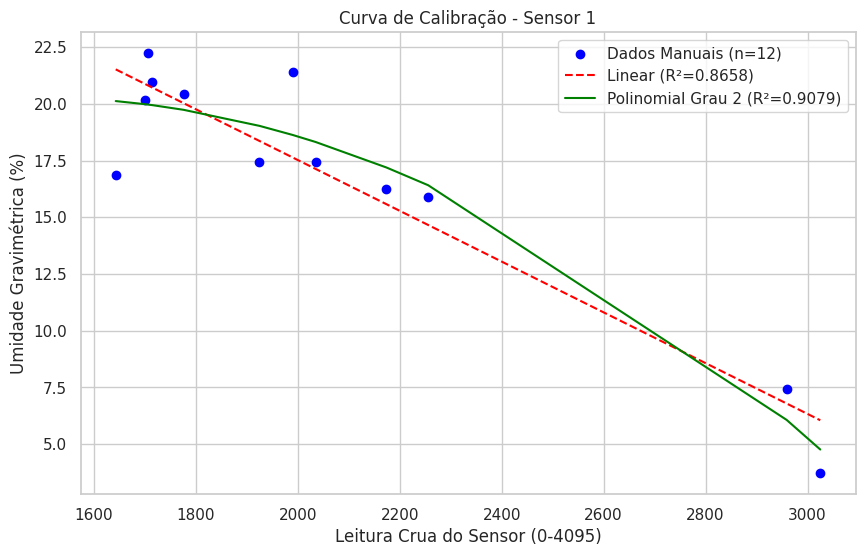

--> Modelo Polinomial escolhido para Sensor 1 (R²=0.9079)
Analisando 12 pontos de dados válidos para Sensor 2.

==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


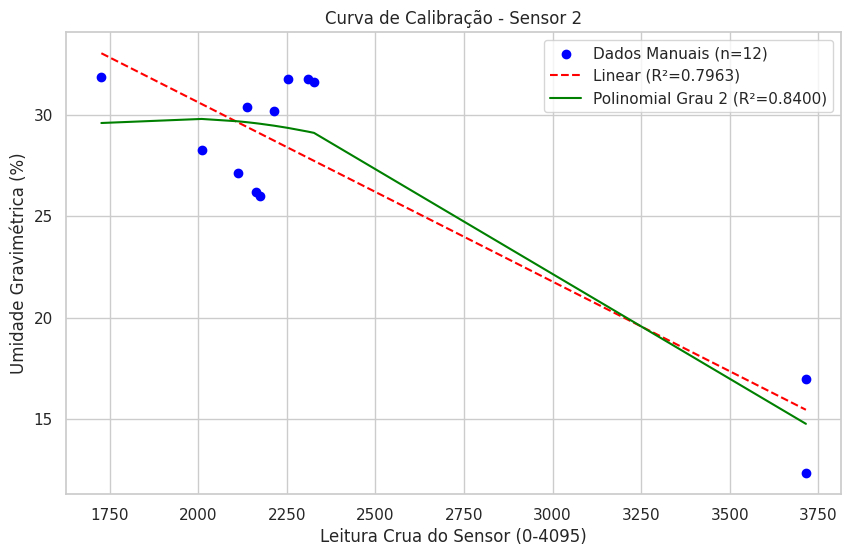

--> Modelo Polinomial escolhido para Sensor 2 (R²=0.8400)
Analisando 12 pontos de dados válidos para Sensor 3.

==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


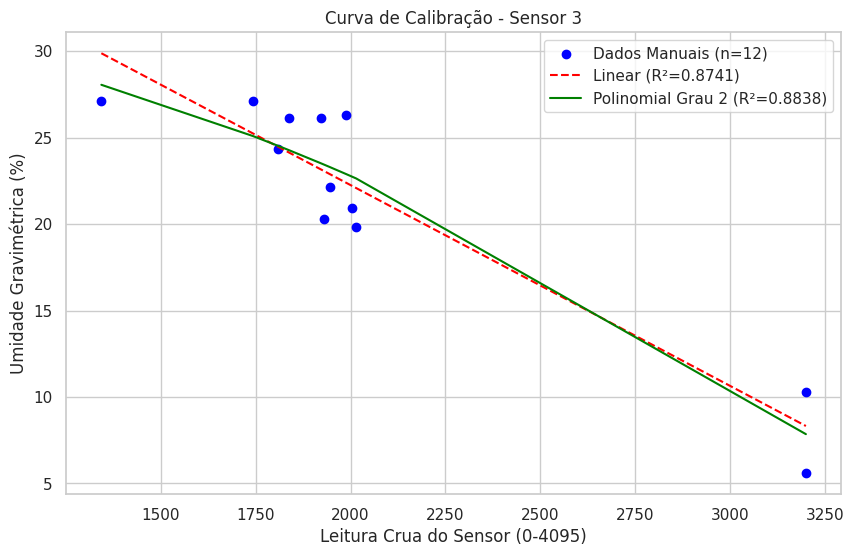

--> Modelo Polinomial escolhido para Sensor 3 (R²=0.8838)
Analisando 12 pontos de dados válidos para Sensor 4.

==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


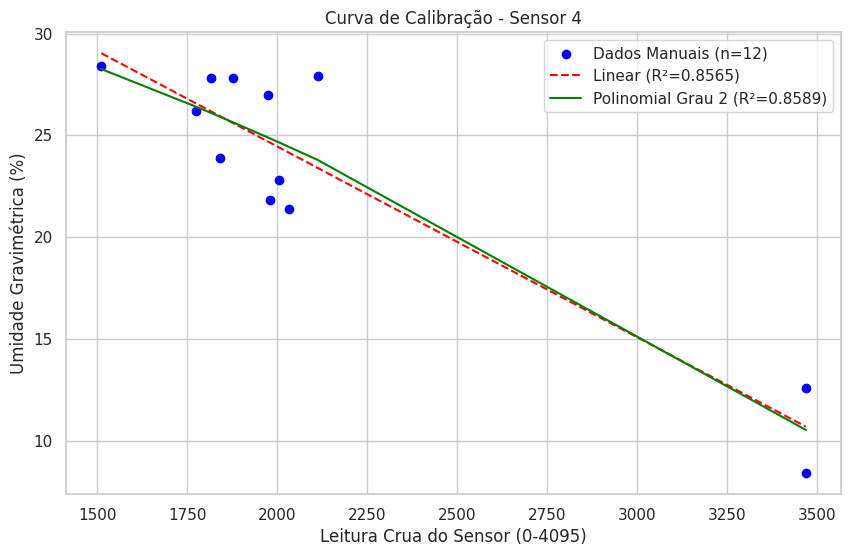

--> Modelo Polinomial escolhido para Sensor 4 (R²=0.8589)


========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas com sucesso no arquivo 'equacoes_de_calibracao.csv'

Melhor equação encontrada para cada sensor:
                tipo     R2  RMSE         a         b  m          c
Sensor                                                             
Sensor 1  Polinomial 0.9079 1.65% -0.000007  0.019598  -   5.681522
Sensor 2  Polinomial 0.8400 2.40% -0.000005  0.018607  -  11.744826
Sensor 3  Polinomial 0.8838 2.25% -0.000002 -0.000082  -  32.458763
Sensor 4  Polinomial 0.8589 2.30% -0.000001 -0.003064  -  35.632806

Procurando planilha de dados crus: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-58-3449154269.py:212: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')


✅ Planilha encontrada: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO NOS DADOS CRUS ---
Ocorreu um erro geral na execução: 'Sensor1'


KeyError: 'Sensor1'

In [ ]:
# =========================================================================
# SCRIPT FINAL (Baseado no seu código funcional, com as melhorias na visualização)
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes das Planilhas (EXATAMENTE como no seu código que funciona) ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração "
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULO 1: CARREGAMENTO DE DADOS (Seu código, que já funciona)
# =========================================================================
def localizar_planilha(gc_instance, nome_alvo):
    planilhas = gc_instance.openall()
    for planilha in planilhas:
        if planilha.title.strip().lower() == nome_alvo.strip().lower():
            print(f"✅ Planilha encontrada: '{planilha.title}'")
            return planilha
    raise FileNotFoundError(f"❌ Planilha '{nome_alvo}' não encontrada. Verifique o nome no Google Drive.")

def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nProcurando planilha de calibração: '{nome_planilha}'")
    planilha = localizar_planilha(gc_instance, nome_planilha)
    sheet = planilha.get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = indices_cabecalho[idx + 1] if idx + 1 < len(indices_cabecalho) else len(valores)
        dados_brutos = [row for row in valores[i_inicio_dados:i_fim_dados] if any(cell.strip() for cell in row)]
        if not dados_brutos: continue
        df_sensor = pd.DataFrame(dados_brutos, columns=header)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce').dt.tz_localize(None)
        df_processado = df_sensor.iloc[:, [5, 7, -1]].copy()
        df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nProcurando planilha de dados crus: '{nome_planilha}'")
    planilha = localizar_planilha(gc_instance, nome_planilha)
    sheet_crus = planilha.get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce').dt.tz_convert(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

# =========================================================================
# MÓDULO 2: ANÁLISE DE CALIBRAÇÃO (Seu código, que já funciona)
# =========================================================================
def analisar_calibracao(df_calibracao_sensor, sensor_name):
    # (O corpo desta função permanece exatamente como no seu código original)
    # ...
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(subset=['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y'], inplace=True)
    if len(df_calibracao_sensor) < 2: return None
    print(f"Analisando {len(df_calibracao_sensor)} pontos de dados válidos para {sensor_name}.")
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    linear_reg = LinearRegression().fit(X, y); r2_linear = linear_reg.score(X, y); rmse_linear = np.sqrt(mean_squared_error(y, linear_reg.predict(X))); m_linear, c_linear = linear_reg.coef_[0], linear_reg.intercept_
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y); r2_poly = poly_reg.score(X_poly, y); rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly))); c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]

    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X, y, color='blue', label=f'Dados Manuais (n={len(df_calibracao_sensor)})')
    X_plot_sorted = np.sort(X, axis=0); ax.plot(X_plot_sorted, linear_reg.predict(X_plot_sorted), color='red', linestyle='--', label=f'Linear (R²={r2_linear:.4f})')
    ax.plot(X_plot_sorted, poly_reg.predict(poly_features.transform(X_plot_sorted)), color='green', linestyle='-', label=f'Polinomial Grau 2 (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua do Sensor (0-4095)'); ax.set_ylabel('Umidade Gravimétrica (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.show()

    if r2_poly >= r2_linear:
        print(f"--> Modelo Polinomial escolhido para {sensor_name} (R²={r2_poly:.4f})")
        return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}
    else:
        print(f"--> Modelo Linear escolhido para {sensor_name} (R²={r2_linear:.4f})")
        return {'tipo': 'Linear', 'R2': r2_linear, 'RMSE': rmse_linear, 'm': m_linear, 'c': c_linear}

# =========================================================================
# MÓDULO 3: APLICAÇÃO E VISUALIZAÇÃO (VERSÃO ATUALIZADA)
# =========================================================================
# =========================================================================
# MÓDULO 3: APLICAÇÃO E VISUALIZAÇÃO (VERSÃO FINAL CORRIGIDA)
# =========================================================================
def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao_completos):
    print("\n\n--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO NOS DADOS CRUS ---")

    # Primeiro, aplica a calibração para todos os sensores
    df_estimado = df_crus.copy() # Cria uma cópia para trabalhar
    for sensor_name, eq in equacoes.items():
        coluna_crua = sensor_name.replace(" ", "") # ex: 'Sensor 1' -> 'Sensor1'
        coluna_estimada = f'Umidade_Estimada_{sensor_name.replace(" ", "_")}'

        # Função para aplicar a equação de calibração
        def converterLeituraParaUmidade(leitura_crua, equacao=eq):
            x = float(leitura_crua)
            if equacao['tipo'] == 'Polinomial':
                umidade = (equacao['a'] * x * x) + (equacao['b'] * x) + equacao['c']
            else: # Linear
                umidade = (equacao['m'] * x) + equacao['c']
            return np.clip(umidade, 0, 100) # Limita entre 0 e 100

        df_estimado[coluna_estimada] = df_estimado[coluna_crua].apply(converterLeituraParaUmidade)
        print(f"Umidade estimada calculada para {sensor_name}.")

    # --- Plotagem Individual (Gráfico de Validação) ---
    for sensor_name in equacoes.keys():
        coluna_estimada = f'Umidade_Estimada_{sensor_name.replace(" ", "_")}'

        print(f"\n==================== VALIDAÇÃO E SÉRIE TEMPORAL: {sensor_name} ====================")

        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 7))

        # 1. Plota a série temporal completa (a previsão contínua do modelo)
        ax.plot(df_estimado['timestamp'], df_estimado[coluna_estimada],
                label='Umidade Estimada (Modelo)', color='royalblue', lw=2)

        # 2. Plota os pontos de calibração manual por cima para validação visual
        df_calibracao_sensor = dados_calibracao_completos[sensor_name]
        df_calibracao_sensor.dropna(subset=['timestamp', 'Umidade_Gravimetrica_Y'], inplace=True)

        # Garante que a umidade manual seja numérica
        if df_calibracao_sensor['Umidade_Gravimetrica_Y'].dtype == 'object':
            df_calibracao_sensor['Umidade_Gravimetrica_Y'] = df_calibracao_sensor['Umidade_Gravimetrica_Y'].str.replace(',', '.').str.replace('%', '').astype(float)

        ax.scatter(df_calibracao_sensor['timestamp'], df_calibracao_sensor['Umidade_Gravimetrica_Y'],
                   color='red', s=100, ec='black', zorder=5, label='Medições Manuais (Gabarito)')

        ax.set_title(f'Validação da Calibração ({sensor_name})', fontsize=16, fontweight='bold')
        ax.set_xlabel('Data e Hora da Leitura', fontsize=12)
        ax.set_ylabel('Umidade (%)', fontsize=12)
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

        # Formatação do eixo de data para mostrar dias e meses de forma legível
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Mostra uma marca a cada 2 dias
        fig.autofmt_xdate() # Melhora o espaçamento das datas rotacionadas

        ax.legend()
        plt.show()

    # --- Plotagem Final (Gráfico Comparativo de Todos os Sensores) ---
    print("\n==================== GRÁFICO COMPARATIVO FINAL (SÉRIE TEMPORAL) ====================")
    fig, ax = plt.subplots(figsize=(16, 9))
    for i in range(1, 5):
        col_name = f'Umidade_Estimada_S{i}'
        sensor_label = f'Sensor {i}'
        ax.plot(df_estimado['timestamp'], df_estimado[col_name], label=sensor_label, alpha=0.9)

    ax.set_title('Série Temporal da Umidade do Solo Estimada (Calibrada)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Data e Hora da Coleta'); ax.set_ylabel('Umidade Estimada (%)')
    ax.legend(); ax.grid(True, which='both', linestyle='--');
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')); ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    fig.autofmt_xdate()
    plt.tight_layout(); plt.show()


# =========================================================================
# ORQUESTRADOR PRINCIPAL (main) - ATUALIZADO
# =========================================================================
def main():
    try:
        # Fase 1
        dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
        resultados_finais = {}
        if dados_calibracao:
            for sensor, df_dados in dados_calibracao.items():
                modelo = analisar_calibracao(df_dados, sensor)
                if modelo: resultados_finais[sensor] = modelo

        # Tabela-Resumo
        if resultados_finais:
            print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
            df_equacoes = pd.DataFrame(resultados_finais).T
            df_equacoes.index.name = "Sensor"
            colunas_ordenadas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'm', 'c']
            df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')
            df_equacoes.to_csv('equacoes_de_calibracao.csv')
            print("✅ Equações salvas com sucesso no arquivo 'equacoes_de_calibracao.csv'")
            print("\nMelhor equação encontrada para cada sensor:")
            print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format}))
            print("="*75)

        # Fase 2
        dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
        if not dados_crus.empty and resultados_finais:
            # Passa os dados de calibração para a função de visualização para plotar os pontos de gabarito
            aplicar_e_visualizar(dados_crus, resultados_finais, dados_calibracao)
        else:
            print("\nAVISO: Fase de aplicação pulada por falta de dados ou equações.")

    except Exception as e:
        print(f"Ocorreu um erro geral na execução: {e}"); raise e

    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

✅ Autenticação com Google Drive/Sheets bem-sucedida!


--- FASE 1: CALIBRAÇÃO DOS SENSORES ---
Abrindo a planilha de calibração: 'Tabela coleta de dados p_ calibração.xlsx - Dados coletados'
Processando bloco de dados para 'Sensor 1'...
Processando bloco de dados para 'Sensor 2'...
Processando bloco de dados para 'Sensor 3'...
Processando bloco de dados para 'Sensor 4'...

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


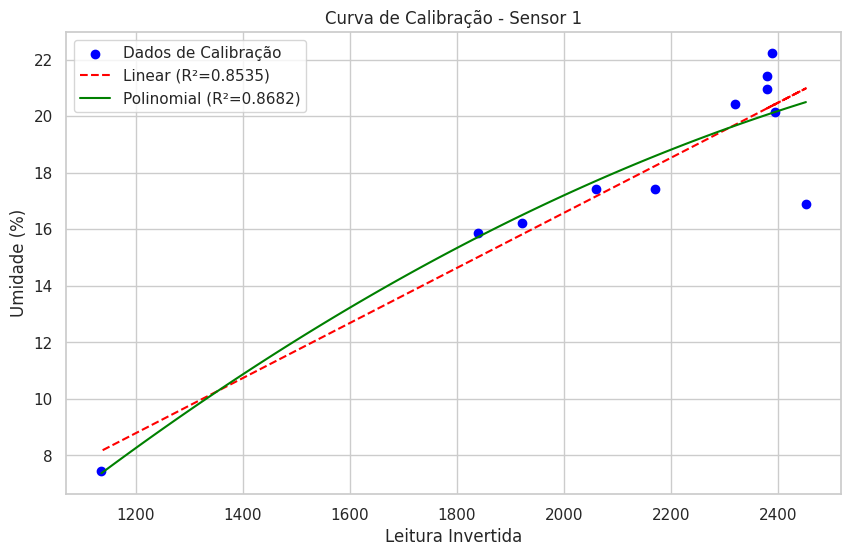


==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


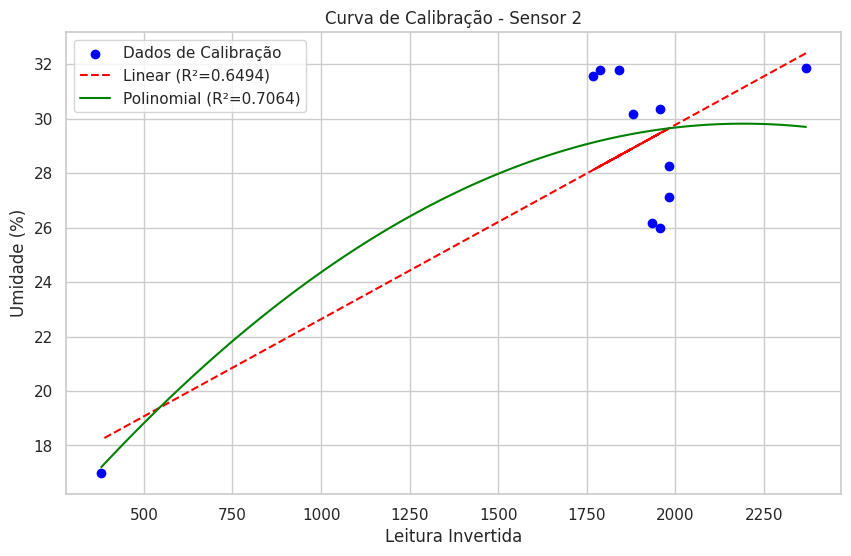


==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


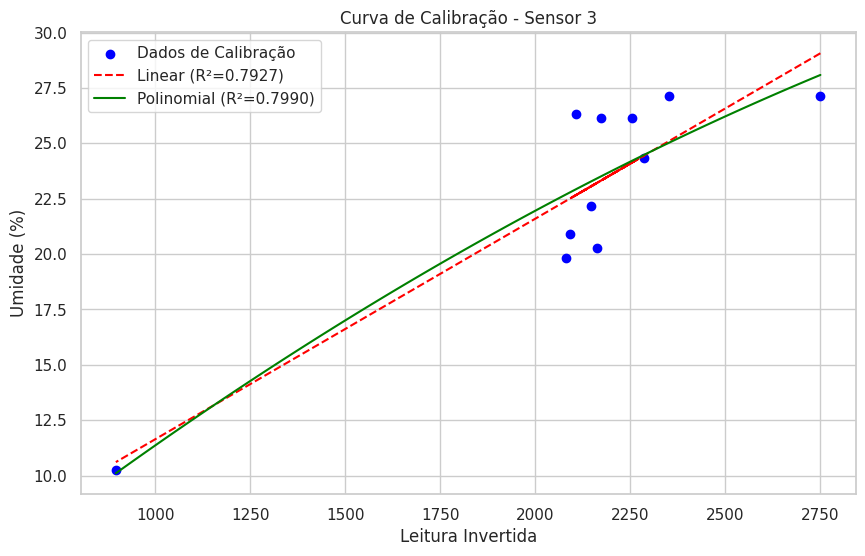


==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


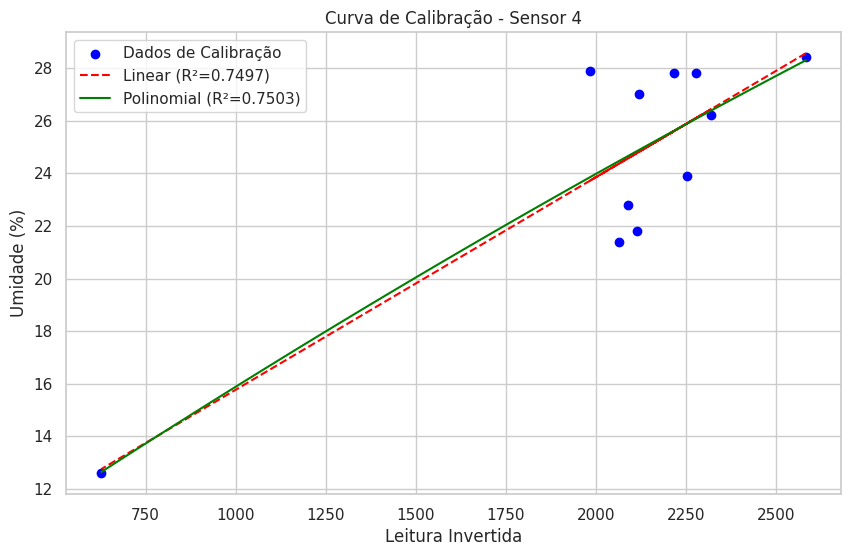



--- FASE 2: APLICAÇÃO DA CALIBRAÇÃO NOS DADOS CRUS ---
Lendo os dados crus do arquivo: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'
Aplicando equações de calibração em 71418 leituras...
Umidade calculada para Sensor 1.
Umidade calculada para Sensor 2.
Umidade calculada para Sensor 3.
Umidade calculada para Sensor 4.

Gerando gráfico da série temporal da umidade estimada...


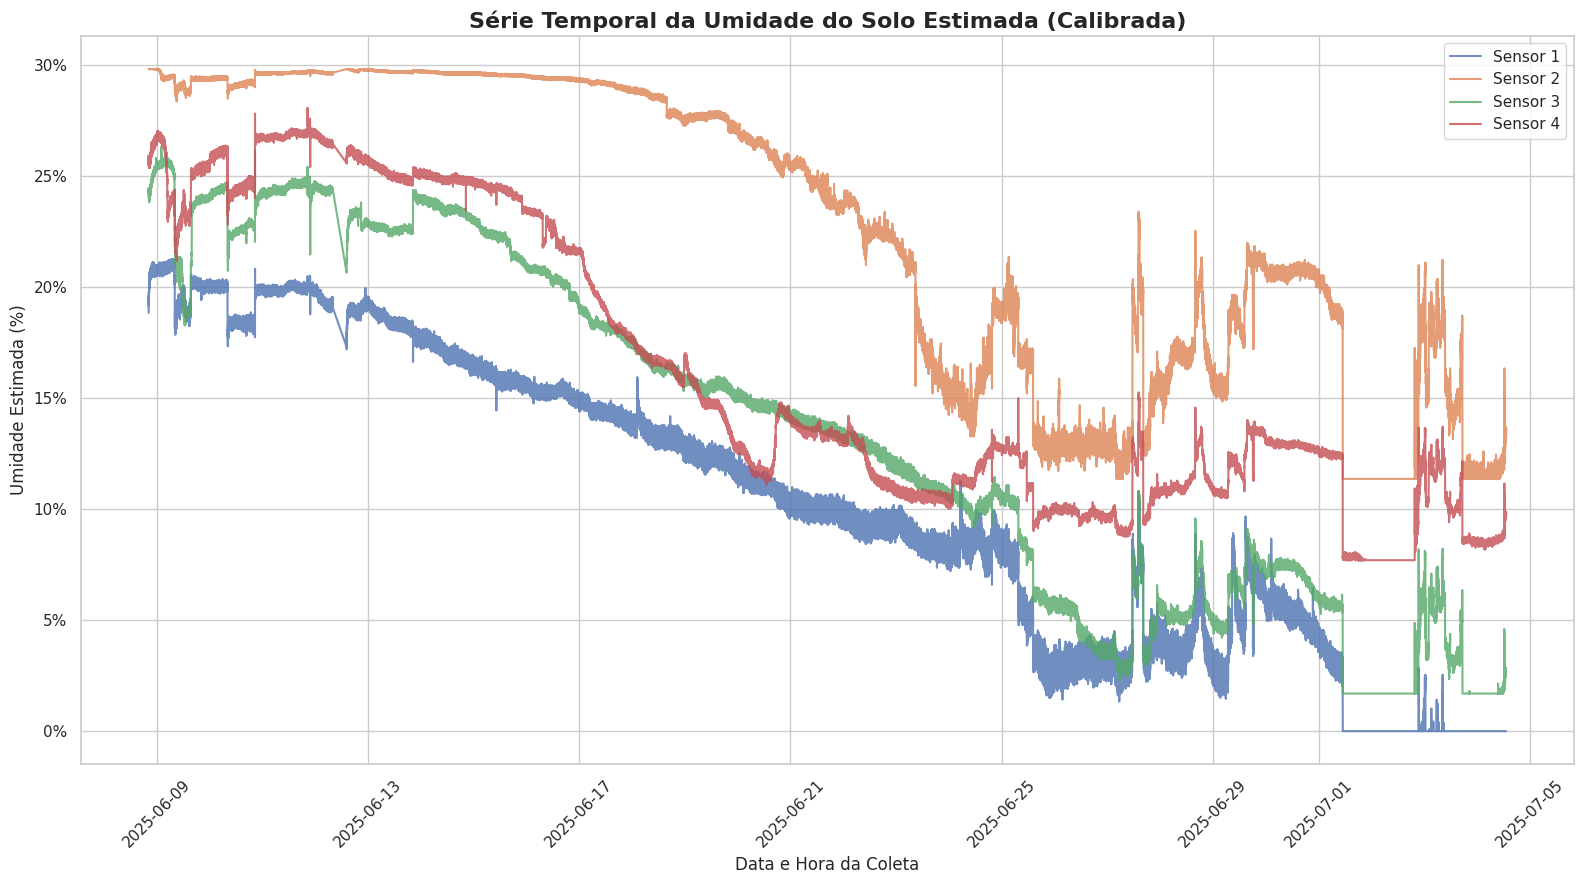


Processo completo concluído.


In [ ]:
# =========================================================================
# SCRIPT CORRIGIDO (VERSÃO FINAL-8)
# Utiliza a abordagem de nomes de arquivo que já funcionou para você.
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from google.colab import auth
import gspread
from google.auth import default

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes dos Arquivos de Planilha (EXATAMENTE como no seu código que funcionou) ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p_ calibração.xlsx - Dados coletados"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# --- Função de Análise (Não precisa modificar) ---
def analisar_calibracao(df_calibracao_sensor, sensor_name):
    if df_calibracao_sensor is None or df_calibracao_sensor.empty: return None
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(inplace=True)
    if len(df_calibracao_sensor) < 2: return None
    df_calibracao_sensor['Leitura_Invertida'] = 4095 - df_calibracao_sensor['Leitura_Sensor_Cru']
    X = df_calibracao_sensor['Leitura_Invertida'].values.reshape(-1, 1)
    y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    plt.figure(figsize=(10, 6)); plt.scatter(X, y, color='blue', label='Dados de Calibração')
    plt.xlabel('Leitura Invertida'); plt.ylabel('Umidade (%)'); plt.title(f'Curva de Calibração - {sensor_name}');
    linear_reg = LinearRegression().fit(X, y); r2_linear = linear_reg.score(X, y); m_linear = linear_reg.coef_[0]; c_linear = linear_reg.intercept_
    plt.plot(X, linear_reg.predict(X), color='red', linestyle='--', label=f'Linear (R²={r2_linear:.4f})')
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y); r2_poly = poly_reg.score(X_poly, y)
    X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    plt.plot(X_plot, poly_reg.predict(poly_features.transform(X_plot)), color='green', label=f'Polinomial (R²={r2_poly:.4f})')
    c0_poly = poly_reg.intercept_; b_poly = poly_reg.coef_[0]; a_poly = poly_reg.coef_[1]
    plt.legend(); plt.grid(True); plt.show()
    if r2_poly > r2_linear + 0.01: return {'tipo': 'polinomial', 'a': a_poly, 'b': b_poly, 'c': c0_poly}
    else: return {'tipo': 'linear', 'm': m_linear, 'c': c_linear}

# =========================================================================
# EXECUÇÃO PRINCIPAL
# =========================================================================
try:
    # --- FASE 1: CALIBRAÇÃO ---
    print("\n\n--- FASE 1: CALIBRAÇÃO DOS SENSORES ---")
    equacoes = {}
    print(f"Abrindo a planilha de calibração: '{NOME_PLANILHA_DADOS_MANUAIS}'")
    sheet_manual = gc.open(NOME_PLANILHA_DADOS_MANUAIS).get_worksheet(0)
    valores = sheet_manual.get_all_values()

    dados_por_sensor = {}
    sensor_count = 0
    for i, row in enumerate(valores):
        if row and len(row) > 1 and row[0] == 'Ponto de Coleta':
            sensor_count += 1; sensor_name = f'Sensor {sensor_count}'
            print(f"Processando bloco de dados para '{sensor_name}'...")
            header = valores[i]; dados_brutos = valores[i+1 : i+12]
            df_sensor = pd.DataFrame(dados_brutos, columns=header)
            col_leitura_nome = df_sensor.columns[5]; col_umidade_nome = df_sensor.columns[7]
            df_processado = df_sensor[[col_leitura_nome, col_umidade_nome]].copy()
            df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y']
            dados_por_sensor[sensor_name] = df_processado

    if dados_por_sensor:
        for sensor, df_dados in dados_por_sensor.items():
            equacao = analisar_calibracao(df_dados, sensor)
            if equacao: equacoes[sensor] = equacao

    # --- FASE 2: APLICAÇÃO DA CALIBRAÇÃO ---
    print("\n\n--- FASE 2: APLICAÇÃO DA CALIBRAÇÃO NOS DADOS CRUS ---")
    if not equacoes:
        print("AVISO: Análise da Série Temporal pulada porque nenhuma equação de calibração foi gerada.")
    else:
        print(f"Lendo os dados crus do arquivo: '{NOME_PLANILHA_DADOS_CRUS}'")
        sheet_crus = gc.open(NOME_PLANILHA_DADOS_CRUS).get_worksheet(0)
        valores_crus = sheet_crus.get_all_values()
        df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
        colunas_necessarias = ['created_at', 'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4']
        df_crus_selecionados = df_crus[colunas_necessarias].copy()
        df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['created_at'], errors='coerce')
        df_crus_selecionados.dropna(subset=['timestamp'], inplace=True)
        print(f"Aplicando equações de calibração em {len(df_crus_selecionados)} leituras...")
        for i in range(1, 5):
            nome_sensor_modelo = f'Sensor {i}'; nome_coluna_crua = f'Sensor{i}'; nome_coluna_calculada = f'Umidade_Estimada_S{i}'
            eq = equacoes.get(nome_sensor_modelo)
            if not eq: continue
            df_crus_selecionados[nome_coluna_crua] = pd.to_numeric(df_crus_selecionados[nome_coluna_crua], errors='coerce')
            leitura_invertida = 4095.0 - df_crus_selecionados[nome_coluna_crua]
            if eq['tipo'] == 'polinomial': umidade = (eq['a'] * leitura_invertida**2) + (eq['b'] * leitura_invertida) + eq['c']
            else: umidade = (eq['m'] * leitura_invertida) + eq['c']
            df_crus_selecionados[nome_coluna_calculada] = np.clip(umidade, 0, 100)
            print(f"Umidade calculada para {nome_sensor_modelo}.")
        print("\nGerando gráfico da série temporal da umidade estimada...")
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(16, 9))
        for i in range(1, 5):
            nome_coluna_calculada = f'Umidade_Estimada_S{i}'
            if nome_coluna_calculada in df_crus_selecionados.columns:
                ax.plot(df_crus_selecionados['timestamp'], df_crus_selecionados[nome_coluna_calculada], label=f'Sensor {i}', linewidth=1.5, alpha=0.8)
        ax.set_title('Série Temporal da Umidade do Solo Estimada (Calibrada)', fontsize=16, fontweight='bold')
        ax.set_xlabel('Data e Hora da Coleta', fontsize=12); ax.set_ylabel('Umidade Estimada (%)', fontsize=12)
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
        plt.xticks(rotation=45); ax.legend(); plt.tight_layout(); plt.show()

except gspread.exceptions.SpreadsheetNotFound as e:
    print(f"❌ ERRO CRÍTICO: Não foi possível encontrar uma das planilhas. Verifique os nomes EXATOS dos arquivos no seu Google Drive.")
    print(f"Detalhes do erro: {e}")
except Exception as e:
    print(f"Ocorreu um erro geral na execução: {e}")
    raise e

print("\nProcesso completo concluído.")

# Analise (Gpt)

✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 13 pontos de dados válidos para Sensor 1.
--- Estatísticas Descritivas para Sensor 1 ---
       Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
count               13.00                   13.00
mean              2221.08                   15.40
std                692.45                    7.13
min               1643.00                    0.00
25%               1715.00                   15.88
50%               1990.00                   17.42
75%               2256.00                   20.42
max               3970.00                   22.23
Analisando 13 pontos de dados válidos para Sensor 2.
--- Estatísticas Descritivas para Sensor 2 ---
       Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
count               13.00  

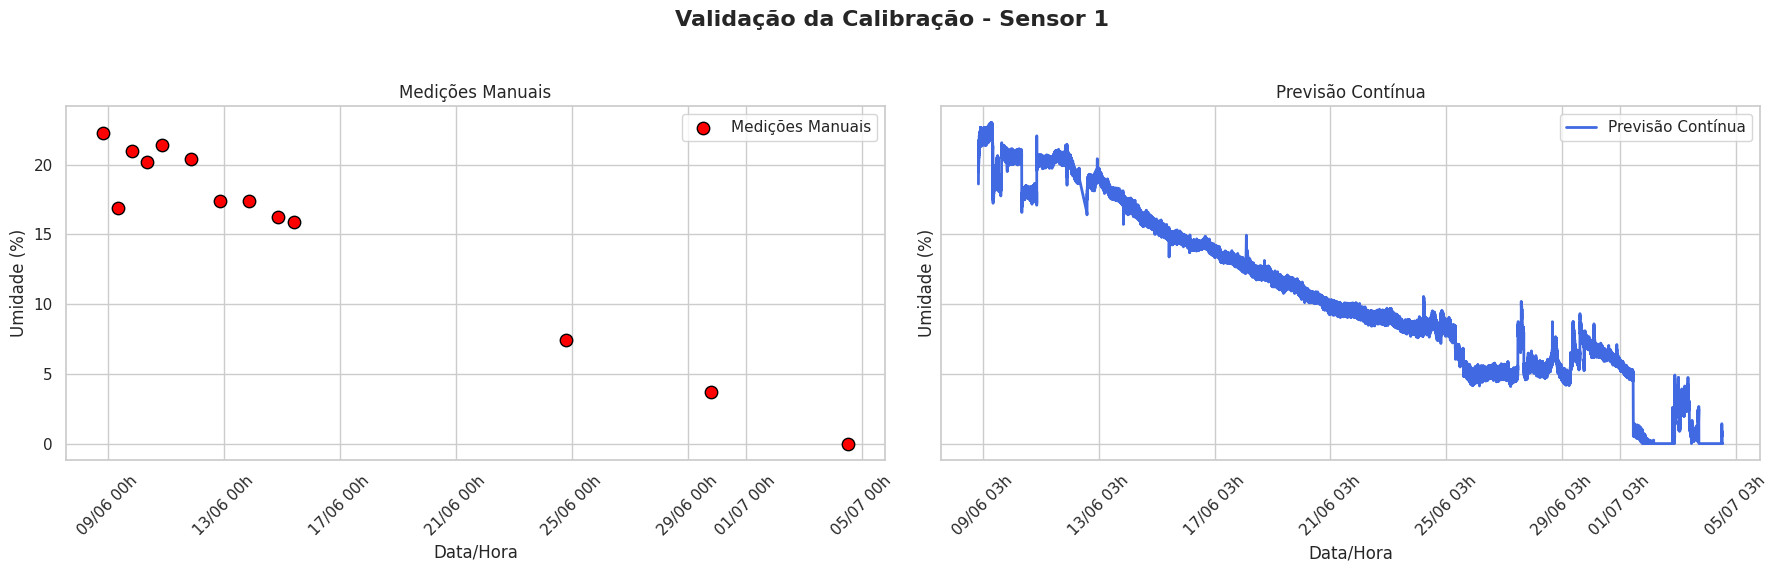

📈 Gráfico salvo: comparativo_calibracao_sensor_2.png


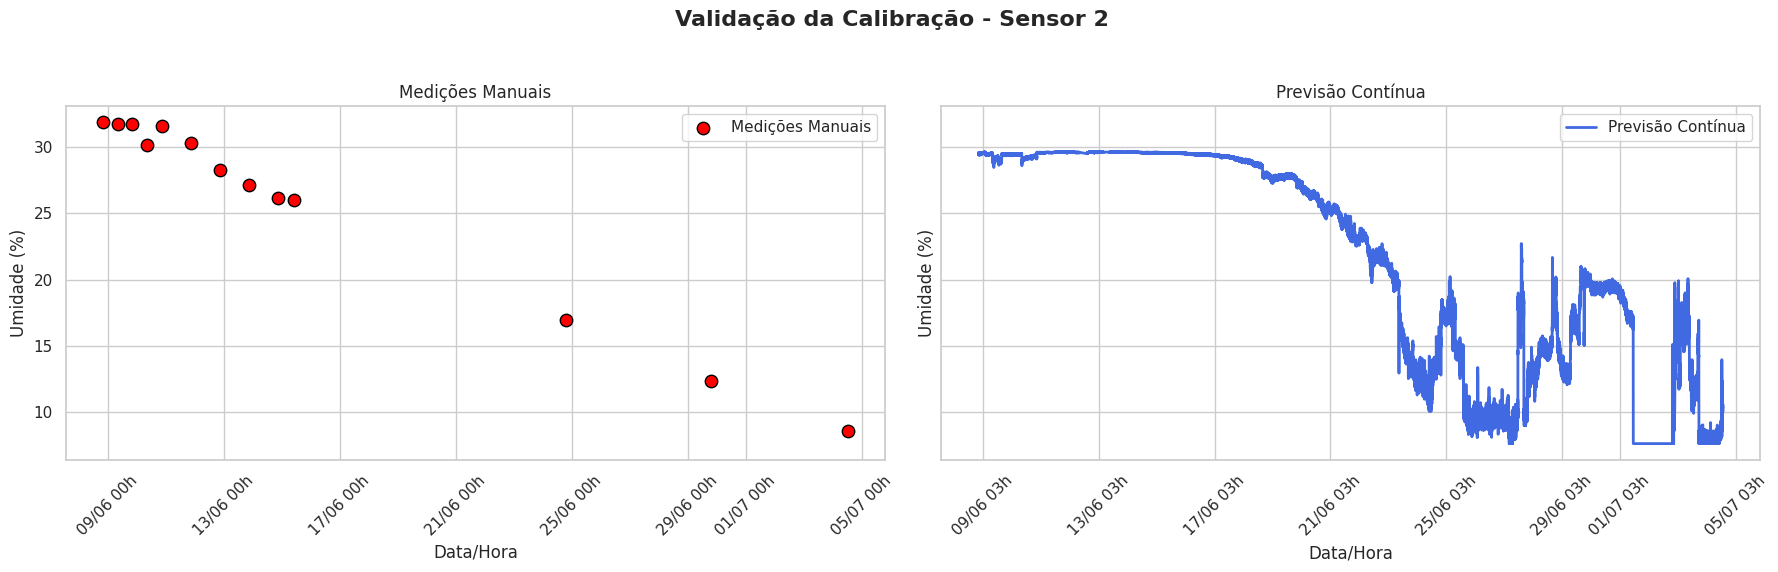

📈 Gráfico salvo: comparativo_calibracao_sensor_3.png


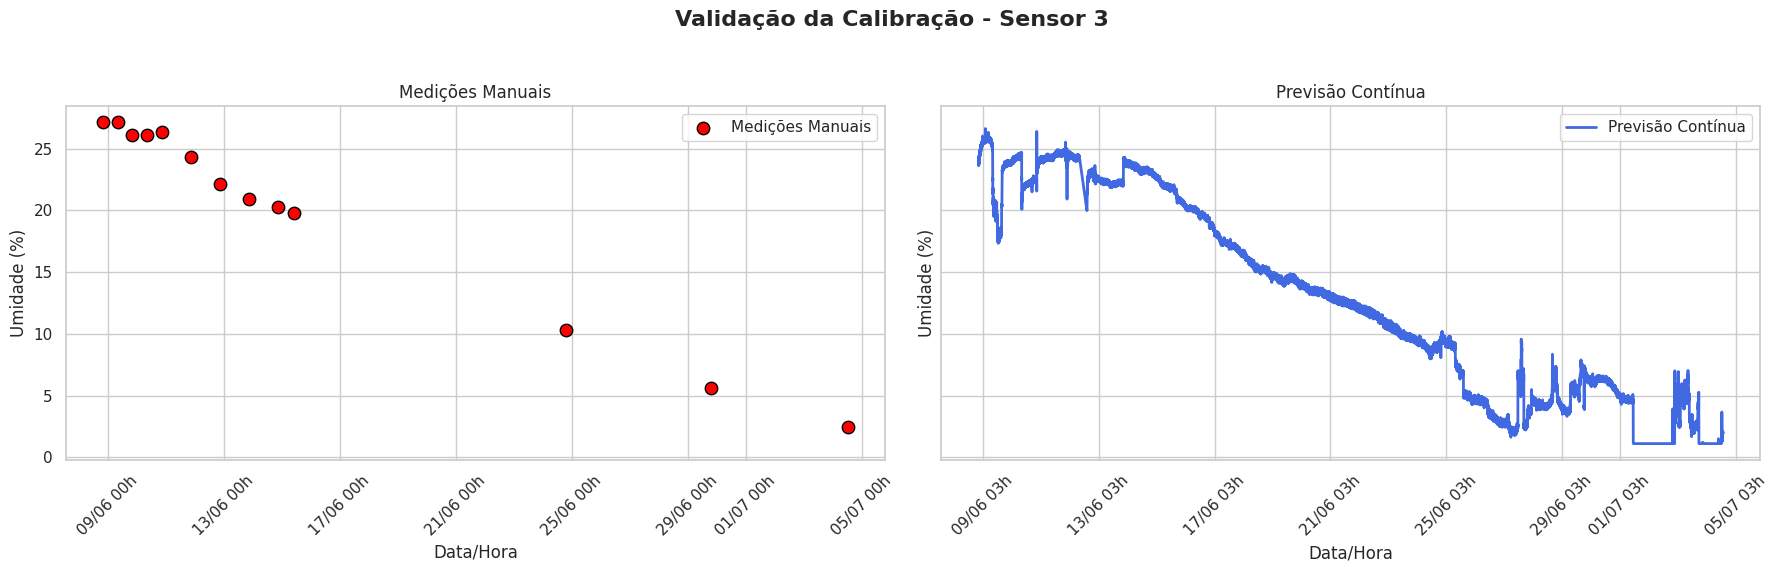

📈 Gráfico salvo: comparativo_calibracao_sensor_4.png


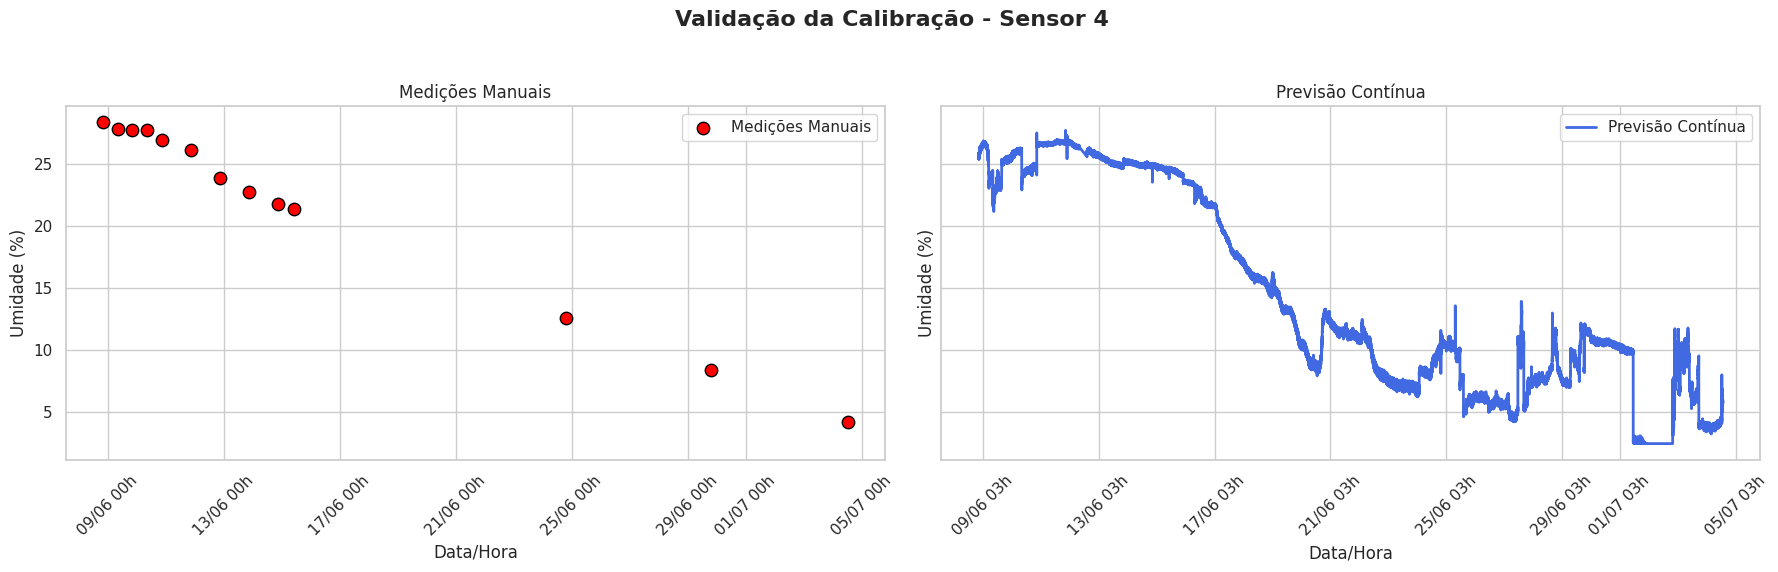

In [ ]:
# =========================================================================
# SCRIPT FINAL MELHORADO: VISUALIZAÇÃO APRIMORADA
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULO 1: CARREGAMENTO DE DADOS
# =========================================================================
def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho):
            i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        dados_brutos_limpos = [row for row in dados_brutos if any(cell for cell in row)]
        if not dados_brutos_limpos:
            continue
        df_sensor = pd.DataFrame(dados_brutos_limpos, columns=header)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')
        df_processado = df_sensor.iloc[:, [5, 7, -1]].copy()
        df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

# =========================================================================
# MÓDULO 2: ANÁLISE DE CALIBRAÇÃO
# =========================================================================
def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(subset=['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y'], inplace=True)
    print(f"Analisando {len(df_calibracao_sensor)} pontos de dados válidos para {sensor_name}.")
    if len(df_calibracao_sensor) < 2:
        print(f"ERRO: Dados insuficientes para {sensor_name}.")
        return None
    print(f"--- Estatísticas Descritivas para {sensor_name} ---")
    print(df_calibracao_sensor[['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y']].describe().round(2).to_string())
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1)
    y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    linear_reg = LinearRegression().fit(X, y)
    y_pred_linear = linear_reg.predict(X)
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y)
    y_pred_poly = poly_reg.predict(X_poly)
    r2_linear = r2_score(y, y_pred_linear)
    r2_poly = r2_score(y, y_pred_poly)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
    m_linear, c_linear = linear_reg.coef_[0], linear_reg.intercept_
    if r2_poly >= r2_linear:
        return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}
    else:
        return {'tipo': 'Linear', 'R2': r2_linear, 'RMSE': rmse_linear, 'm': m_linear, 'c': c_linear}

# =========================================================================
# MÓDULO 3: VISUALIZAÇÃO APRIMORADA
# =========================================================================
def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao_completos):
    print("\n--- VISUALIZAÇÃO APRIMORADA ---")
    for sensor_name, eq in equacoes.items():
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter_leitura(x):
            x = float(x)
            if eq['tipo'] == 'Polinomial':
                umidade = eq['a'] * x**2 + eq['b'] * x + eq['c']
            else:
                umidade = eq['m'] * x + eq['c']
            return min(max(umidade, 0), 100)
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter_leitura)
        df_calibracao = dados_calibracao_completos[sensor_name].dropna(subset=['timestamp', 'Umidade_Gravimetrica_Y'])

        # Gráfico lado a lado
        fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

        # Medições manuais
        axs[0].scatter(df_calibracao['timestamp'], df_calibracao['Umidade_Gravimetrica_Y'],
                       color='red', edgecolor='black', s=80, label='Medições Manuais')
        axs[0].set_title('Medições Manuais')
        axs[0].set_xlabel('Data/Hora')
        axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
        axs[0].legend()
        axs[0].grid(True)

        # Previsão contínua
        axs[1].plot(df_sensor_ts['timestamp'], df_sensor_ts['Umidade_Estimada'],
                    color='royalblue', lw=2, label='Previsão Contínua')
        axs[1].set_title('Previsão Contínua')
        axs[1].set_xlabel('Data/Hora')
        axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %Hh'))
        axs[1].legend()
        axs[1].grid(True)

        # Eixo Y compartilhado
        for ax in axs:
            ax.set_ylabel('Umidade (%)')
            ax.tick_params(axis='x', rotation=45)

        plt.suptitle(f'Validação da Calibração - {sensor_name}', fontsize=16, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        nome_arquivo = f'comparativo_calibracao_{sensor_name.replace(" ", "_").lower()}.png'
        plt.savefig(nome_arquivo, dpi=300)
        print(f"📈 Gráfico salvo: {nome_arquivo}")
        plt.show()

# =========================================================================
# ORQUESTRADOR PRINCIPAL
# =========================================================================
def main():
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados = {}
    for sensor, df_dados in dados_calibracao.items():
        modelo = analisar_calibracao(df_dados, sensor)
        if modelo:
            resultados[sensor] = modelo
    if resultados:
        print("\nResumo das equações encontradas:")
        df_eq = pd.DataFrame(resultados).T
        df_eq.index.name = "Sensor"
        df_eq.to_csv('equacoes_de_calibracao.csv')
        print(df_eq.to_string())
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty and resultados:
        aplicar_e_visualizar(dados_crus, resultados, dados_calibracao)
    else:
        print("⚠️ Dados crus ou equações ausentes. Processo final não executado.")

if __name__ == "__main__":
    main()


# Analise atualizada (Gemini) -> erro absoluto



✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 14 pontos de dados válidos para Sensor 1.

--- Tabela de Comparação de Erros para Sensor 1 ---
Ponto_Coleta  Umidade_Real_Medida  Umidade_Prevista_Pelo_Modelo  Erro_Absoluto
      1 (CC)                22.23                         21.90           0.33
           2                22.23                         21.84           0.39
           3                20.96                         21.77           0.81
           4                20.15                         21.99           1.84
           5                21.42                         17.92           3.50
           6                20.42                         20.89           0.47
           7                17.42                         18.80     

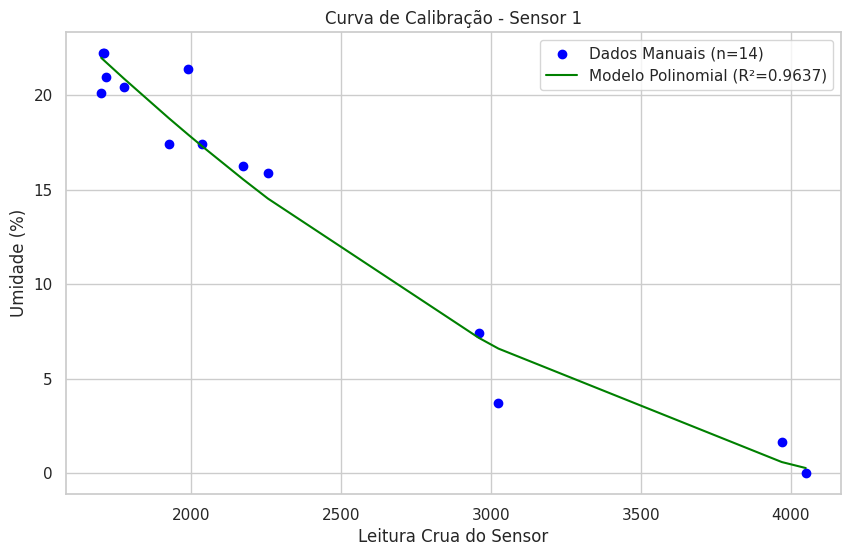

Analisando 14 pontos de dados válidos para Sensor 2.

--- Tabela de Comparação de Erros para Sensor 2 ---
Ponto_Coleta  Umidade_Real_Medida  Umidade_Prevista_Pelo_Modelo  Erro_Absoluto
      1 (CC)                31.88                         28.87           3.01
           2                31.78                         29.51           2.27
           3                31.78                         29.60           2.18
           4                30.17                         29.64           0.53
           5                31.59                         29.48           2.11
           6                30.36                         29.65           0.71
           7                28.27                         29.48           1.21
           8                27.13                         29.63           2.50
           9                26.19                         29.65           3.46
          10                26.00                         29.65           3.65
11 (ou mais)             

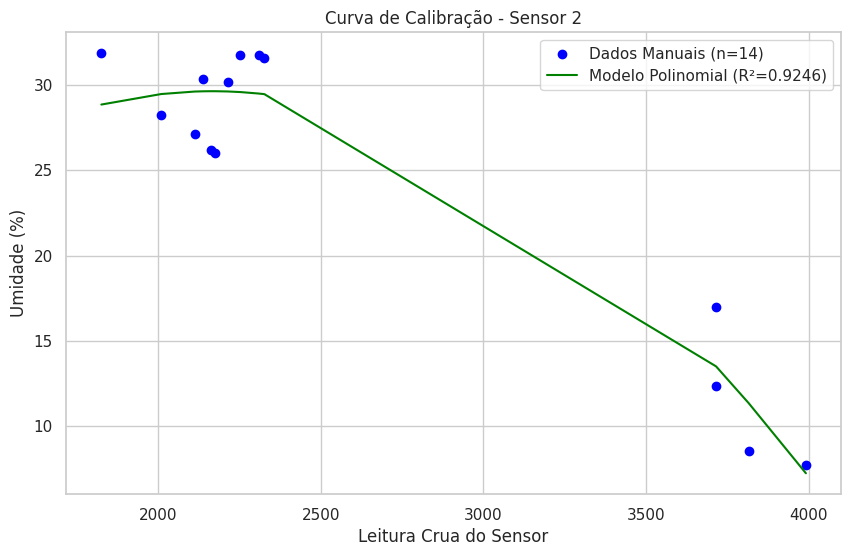

Analisando 14 pontos de dados válidos para Sensor 3.

--- Tabela de Comparação de Erros para Sensor 3 ---
Ponto_Coleta  Umidade_Real_Medida  Umidade_Prevista_Pelo_Modelo  Erro_Absoluto
      1 (CC)                25.23                         28.69           3.46
           2                27.12                         24.89           2.23
           3                26.13                         22.99           3.14
           4                26.13                         23.86           2.27
           5                26.31                         22.27           4.04
           6                24.32                         24.18           0.14
           7                22.16                         22.71           0.55
           8                20.90                         22.11           1.21
           9                20.27                         22.88           2.61
          10                19.82                         21.99           2.17
11 (ou mais)             

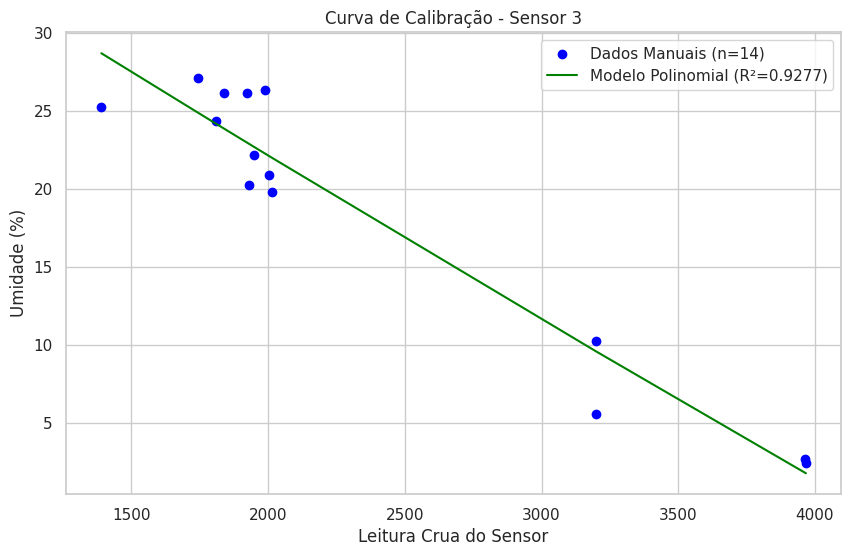

Analisando 14 pontos de dados válidos para Sensor 4.

--- Tabela de Comparação de Erros para Sensor 4 ---
Ponto_Coleta  Umidade_Real_Medida  Umidade_Prevista_Pelo_Modelo  Erro_Absoluto
      1 (CC)                 28.4                         28.05           0.35
           2                 27.9                         23.90           4.00
           3                 27.8                         25.67           2.13
           4                 27.8                         26.09           1.71
           5                 27.0                         24.95           2.05
           6                 26.2                         26.37           0.17
           7                 23.9                         25.91           2.01
           8                 22.8                         24.73           1.93
           9                 21.8                         24.91           3.11
          10                 21.4                         24.52           3.12
11 (ou mais)             

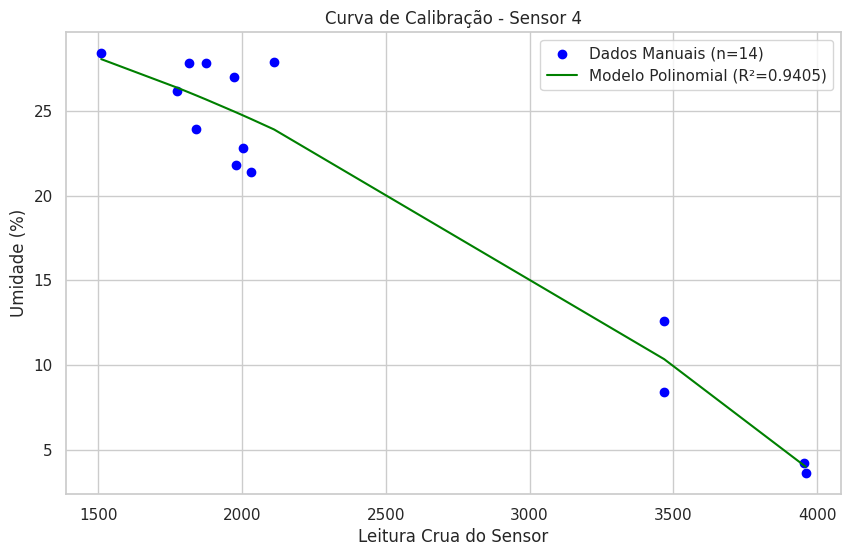



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas com sucesso no arquivo 'equacoes_de_calibracao.csv'

Melhor equação encontrada para cada sensor:
                tipo     R2  RMSE             a         b          c
Sensor                                                              
Sensor 1  Polinomial 0.9637 1.47%  2.318573e-06 -0.022572  53.659372
Sensor 2  Polinomial 0.9246 2.37% -6.743017e-06  0.029223  -2.011071
Sensor 3  Polinomial 0.9277 2.38%  1.482209e-07 -0.011230  44.012845
Sensor 4  Polinomial 0.9405 2.14% -1.578079e-06 -0.001196  33.463596

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-45-4198701437.py:141: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')




--- FASE 2: VALIDAÇÃO VISUAL DA CALIBRAÇÃO ---

==================== GRÁFICO DE VALIDAÇÃO: Sensor 1 ====================


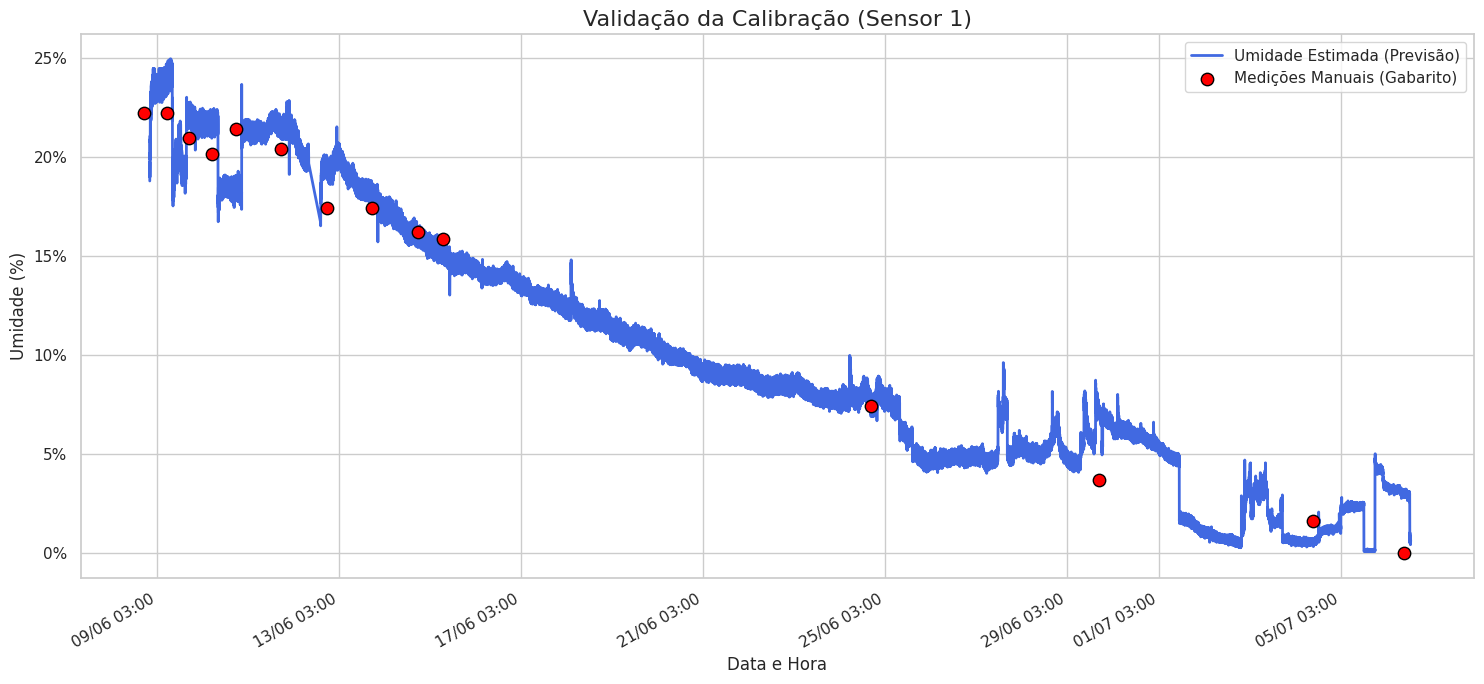


==================== GRÁFICO DE VALIDAÇÃO: Sensor 2 ====================


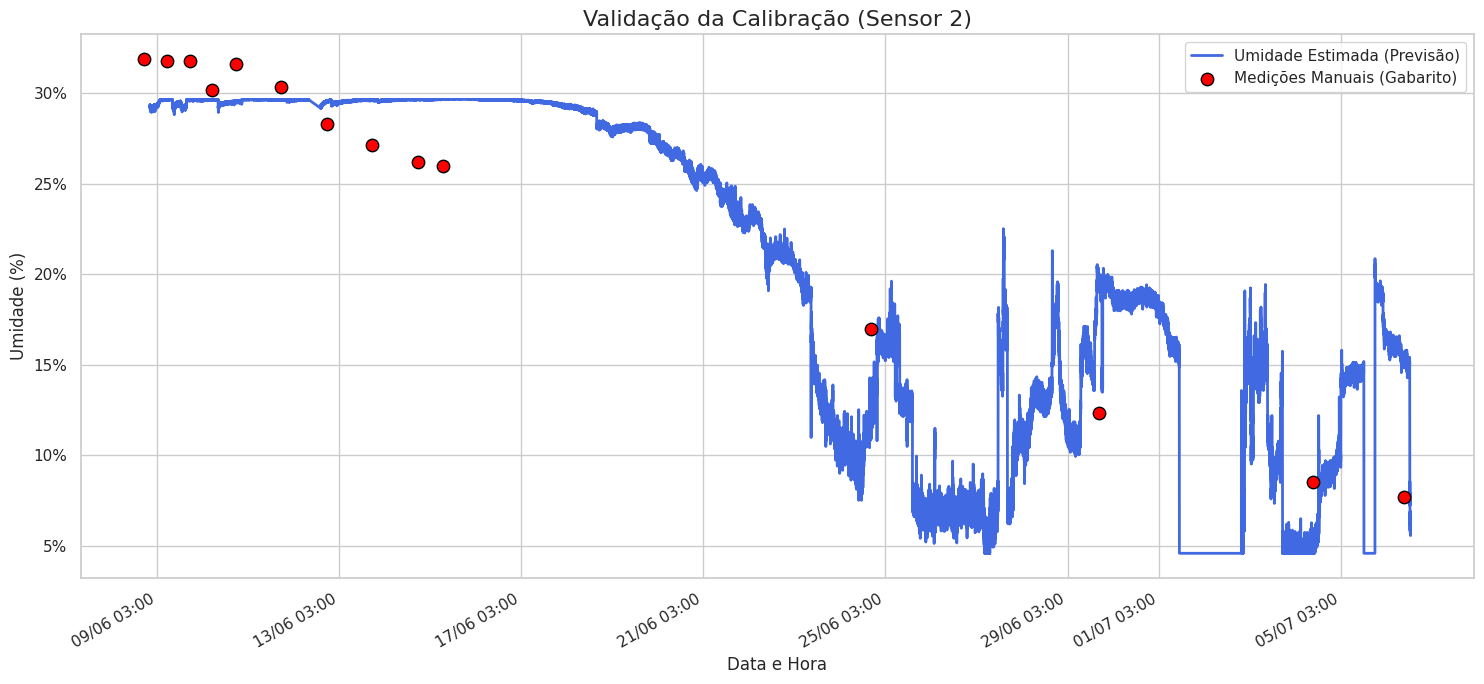


==================== GRÁFICO DE VALIDAÇÃO: Sensor 3 ====================


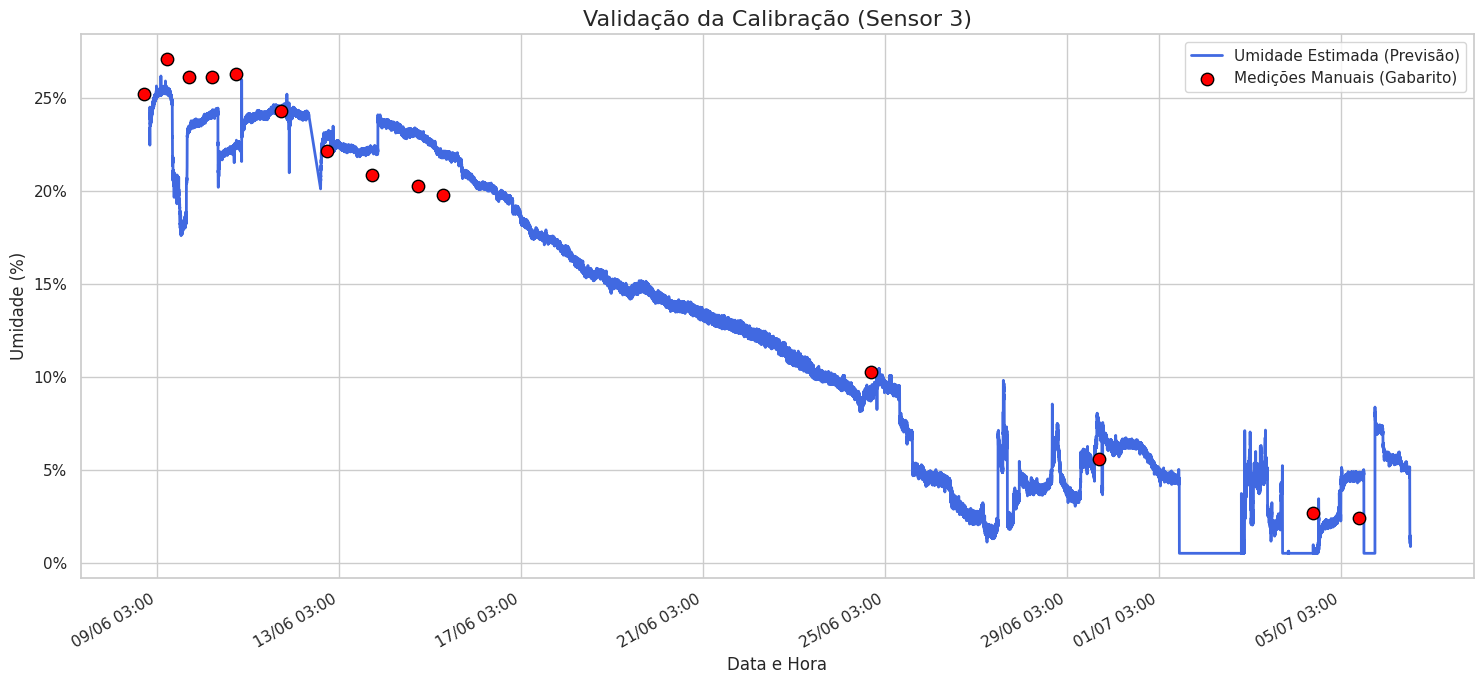


==================== GRÁFICO DE VALIDAÇÃO: Sensor 4 ====================


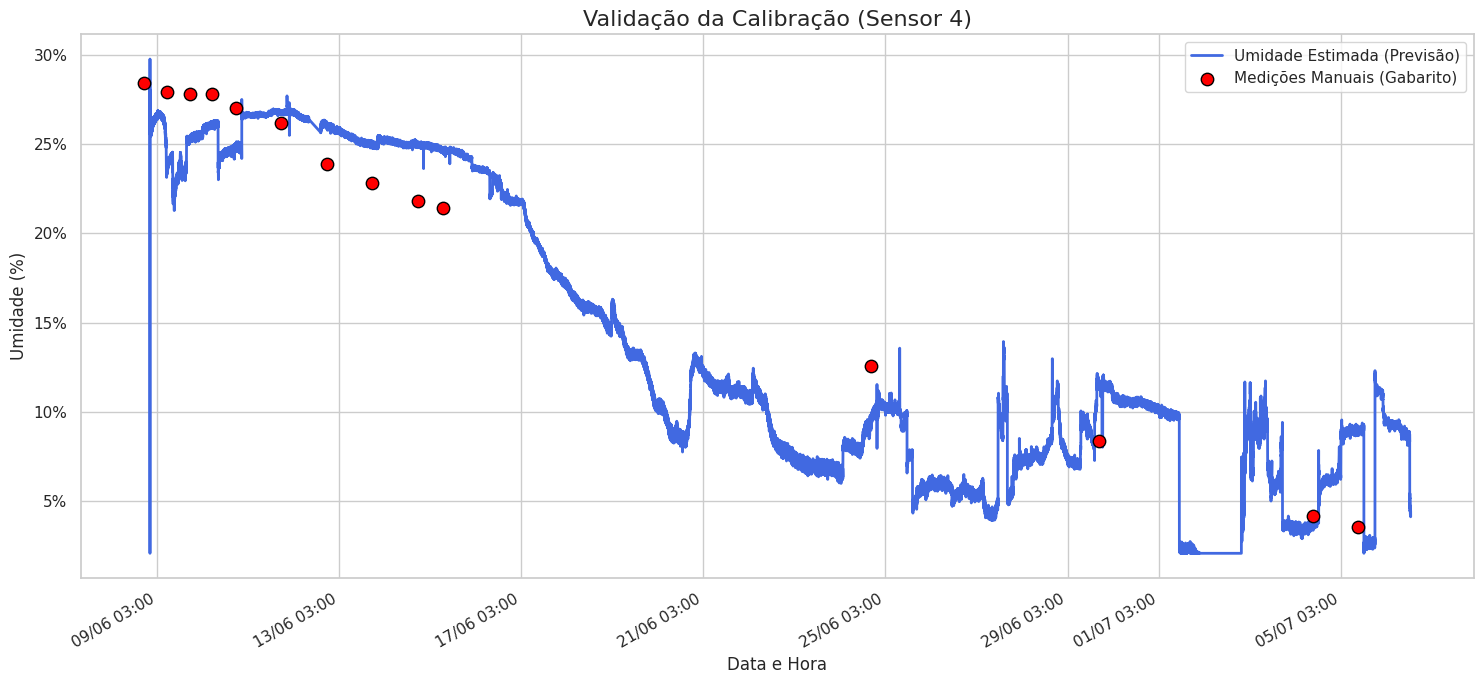


Processo completo concluído.


In [45]:
# =========================================================================
# SCRIPT FINAL (v19 - COM TABELA DE ERROS E VALIDAÇÃO COMPLETA) -> com erro absoluto
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULOS DE CARREGAMENTO E ANÁLISE
# =========================================================================

def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header)
        df_sensor.replace('', np.nan, inplace=True)
        df_sensor.dropna(subset=[df_sensor.columns[0]], inplace=True)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')
        df_processado = df_sensor.iloc[:, [0, 5, 7, -1]].copy()
        df_processado.columns = ['Ponto_Coleta', 'Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(subset=['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y'], inplace=True)
    if len(df_calibracao_sensor) < 2: print(f"ERRO: Dados insuficientes."); return None

    print(f"Analisando {len(df_calibracao_sensor)} pontos de dados válidos para {sensor_name}.")

    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values

    # Modelos e Métricas
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y); y_pred_poly = poly_reg.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly); rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly));
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]

    # --- NOVA SEÇÃO: TABELA DE COMPARAÇÃO DE ERROS ---
    print(f"\n--- Tabela de Comparação de Erros para {sensor_name} ---")
    df_comparacao = df_calibracao_sensor[['Ponto_Coleta']].copy()
    df_comparacao['Umidade_Real_Medida'] = y
    df_comparacao['Umidade_Prevista_Pelo_Modelo'] = y_pred_poly
    df_comparacao['Erro_Absoluto'] = abs(df_comparacao['Umidade_Real_Medida'] - df_comparacao['Umidade_Prevista_Pelo_Modelo'])
    print(df_comparacao.round(2).to_string(index=False))
    print("-" * 50)

    # Plotagem
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados Manuais (n={len(df_calibracao_sensor)})')
    X_plot_sorted = np.sort(X, axis=0)
    ax.plot(X_plot_sorted, poly_reg.predict(poly_features.transform(X_plot_sorted)), color='green', linestyle='-', label=f'Modelo Polinomial (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua do Sensor'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

    return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}

def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao_completos):
    print("\n\n--- FASE 2: VALIDAÇÃO VISUAL DA CALIBRAÇÃO ---")
    for sensor_name, eq in equacoes.items():
        print(f"\n==================== GRÁFICO DE VALIDAÇÃO: {sensor_name} ====================")
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter(leitura, equacao=eq):
            x = float(leitura)
            umidade = (equacao['a']*x*x) + (equacao['b']*x) + equacao['c']
            return max(0, min(100, umidade))
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter)
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df_sensor_ts['timestamp'], df_sensor_ts['Umidade_Estimada'], label='Umidade Estimada (Previsão)', color='royalblue', lw=2, zorder=2)
        df_calibracao_sensor = dados_calibracao_completos[sensor_name].dropna(subset=['timestamp', 'Umidade_Gravimetrica_Y'])
        ax.scatter(df_calibracao_sensor['timestamp'], df_calibracao_sensor['Umidade_Gravimetrica_Y'], color='red', s=80, ec='black', zorder=5, label='Medições Manuais (Gabarito)')
        ax.set_title(f'Validação da Calibração ({sensor_name})', fontsize=16); ax.set_xlabel('Data e Hora'); ax.set_ylabel('Umidade (%)')
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format)); ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
        plt.xticks(rotation=30, ha='right'); ax.legend(); plt.tight_layout()
        plt.savefig(f'validacao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

def main():
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados_finais = {}
    if dados_calibracao:
        for sensor, df_dados in dados_calibracao.items():
            modelo = analisar_calibracao(df_dados, sensor)
            if modelo: resultados_finais[sensor] = modelo
    if resultados_finais:
        print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
        df_equacoes = pd.DataFrame(resultados_finais).T
        df_equacoes.index.name = "Sensor"; colunas_ordenadas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'c']
        df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')
        df_equacoes.to_csv('equacoes_de_calibracao.csv')
        print("✅ Equações salvas com sucesso no arquivo 'equacoes_de_calibracao.csv'")
        print("\nMelhor equação encontrada para cada sensor:")
        print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format}))
        print("="*75)
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty and resultados_finais:
        aplicar_e_visualizar(dados_crus, resultados_finais, dados_calibracao)

    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 14 pontos válidos para Sensor 1.
--- Estatísticas Descritivas ---
      Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
n                  14.00                   14.00
mean             2356.50                   14.80
std               821.31                    8.03
min              1700.00                    0.00
25%              1730.25                    9.55
50%              2012.50                   17.42
75%              2783.25                   20.83
max              4050.00                   22.23
--------------------------------------------------

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


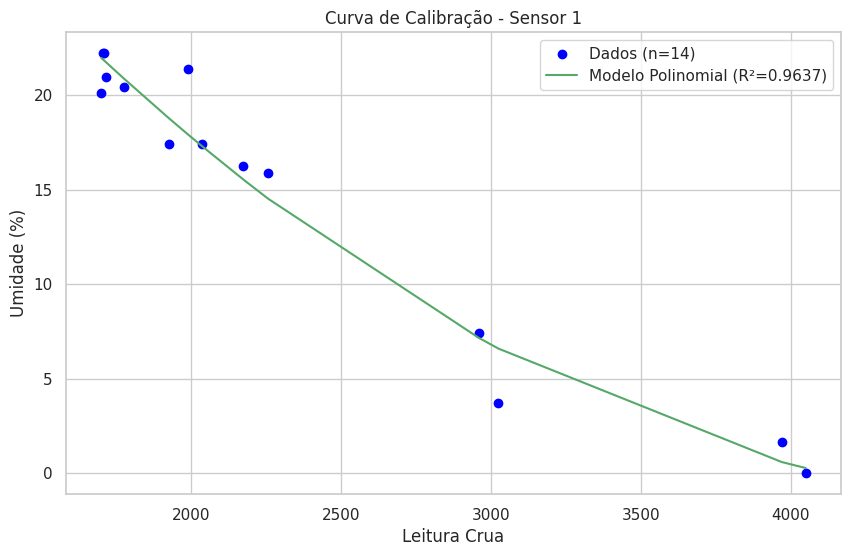

Analisando 14 pontos válidos para Sensor 2.
--- Estatísticas Descritivas ---
      Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
n                  14.00                   14.00
mean             2626.07                   24.34
std               788.63                    8.97
min              1826.00                    7.69
25%              2144.75                   19.24
50%              2233.50                   27.70
75%              3368.00                   31.28
max              3991.00                   31.88
--------------------------------------------------

==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


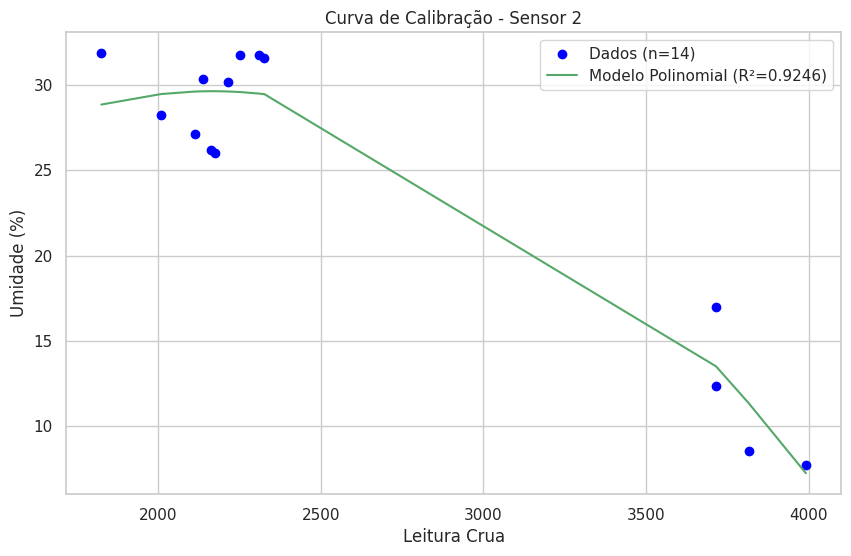

Analisando 14 pontos válidos para Sensor 3.
--- Estatísticas Descritivas ---
      Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
n                  14.00                   14.00
mean             2351.14                   18.53
std               850.07                    9.19
min              1390.00                    2.43
25%              1859.50                   12.66
50%              1967.50                   21.53
75%              2903.00                   25.90
max              3967.00                   27.12
--------------------------------------------------

==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


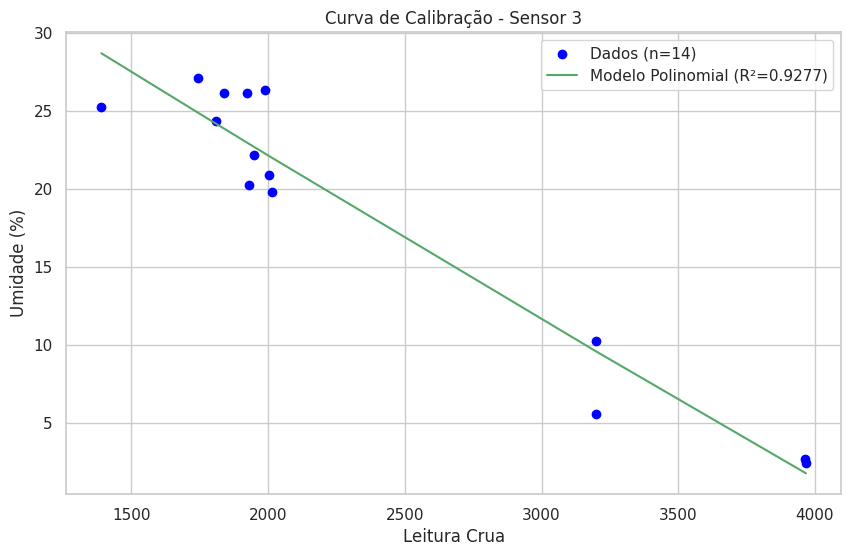

Analisando 14 pontos válidos para Sensor 4.
--- Estatísticas Descritivas ---
      Leitura_Sensor_Cru  Umidade_Gravimetrica_Y
n                  14.00                   14.00
mean             2412.14                   20.27
std               875.95                    9.10
min              1511.00                    3.60
25%              1849.75                   14.80
50%              1992.00                   23.35
75%              3129.00                   27.60
max              3960.00                   28.40
--------------------------------------------------

==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


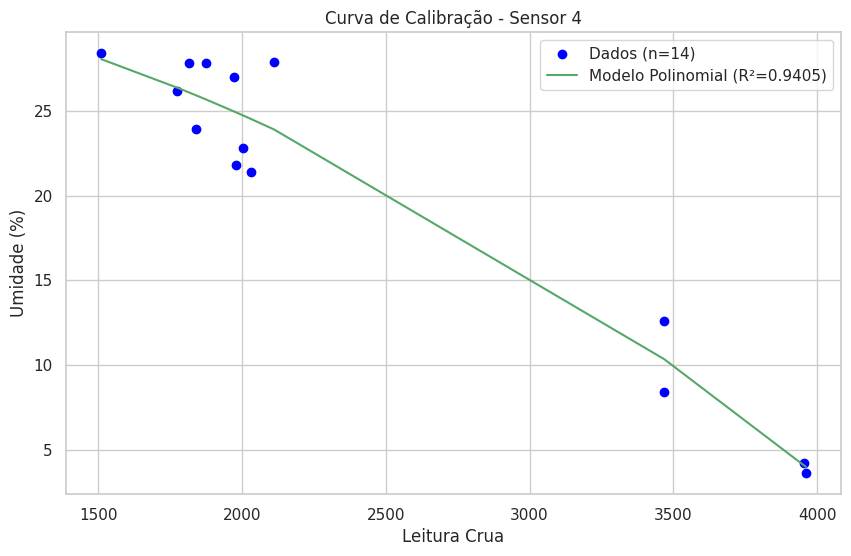



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas

Melhor equação encontrada:
                tipo     R2  RMSE             a         b          c
Sensor                                                              
Sensor 1  Polinomial 0.9637 1.47%  2.318573e-06 -0.022572  53.659372
Sensor 2  Polinomial 0.9246 2.37% -6.743017e-06  0.029223  -2.011071
Sensor 3  Polinomial 0.9277 2.38%  1.482209e-07 -0.011230  44.012845
Sensor 4  Polinomial 0.9405 2.14% -1.578079e-06 -0.001196  33.463596

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-42-4220782534.py:154: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')


Normalizando fuso horário dos dados crus...


--- FASE 2: VALIDAÇÃO VISUAL DA CALIBRAÇÃO ---

==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 1 ====================


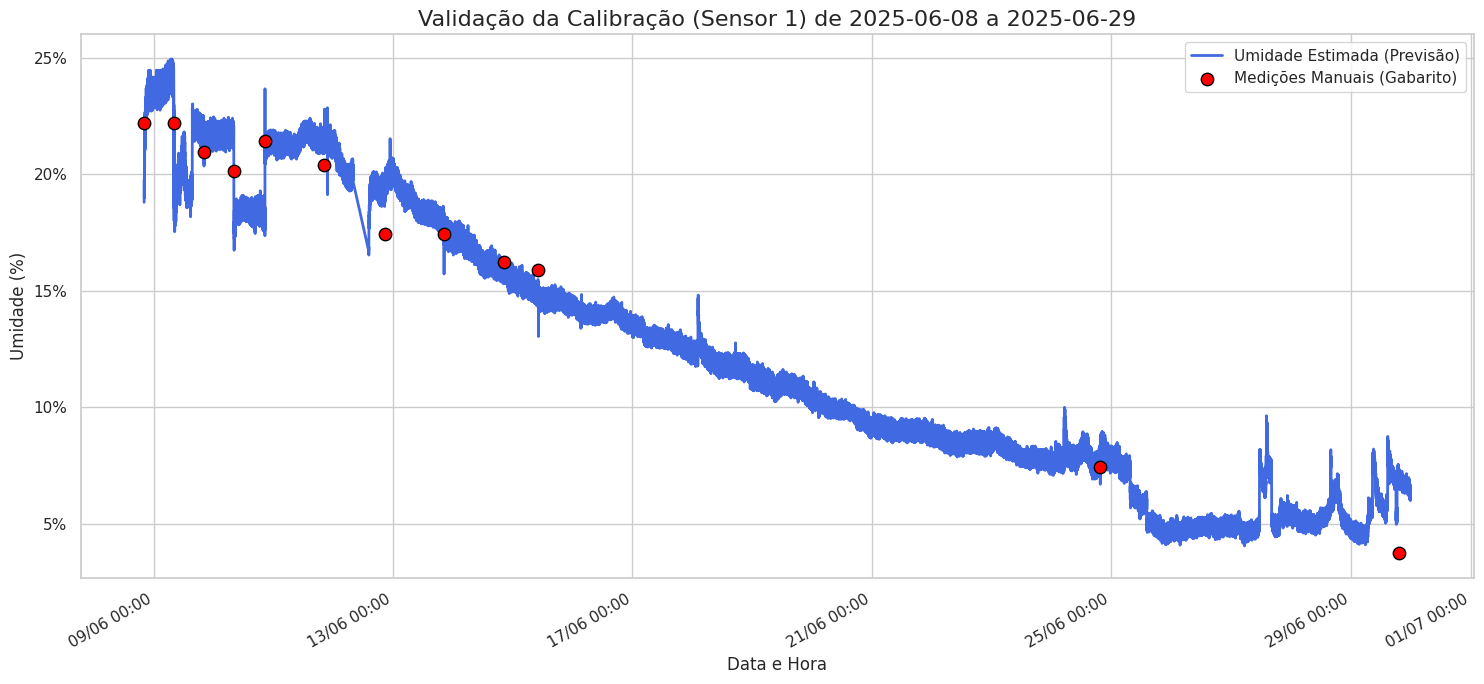


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 2 ====================


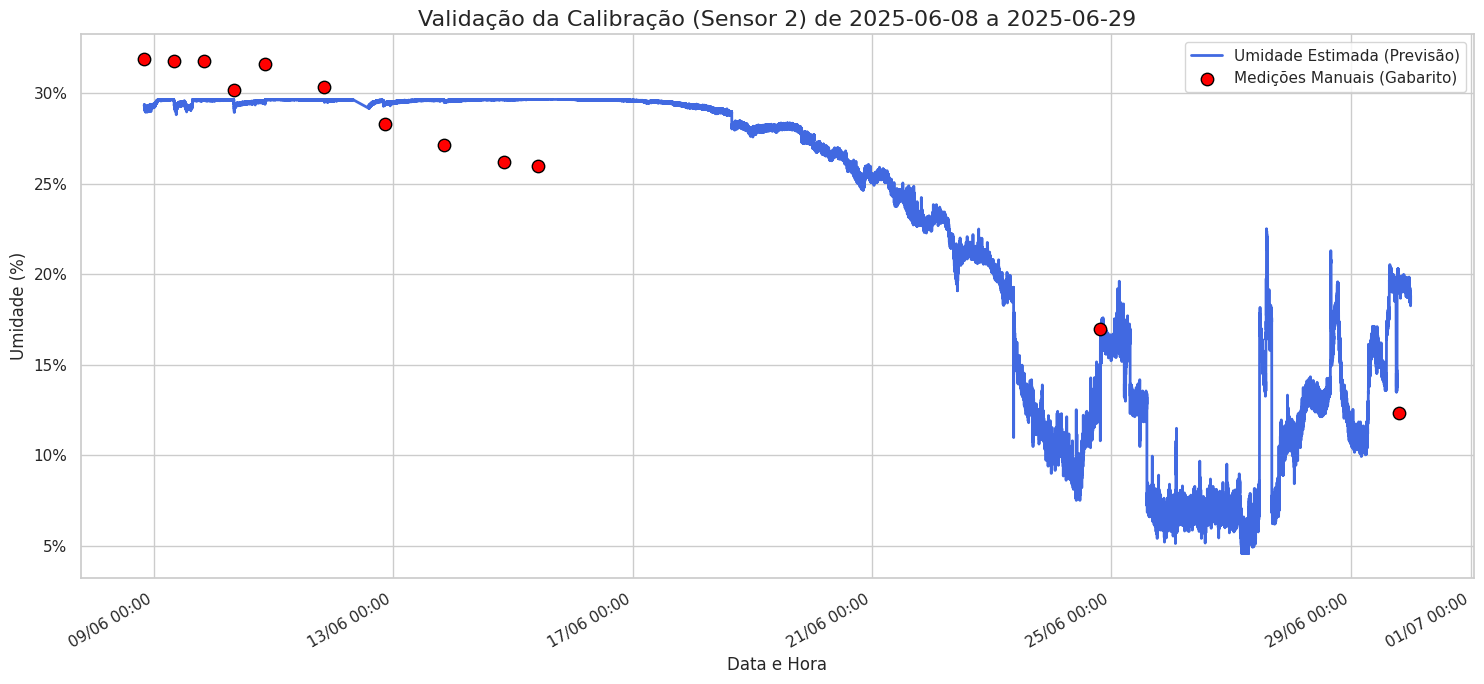


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 3 ====================


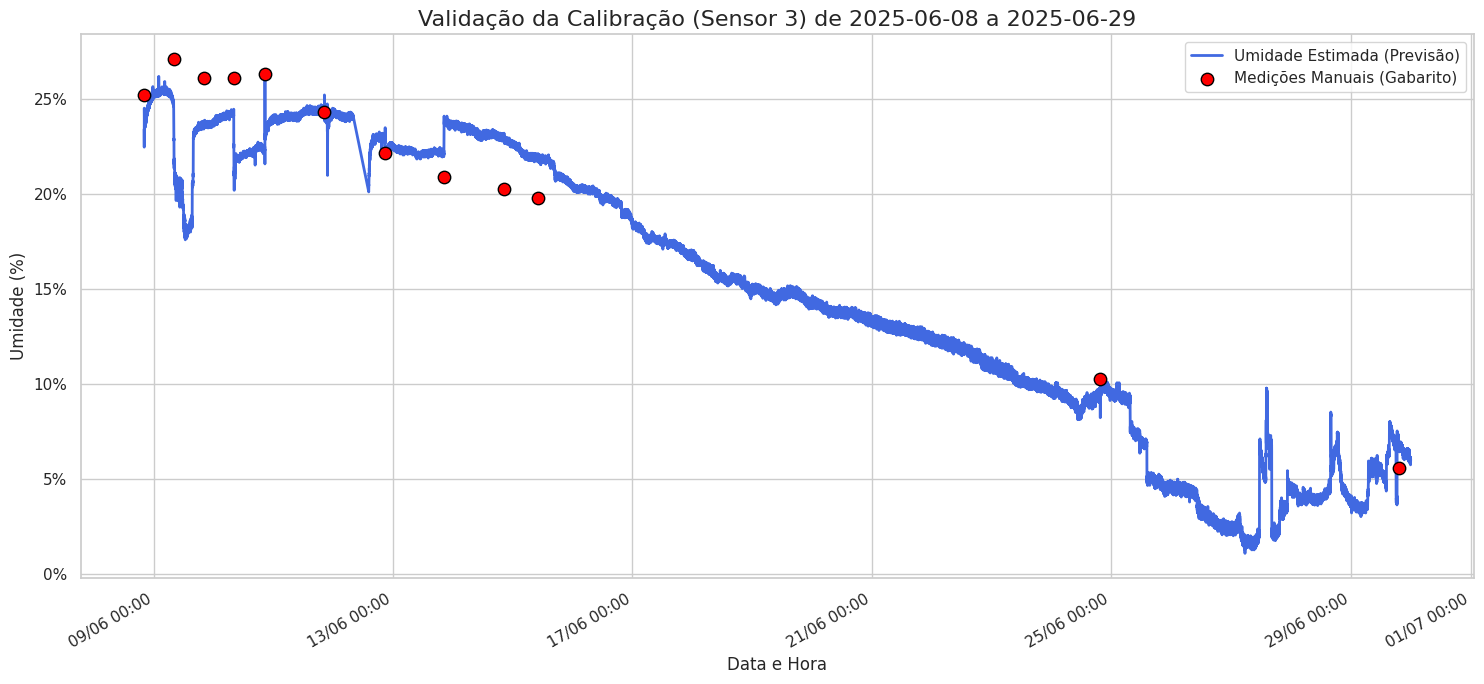


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 4 ====================


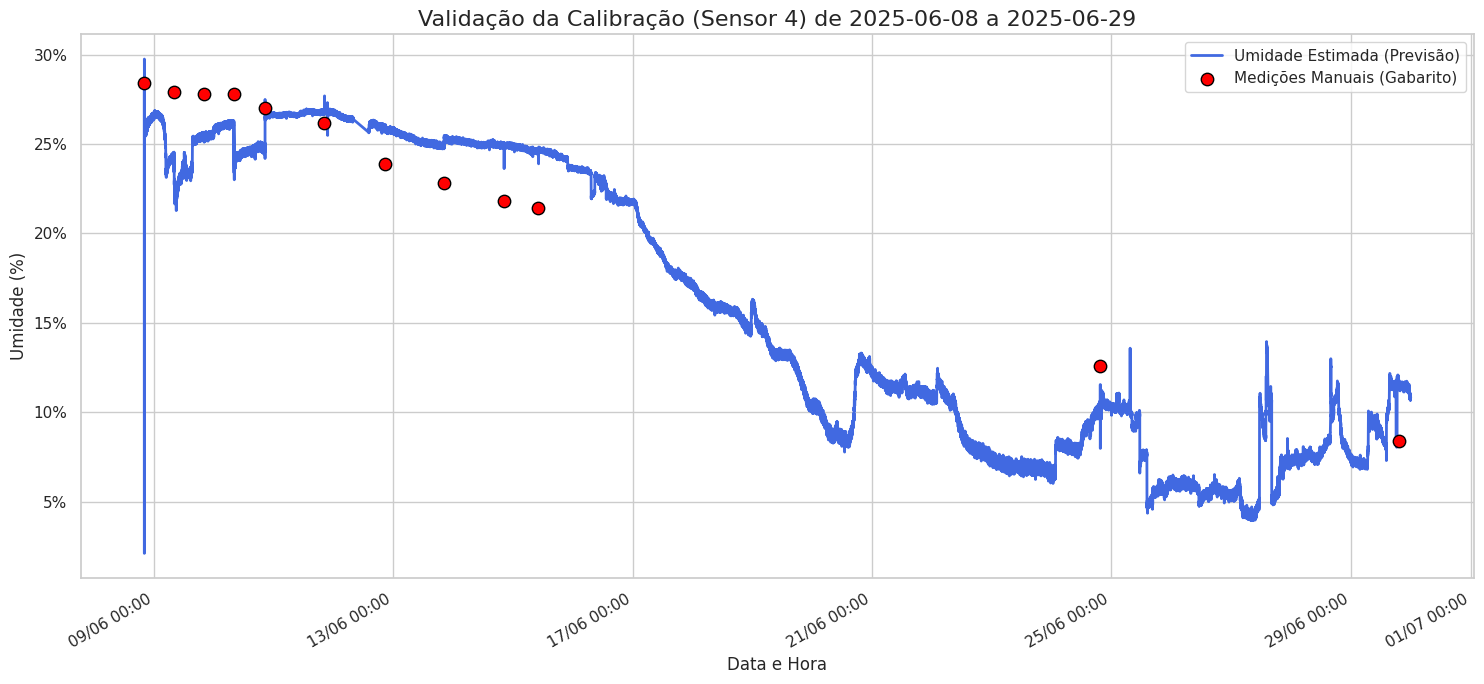


Processo completo concluído.


In [42]:
# =========================================================================
# SCRIPT FINAL (v22 - CORREÇÃO DE FUSO HORÁRIO)
# Padroniza todas as datas para evitar erros de comparação.
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- CONFIGURAÇÃO DO PERÍODO DE VISUALIZAÇÃO ---
DATA_INICIO_PLOT = "2025-06-08"
DATA_FIM_PLOT = "2025-06-29"

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULO 1: CARREGAMENTO DE DADOS
# =========================================================================
def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header); df_sensor.replace('', np.nan, inplace=True)
        df_sensor.dropna(subset=[df_sensor.columns[0]], inplace=True)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        # Cria o timestamp já como 'naive'
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')
        df_processado = df_sensor.iloc[:, [5, 7, -1]].copy()
        df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')

    # --- CORREÇÃO DE FUSO HORÁRIO APLICADA AQUI ---
    # Remove a informação de fuso horário para tornar a coluna 'naive'
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        print("Normalizando fuso horário dos dados crus...")
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)

    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

# =========================================================================
# MÓDULO 2: ANÁLISE DE CALIBRAÇÃO
# =========================================================================
def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(inplace=True)
    print(f"Analisando {len(df_calibracao_sensor)} pontos válidos para {sensor_name}.")
    if len(df_calibracao_sensor) < 2: print(f"ERRO: Dados insuficientes."); return None
    print(f"--- Estatísticas Descritivas ---"); print(df_calibracao_sensor[['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y']].describe().rename(index={'count':'n'}).round(2).to_string()); print("-" * 50)
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y); y_pred_poly = poly_reg.predict(X_poly)
    r2_poly = r2_score(y, y_pred_poly); rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly));
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados (n={len(df_calibracao_sensor)})')
    X_plot_sorted = np.sort(X, axis=0); ax.plot(X_plot_sorted, poly_reg.predict(poly_features.transform(X_plot_sorted)), 'g-', label=f'Modelo Polinomial (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()
    return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}

# =========================================================================
# MÓDULO 3: APLICAÇÃO E VISUALIZAÇÃO
# =========================================================================
def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao, data_inicio, data_fim):
    print("\n\n--- FASE 2: VALIDAÇÃO VISUAL DA CALIBRAÇÃO ---")
    for sensor_name, eq in equacoes.items():
        print(f"\n==================== SÉRIE TEMPORAL E VALIDAÇÃO: {sensor_name} ====================")
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter(leitura, equacao=eq):
            x = float(leitura)
            umidade = (equacao['a']*x*x) + (equacao['b']*x) + equacao['c']
            return max(0, min(100, umidade))
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter)

        inicio_filtro = pd.to_datetime(data_inicio)
        fim_filtro = pd.to_datetime(data_fim).replace(hour=23, minute=59, second=59)
        filtro_periodo = (df_sensor_ts['timestamp'] >= inicio_filtro) & (df_sensor_ts['timestamp'] <= fim_filtro)
        df_plot_final = df_sensor_ts[filtro_periodo]

        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df_plot_final['timestamp'], df_plot_final['Umidade_Estimada'], label='Umidade Estimada (Previsão)', color='royalblue', lw=2, zorder=2)

        df_calibracao_sensor = dados_calibracao[sensor_name].dropna(subset=['timestamp', 'Umidade_Gravimetrica_Y'])
        df_calibracao_sensor['timestamp'] = df_calibracao_sensor['timestamp'].dt.tz_localize(None) # Garante que é naive
        filtro_calibracao = (df_calibracao_sensor['timestamp'] >= inicio_filtro) & (df_calibracao_sensor['timestamp'] <= fim_filtro)
        ax.scatter(df_calibracao_sensor[filtro_calibracao]['timestamp'], df_calibracao_sensor[filtro_calibracao]['Umidade_Gravimetrica_Y'], color='red', s=80, ec='black', zorder=5, label='Medições Manuais (Gabarito)')

        ax.set_title(f'Validação da Calibração ({sensor_name}) de {data_inicio} a {data_fim}', fontsize=16)
        ax.set_xlabel('Data e Hora'); ax.set_ylabel('Umidade (%)'); ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M')); plt.xticks(rotation=30, ha='right'); ax.legend(); ax.grid(True); plt.tight_layout()
        plt.savefig(f'validacao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

# =========================================================================
# ORQUESTRADOR PRINCIPAL (main)
# =========================================================================
def main():
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados_finais = {}
    if dados_calibracao:
        for sensor, df_dados in dados_calibracao.items():
            modelo = analisar_calibracao(df_dados, sensor)
            if modelo: resultados_finais[sensor] = modelo
    if resultados_finais:
        print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
        df_equacoes = pd.DataFrame(resultados_finais).T; df_equacoes.index.name = "Sensor"; colunas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'c']
        df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')
        df_equacoes.to_csv('equacoes_de_calibracao.csv')
        print("✅ Equações salvas"); print("\nMelhor equação encontrada:"); print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format})); print("="*75)

    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty and resultados_finais:
        aplicar_e_visualizar(dados_crus, resultados_finais, dados_calibracao, DATA_INICIO_PLOT, DATA_FIM_PLOT)
    else:
        print("\nAVISO: Fase 2 pulada.")

    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

# Analise (gemini)

✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 14 pontos válidos para Sensor 1.

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


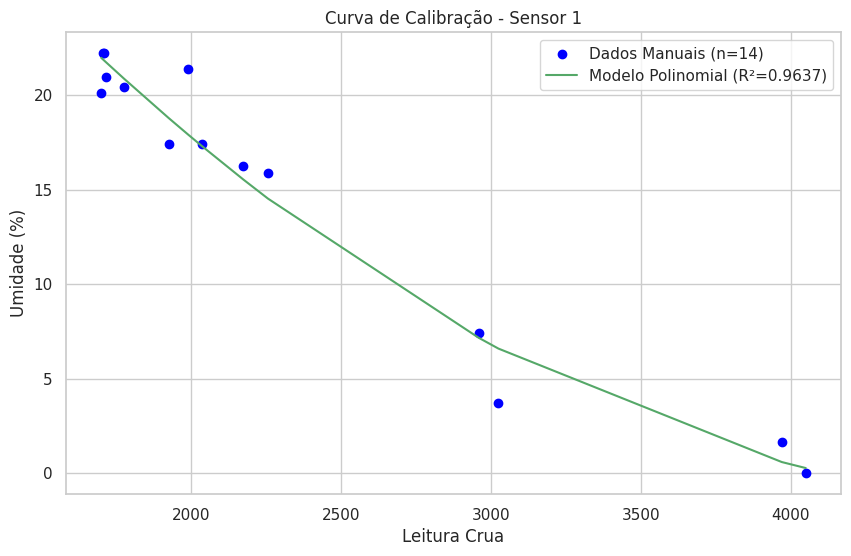

Analisando 14 pontos válidos para Sensor 2.

==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


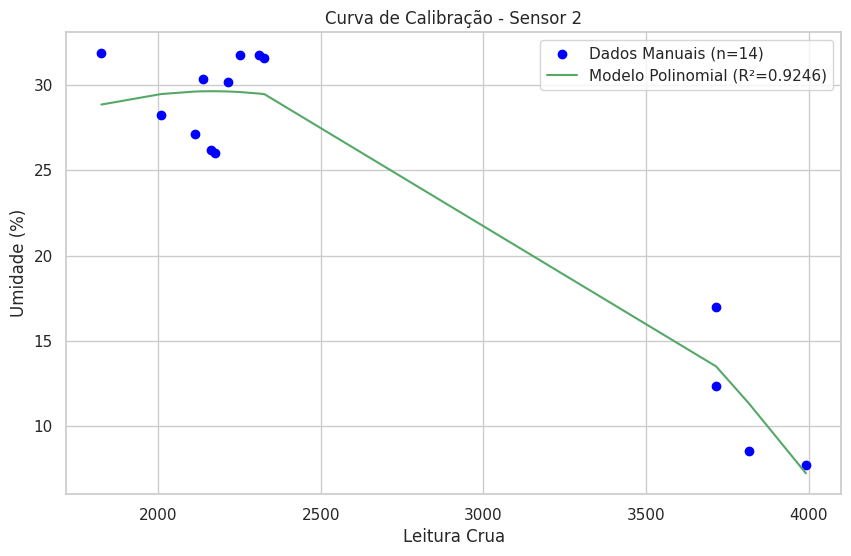

Analisando 14 pontos válidos para Sensor 3.

==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


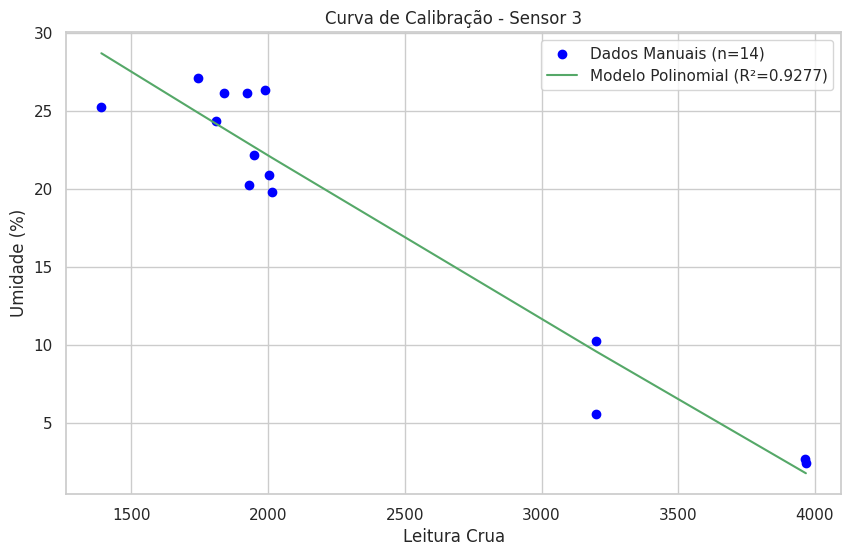

Analisando 14 pontos válidos para Sensor 4.

==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


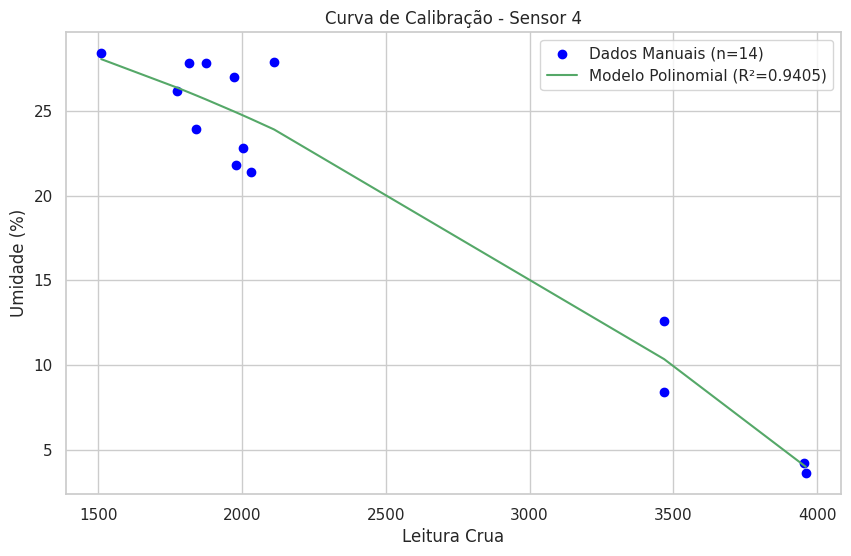



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas

Melhor equação encontrada:
                tipo     R2  RMSE             a         b          c
Sensor                                                              
Sensor 1  Polinomial 0.9637 1.47%  2.318573e-06 -0.022572  53.659372
Sensor 2  Polinomial 0.9246 2.37% -6.743017e-06  0.029223  -2.011071
Sensor 3  Polinomial 0.9277 2.38%  1.482209e-07 -0.011230  44.012845
Sensor 4  Polinomial 0.9405 2.14% -1.578079e-06 -0.001196  33.463596

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-43-1669407220.py:155: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')




--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---

==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 1 ====================

--- Tabela de Erro de Validação (Gabarito vs. Previsão) ---
Ponto de Coleta Umidade Real (Gabarito) Umidade Prevista (Modelo) Erro Absoluto (%)
         1 (CC)                  22.23%                    18.80%             3.43%
              2                  22.23%                    22.71%             0.48%
              3                  20.96%                    21.04%             0.08%
              4                  20.15%                    19.35%             0.80%
              5                  21.42%                    18.07%             3.35%
              6                  20.42%                    21.65%             1.23%
              7                  17.42%                    19.30%             1.88%
              8                  17.42%                    17.59%             0.17%
              9                  16.24%          

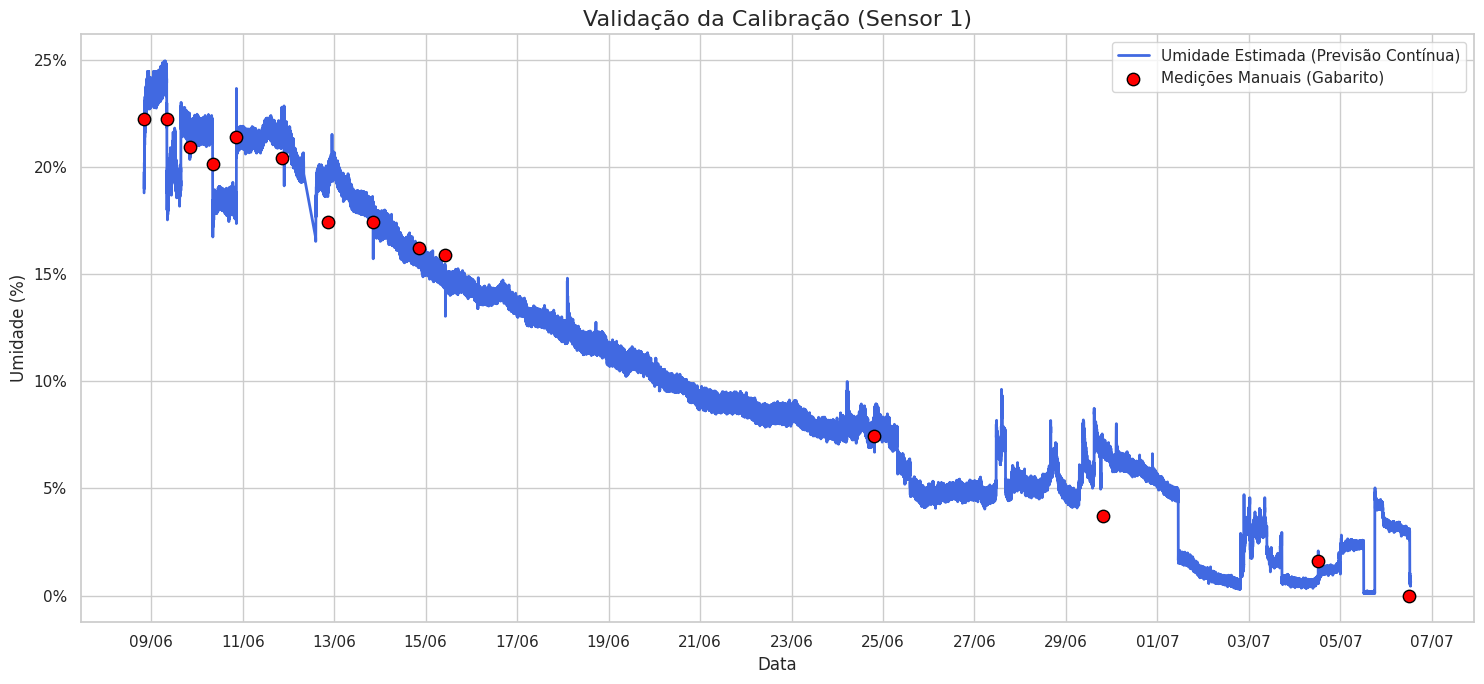


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 2 ====================

--- Tabela de Erro de Validação (Gabarito vs. Previsão) ---
Ponto de Coleta Umidade Real (Gabarito) Umidade Prevista (Modelo) Erro Absoluto (%)
         1 (CC)                  31.88%                    29.29%             2.59%
              2                  31.78%                    29.60%             2.18%
              3                  31.78%                    29.61%             2.17%
              4                  30.17%                    29.35%             0.82%
              5                  31.59%                    29.55%             2.04%
              6                  30.36%                    29.63%             0.73%
              7                  28.27%                    29.45%             1.18%
              8                  27.13%                    29.63%             2.50%
              9                  26.19%                    29.65%             3.46%
             10    

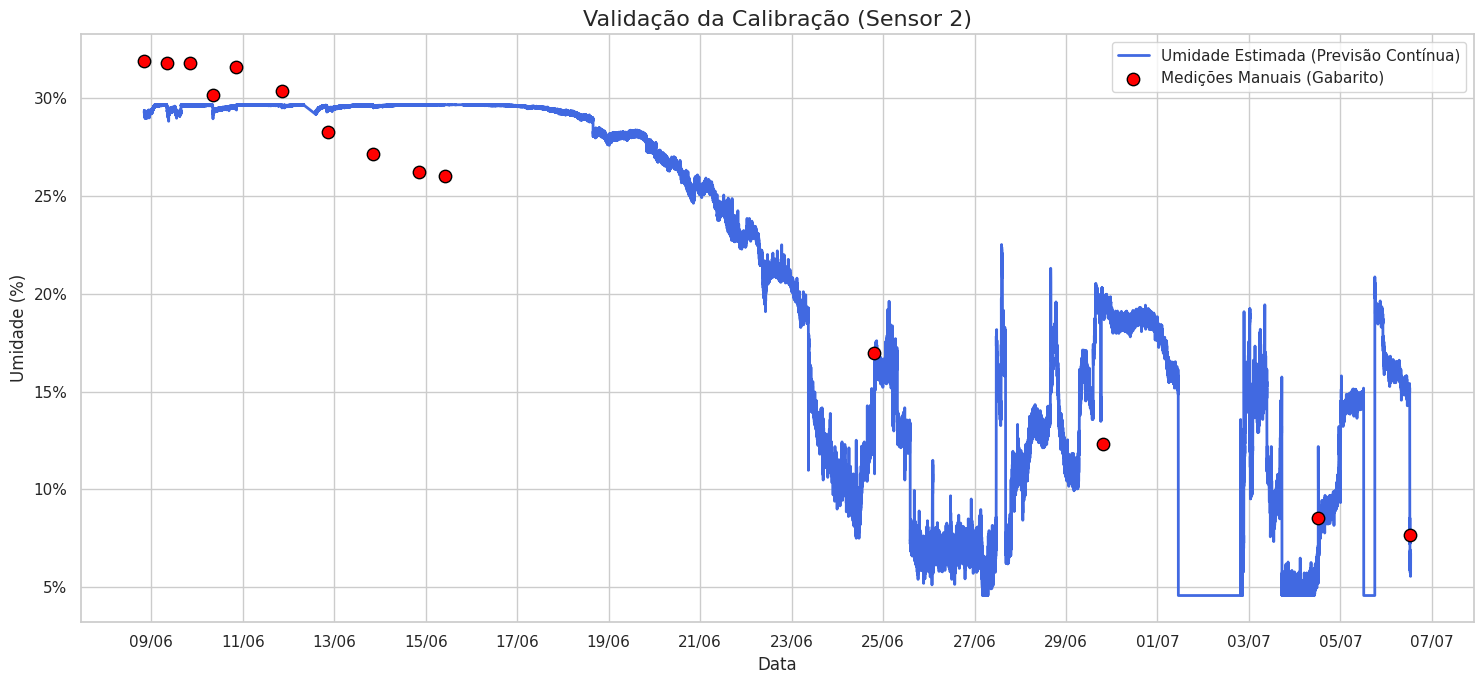


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 3 ====================

--- Tabela de Erro de Validação (Gabarito vs. Previsão) ---
Ponto de Coleta Umidade Real (Gabarito) Umidade Prevista (Modelo) Erro Absoluto (%)
         1 (CC)                  25.23%                    23.42%             1.81%
              2                  27.12%                    22.94%             4.18%
              3                  26.13%                    23.64%             2.49%
              4                  26.13%                    22.46%             3.67%
              5                  26.31%                    22.53%             3.78%
              6                  24.32%                    24.53%             0.21%
              7                  22.16%                    23.00%             0.84%
              8                  20.90%                    22.11%             1.21%
              9                  20.27%                    23.02%             2.75%
             10    

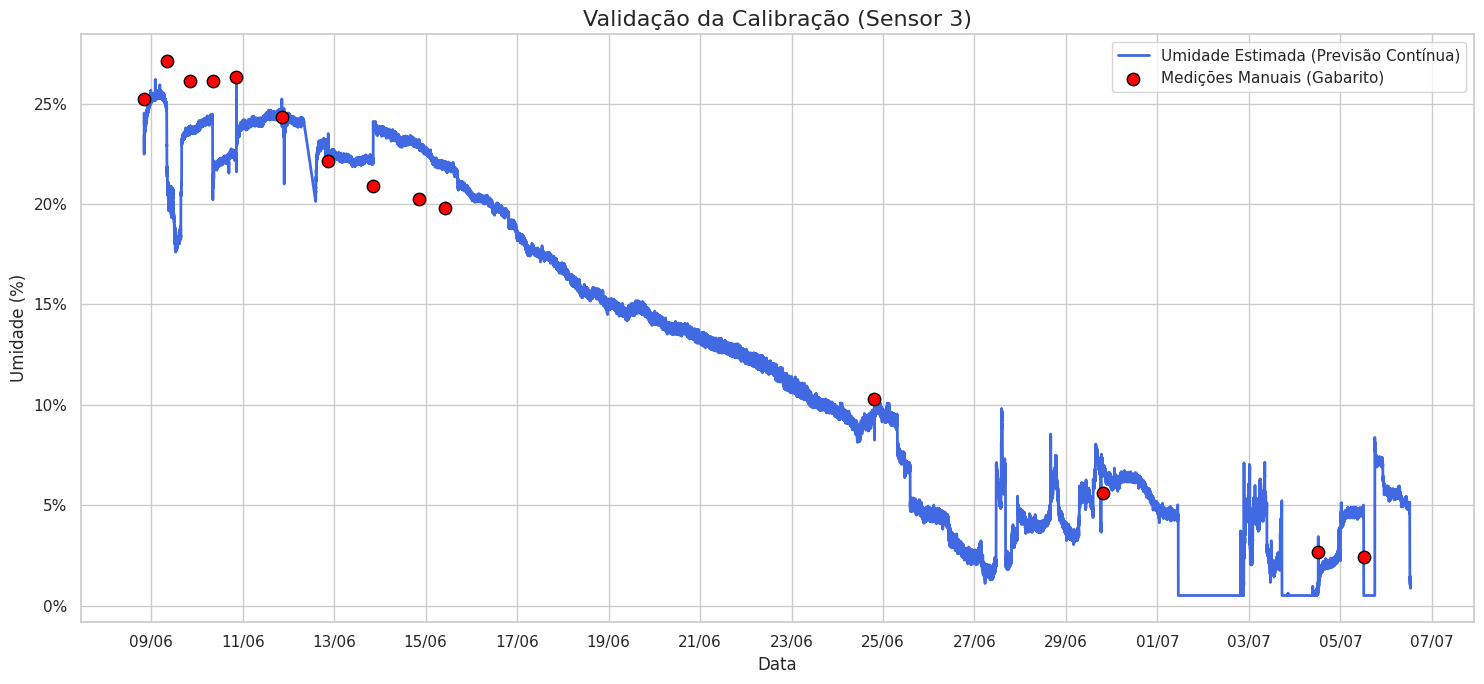


==================== SÉRIE TEMPORAL E VALIDAÇÃO: Sensor 4 ====================

--- Tabela de Erro de Validação (Gabarito vs. Previsão) ---
Ponto de Coleta Umidade Real (Gabarito) Umidade Prevista (Modelo) Erro Absoluto (%)
         1 (CC)                  28.40%                    28.05%             0.35%
              2                  27.90%                    23.56%             4.34%
              3                  27.80%                    25.39%             2.41%
              4                  27.80%                    25.00%             2.80%
              5                  27.00%                    24.95%             2.05%
              6                  26.20%                    26.79%             0.59%
              7                  23.90%                    25.81%             1.91%
              8                  22.80%                    24.89%             2.09%
              9                  21.80%                    25.00%             3.20%
             10    

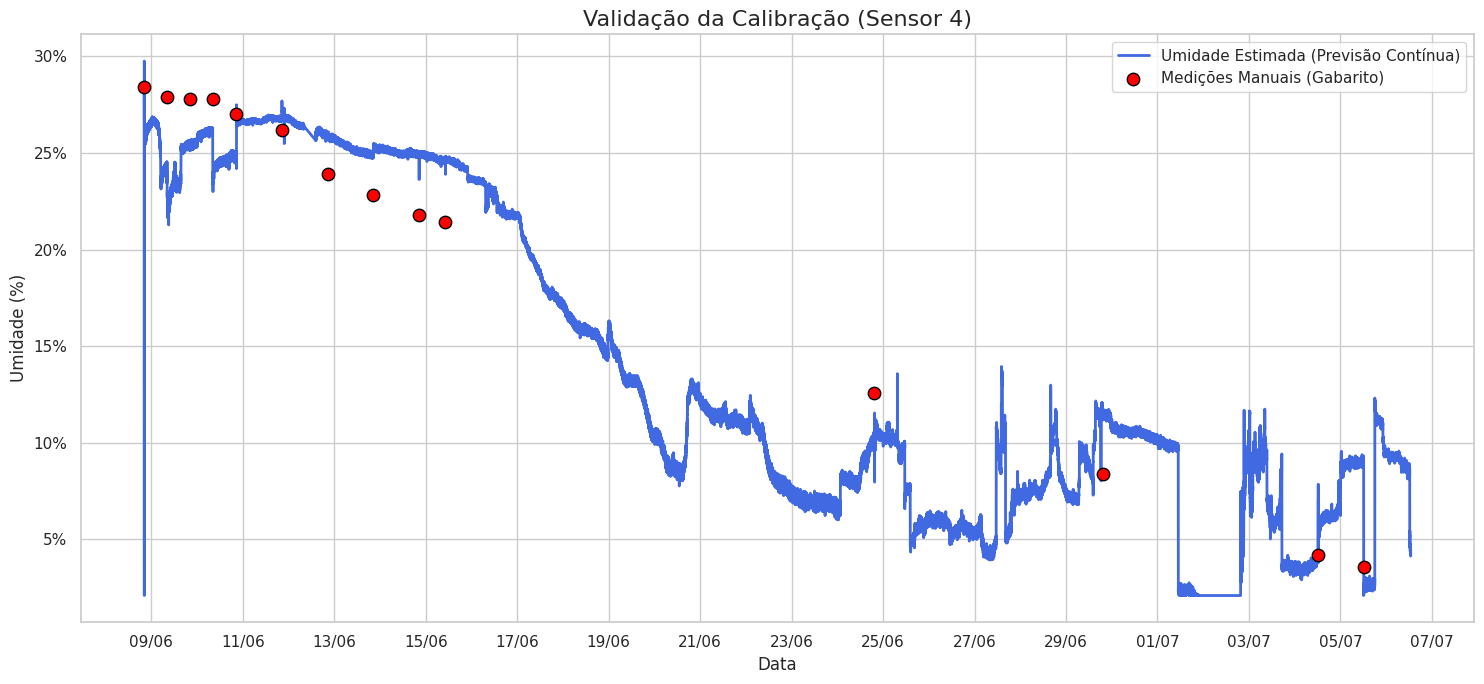


Processo completo concluído.


In [43]:
# =========================================================================
# SCRIPT FINAL (VERSÃO DE APRESENTAÇÃO PARA TCC)
# Adiciona tabela de erro de validação e simplifica o eixo de data.
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULOS DE CARREGAMENTO E ANÁLISE
# =========================================================================

def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header)
        df_sensor.replace('', np.nan, inplace=True)
        df_sensor.dropna(subset=[df_sensor.columns[0]], inplace=True)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')
        df_processado = df_sensor.iloc[:, [0, 5, 7, -1]].copy() # Adiciona a coluna Ponto_Coleta
        df_processado.columns = ['Ponto_Coleta', 'Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(inplace=True)
    print(f"Analisando {len(df_calibracao_sensor)} pontos válidos para {sensor_name}.")
    if len(df_calibracao_sensor) < 2: print("ERRO: Dados insuficientes."); return None
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y)
    r2_poly = r2_score(y, poly_reg.predict(X_poly)); rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)))
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados Manuais (n={len(df_calibracao_sensor)})')
    X_plot_sorted = np.sort(X, axis=0); ax.plot(X_plot_sorted, poly_reg.predict(poly_features.transform(X_plot_sorted)), 'g-', label=f'Modelo Polinomial (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()
    return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}

def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao_completos):
    print("\n\n--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---")
    for sensor_name, eq in equacoes.items():
        print(f"\n==================== SÉRIE TEMPORAL E VALIDAÇÃO: {sensor_name} ====================")
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter(leitura, equacao=eq):
            x = float(leitura)
            umidade = (equacao['a']*x*x) + (equacao['b']*x) + equacao['c']
            return max(0, min(100, umidade))
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter)

        # --- NOVA SEÇÃO: CRIAÇÃO DA TABELA DE ERRO DE VALIDAÇÃO ---
        df_calibracao_sensor = dados_calibracao_completos[sensor_name].copy()
        df_calibracao_sensor.dropna(subset=['timestamp'], inplace=True)
        # Sincroniza os pontos manuais com a curva de previsão contínua
        df_validacao = pd.merge_asof(
            left=df_calibracao_sensor.sort_values('timestamp'),
            right=df_sensor_ts.sort_values('timestamp'),
            on='timestamp',
            direction='nearest',
            tolerance=pd.Timedelta('15 minutes')
        )
        df_validacao.dropna(inplace=True)
        if not df_validacao.empty:
            df_validacao['Erro_Absoluto'] = abs(df_validacao['Umidade_Gravimetrica_Y'] - df_validacao['Umidade_Estimada'])
            print("\n--- Tabela de Erro de Validação (Gabarito vs. Previsão) ---")
            tabela_final = df_validacao[['Ponto_Coleta', 'Umidade_Gravimetrica_Y', 'Umidade_Estimada', 'Erro_Absoluto']]
            tabela_final.columns = ['Ponto de Coleta', 'Umidade Real (Gabarito)', 'Umidade Prevista (Modelo)', 'Erro Absoluto (%)']
            print(tabela_final.to_string(index=False, formatters={
                'Umidade Real (Gabarito)': '{:,.2f}%'.format,
                'Umidade Prevista (Modelo)': '{:,.2f}%'.format,
                'Erro Absoluto (%)': '{:,.2f}%'.format
            }))
            print("-" * 80)

        # Plotagem
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df_sensor_ts['timestamp'], df_sensor_ts['Umidade_Estimada'], label='Umidade Estimada (Previsão Contínua)', color='royalblue', lw=2, zorder=2)
        ax.scatter(df_calibracao_sensor['timestamp'], df_calibracao_sensor['Umidade_Gravimetrica_Y'], color='red', s=80, ec='black', zorder=5, label='Medições Manuais (Gabarito)')
        ax.set_title(f'Validação da Calibração ({sensor_name})', fontsize=16)
        ax.set_xlabel('Data', fontsize=12); ax.set_ylabel('Umidade (%)', fontsize=12)
        ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
        # MODIFICAÇÃO: Formatação do eixo de data para mostrar apenas Dia/Mês
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Mostra um marcador a cada 2 dias
        plt.xticks(rotation=0, ha='center'); ax.legend(); plt.tight_layout()
        plt.savefig(f'validacao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

def main():
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados_finais = {}
    if dados_calibracao:
        for sensor, df_dados in dados_calibracao.items():
            modelo = analisar_calibracao(df_dados, sensor)
            if modelo: resultados_finais[sensor] = modelo
    if resultados_finais:
        print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
        df_equacoes = pd.DataFrame(resultados_finais).T; df_equacoes.index.name = "Sensor"; colunas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'c']
        df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')
        df_equacoes.to_csv('equacoes_de_calibracao.csv')
        print("✅ Equações salvas"); print("\nMelhor equação encontrada:"); print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format})); print("="*75)
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty and resultados_finais:
        aplicar_e_visualizar(dados_crus, resultados_finais, dados_calibracao)
    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco para 'Sensor 1'...
Processando bloco para 'Sensor 2'...
Processando bloco para 'Sensor 3'...
Processando bloco para 'Sensor 4'...
Analisando 14 pontos válidos para Sensor 1.

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


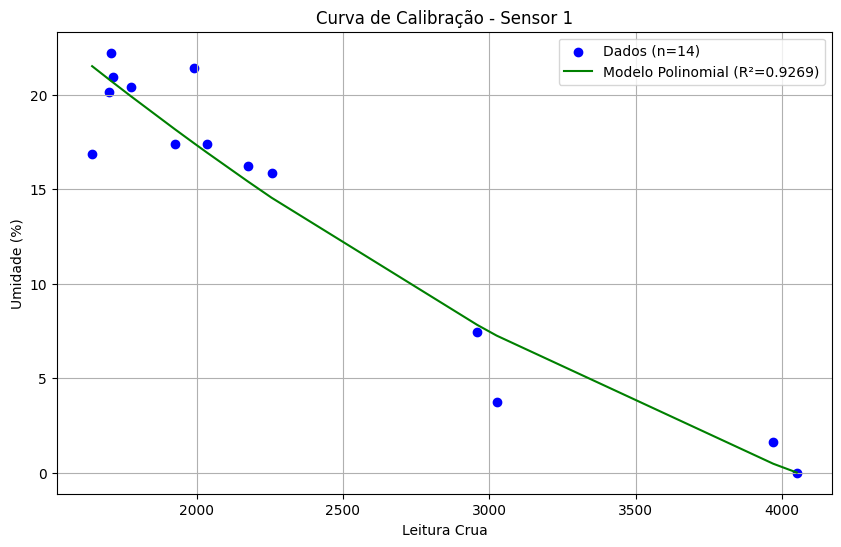

Analisando 14 pontos válidos para Sensor 2.

==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


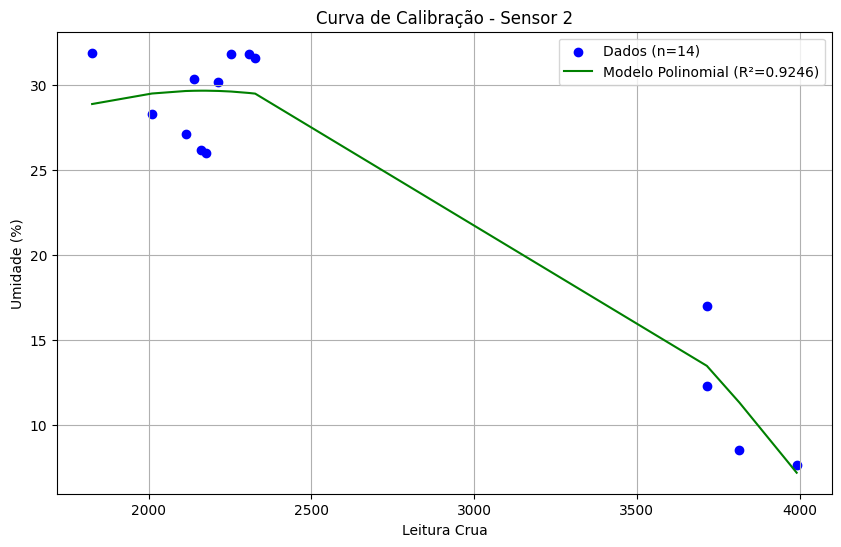

Analisando 14 pontos válidos para Sensor 3.

==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


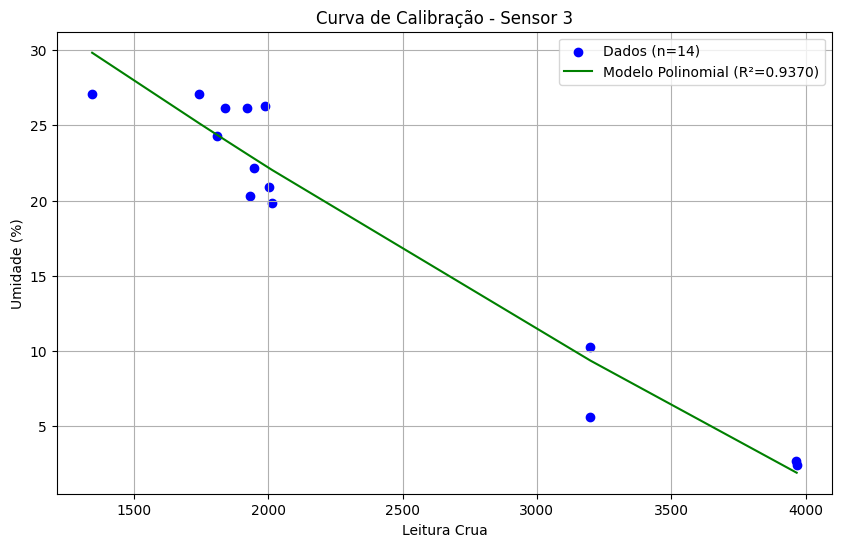

Analisando 14 pontos válidos para Sensor 4.

==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


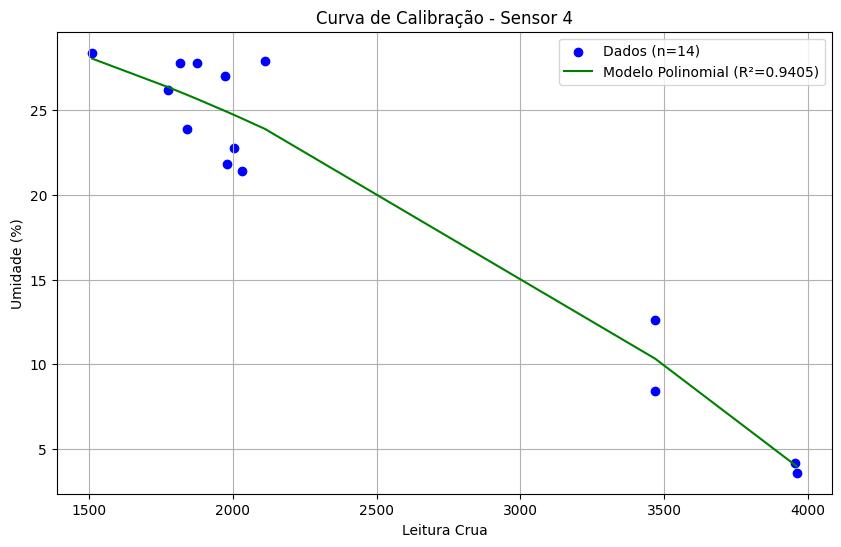



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas

Melhor equação encontrada:
                tipo     R2  RMSE             a         b          c
Sensor                                                              
Sensor 1  Polinomial 0.9269 2.03%  1.350400e-06 -0.016623  45.183842
Sensor 2  Polinomial 0.9246 2.37% -6.743017e-06  0.029223  -2.011071
Sensor 3  Polinomial 0.9370 2.25%  5.058557e-07 -0.013336  46.842666
Sensor 4  Polinomial 0.9405 2.14% -1.578079e-06 -0.001196  33.463596

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-12-4180650182.py:147: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')


Normalizando fuso horário dos dados crus...


--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---

==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 1 ====================


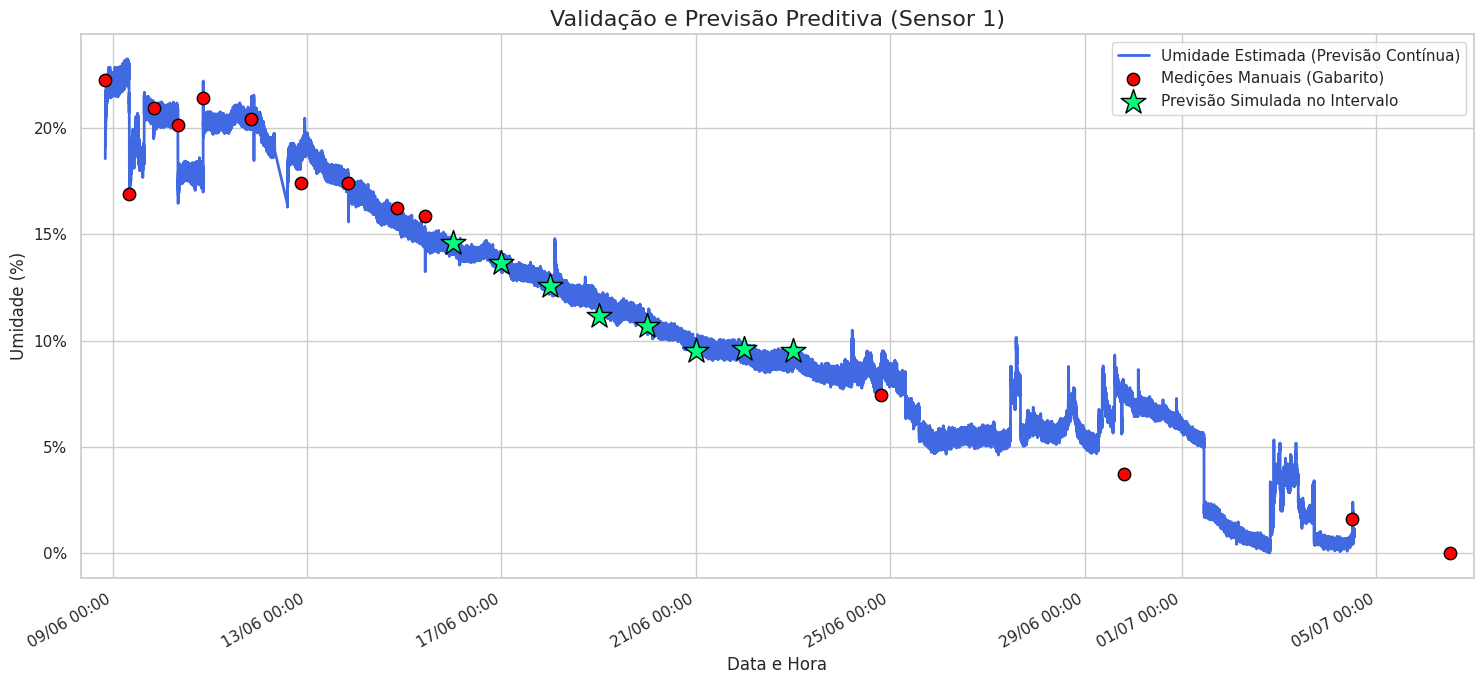


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 2 ====================


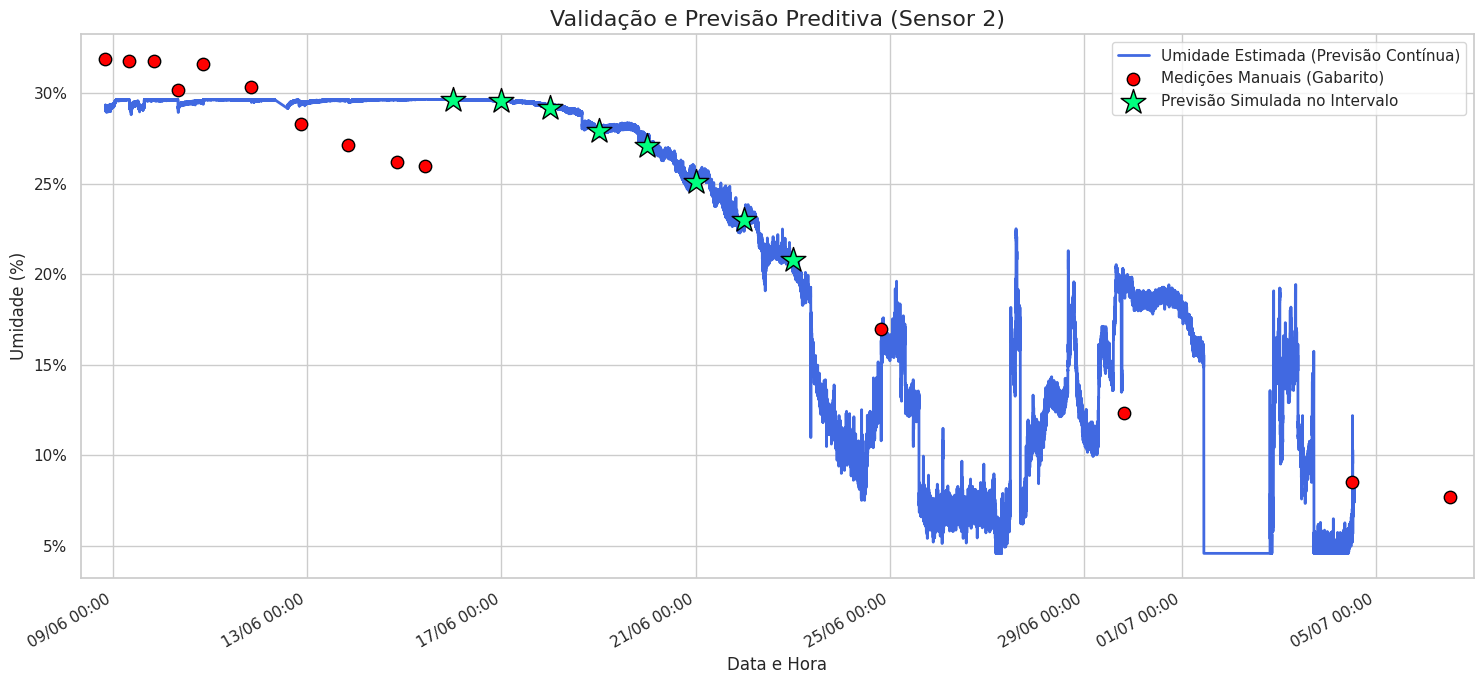


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 3 ====================


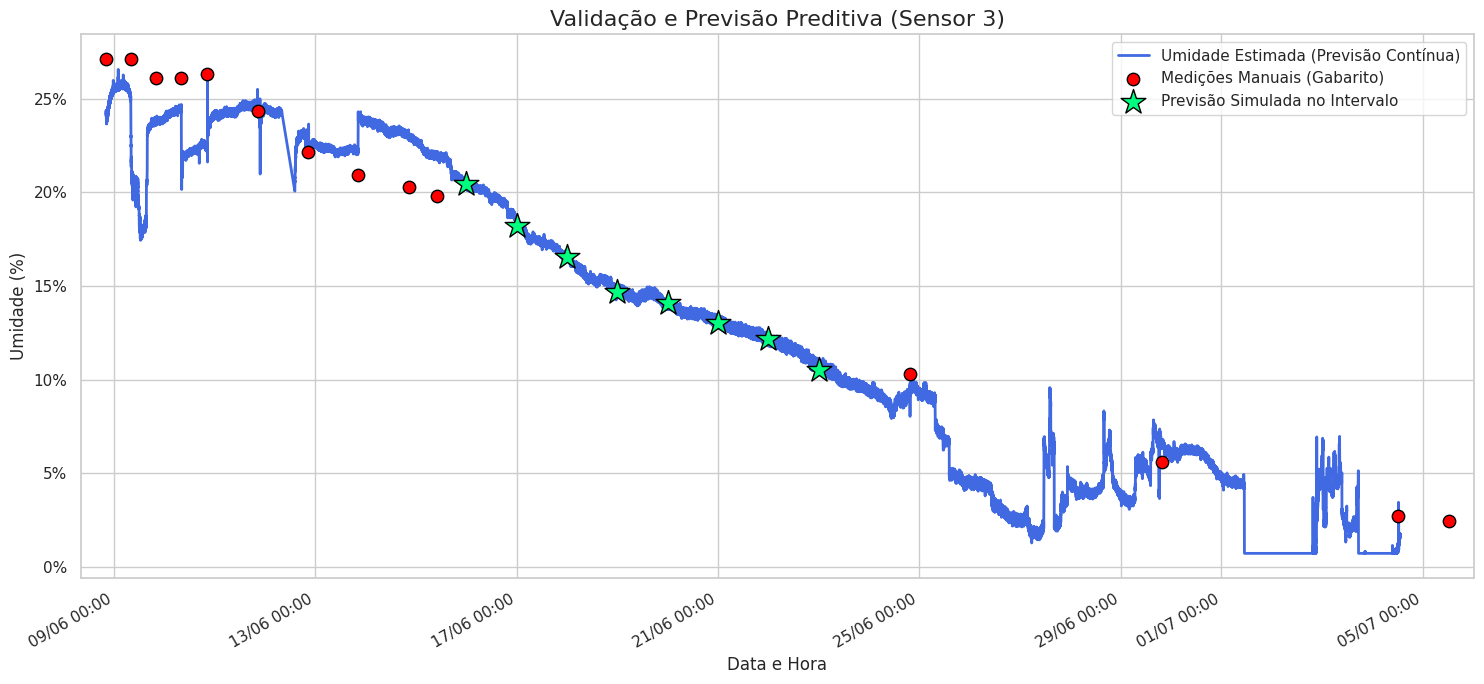


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 4 ====================


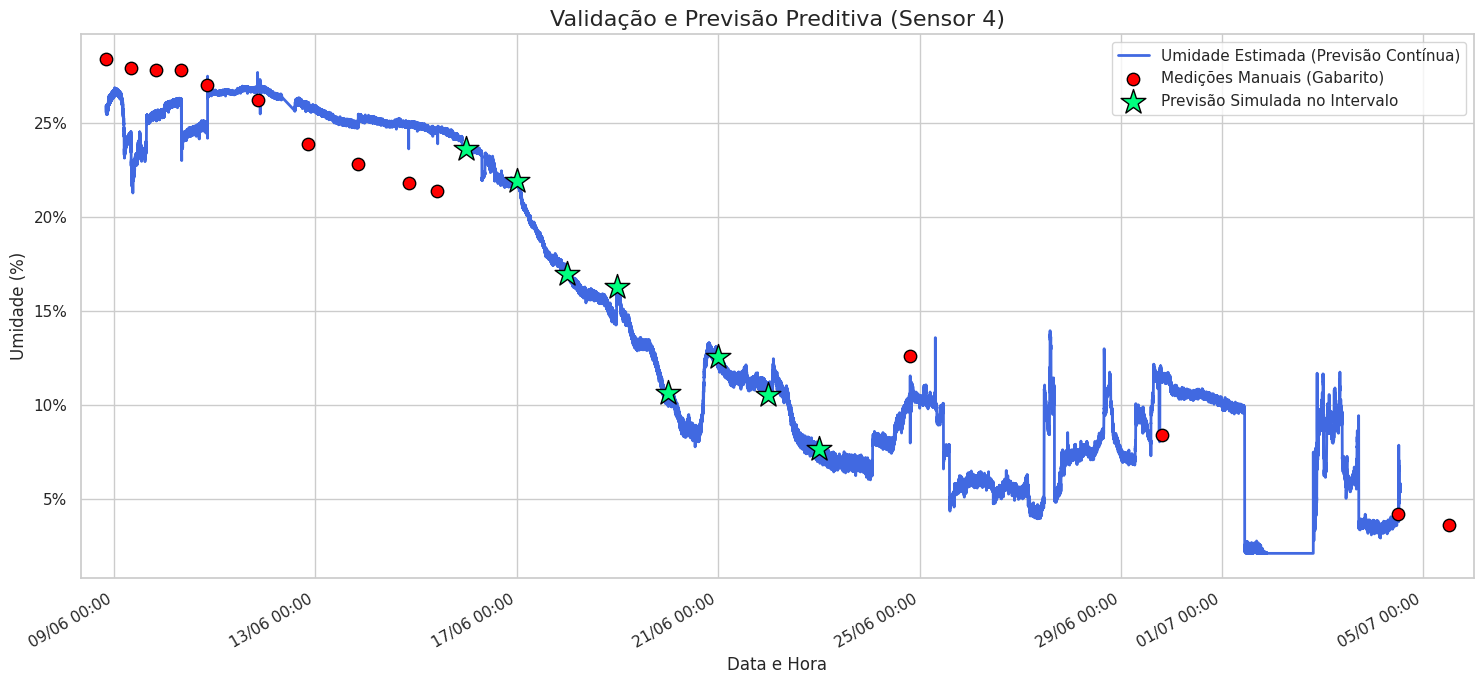


Processo completo concluído.


In [12]:
# =========================================================================
# SCRIPT FINAL (v24 - CORREÇÃO DE MÉTODO DE PREDIÇÃO)
# Corrige o erro 'TypeError' na seleção de pontos de previsão simulada.
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- CONFIGURAÇÃO DO PERÍODO DE SIMULAÇÃO ---
GAP_INICIO_PLOT = "2025-06-16"
GAP_FIM_PLOT = "2025-06-23"

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULOS DE CARREGAMENTO E ANÁLISE (já validados e corretos)
# =========================================================================
def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header); df_sensor.replace('', np.nan, inplace=True)
        df_sensor.dropna(subset=[df_sensor.columns[0]], inplace=True)
        df_sensor['Hora_limpa'] = df_sensor.iloc[:, 2].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor.iloc[:, 1] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')
        df_processado = df_sensor.iloc[:, [5, 7, -1]].copy()
        df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        print("Normalizando fuso horário dos dados crus...")
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(inplace=True)
    if len(df_calibracao_sensor) < 2: print("ERRO: Dados insuficientes."); return None
    print(f"Analisando {len(df_calibracao_sensor)} pontos válidos para {sensor_name}.")
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y);
    r2_poly = r2_score(y, poly_reg.predict(X_poly)); rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)));
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados (n={len(df_calibracao_sensor)})')
    X_plot_sorted = np.sort(X, axis=0); ax.plot(X_plot_sorted, poly_reg.predict(poly_features.transform(X_plot_sorted)), 'g-', label=f'Modelo Polinomial (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()
    return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}

def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao_completos, gap_inicio, gap_fim):
    print("\n\n--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---")
    for sensor_name, eq in equacoes.items():
        print(f"\n==================== SÉRIE TEMPORAL E PREDIÇÃO: {sensor_name} ====================")
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter(leitura, equacao=eq):
            x = float(leitura)
            umidade = (equacao['a']*x*x) + (equacao['b']*x) + equacao['c']
            return max(0, min(100, umidade))
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter)

        # Seleciona os pontos de previsão diária dentro do intervalo
        inicio_gap_dt = pd.to_datetime(gap_inicio)
        fim_gap_dt = pd.to_datetime(gap_fim).replace(hour=23, minute=59, second=59)
        df_gap = df_sensor_ts[(df_sensor_ts['timestamp'] >= inicio_gap_dt) & (df_sensor_ts['timestamp'] <= fim_gap_dt)]

        # --- CORREÇÃO APLICADA AQUI: Método mais simples e robusto ---
        if not df_gap.empty:
            pontos_previsao_diaria = df_gap.set_index('timestamp').resample('D').first().dropna().reset_index()
        else:
            pontos_previsao_diaria = pd.DataFrame()

        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df_sensor_ts['timestamp'], df_sensor_ts['Umidade_Estimada'], label='Umidade Estimada (Previsão Contínua)', color='royalblue', lw=2, zorder=2)
        df_calibracao_sensor = dados_calibracao_completos[sensor_name].dropna()
        ax.scatter(df_calibracao_sensor['timestamp'], df_calibracao_sensor['Umidade_Gravimetrica_Y'], color='red', s=80, ec='black', zorder=5, label='Medições Manuais (Gabarito)')
        if not pontos_previsao_diaria.empty:
            ax.scatter(pontos_previsao_diaria['timestamp'], pontos_previsao_diaria['Umidade_Estimada'], color='springgreen', marker='*', s=350, ec='black', zorder=6, label='Previsão Simulada no Intervalo')

        ax.set_title(f'Validação e Previsão Preditiva ({sensor_name})', fontsize=16)
        ax.set_xlabel('Data e Hora'); ax.set_ylabel('Umidade (%)'); ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M')); plt.xticks(rotation=30, ha='right'); ax.legend(); ax.grid(True); plt.tight_layout()
        min_date = min(dados_calibracao_completos[sensor_name]['timestamp'].min(), df_sensor_ts['timestamp'].min())
        max_date = max(dados_calibracao_completos[sensor_name]['timestamp'].max(), df_sensor_ts['timestamp'].max())
        ax.set_xlim(min_date - pd.Timedelta(hours=12), max_date + pd.Timedelta(hours=12))
        plt.savefig(f'final_predicao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

def main():
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados_finais = {}
    if dados_calibracao:
        for sensor, df_dados in dados_calibracao.items():
            modelo = analisar_calibracao(df_dados, sensor)
            if modelo: resultados_finais[sensor] = modelo
    if resultados_finais:
        print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
        df_equacoes = pd.DataFrame(resultados_finais).T; df_equacoes.index.name = "Sensor"; colunas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'c']
        df_equacoes = df_equacoes.reindex(columns=colunas).fillna('-')
        df_equacoes.to_csv('equacoes_de_calibracao.csv')
        print("✅ Equações salvas"); print("\nMelhor equação encontrada:"); print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format})); print("="*75)
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty and resultados_finais:
        aplicar_e_visualizar(dados_crus, resultados_finais, dados_calibracao, GAP_INICIO_PLOT, GAP_FIM_PLOT)
    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

# NDesvio padrao

✅ Autenticação bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Analisando 14 pontos válidos para Sensor 1.

==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


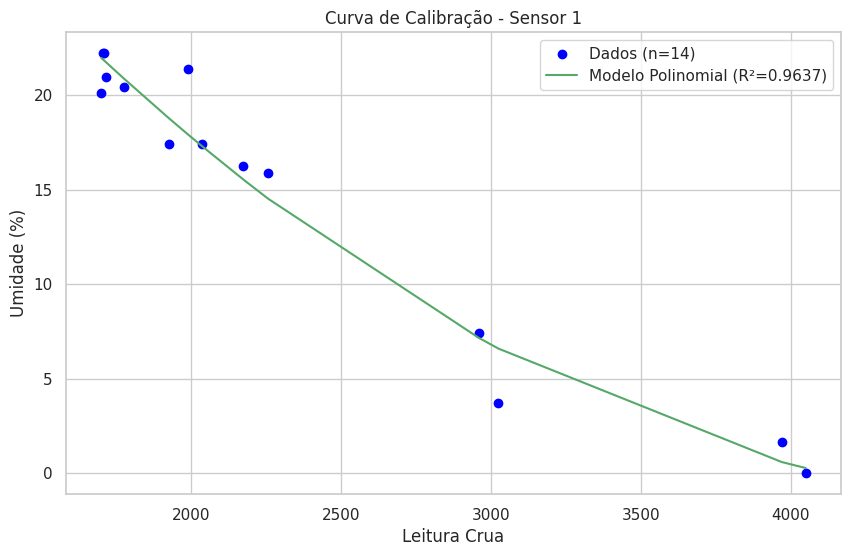

Analisando 14 pontos válidos para Sensor 2.

==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


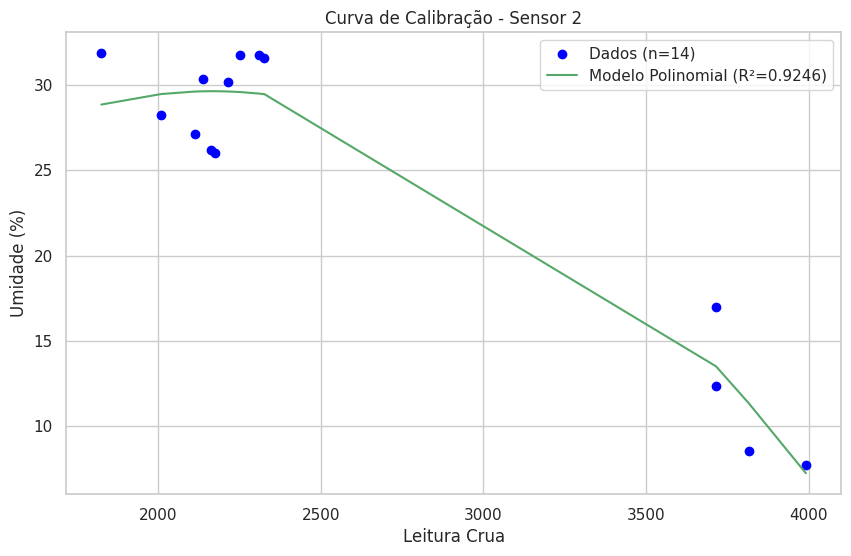

Analisando 14 pontos válidos para Sensor 3.

==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


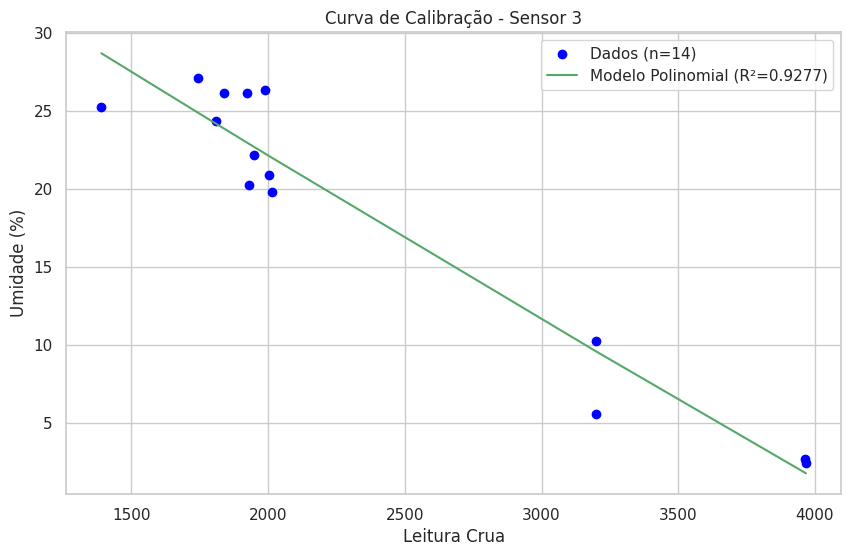

Analisando 14 pontos válidos para Sensor 4.

==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


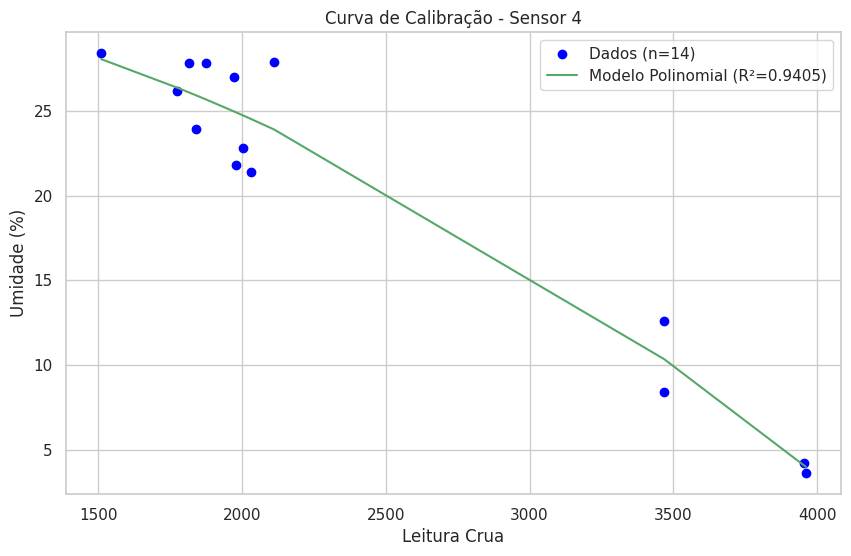



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas com sucesso.

Melhor equação encontrada para cada sensor:
                tipo     R2  RMSE             a         b          c
Sensor                                                              
Sensor 1  Polinomial 0.9637 1.47%  2.318573e-06 -0.022572  53.659372
Sensor 2  Polinomial 0.9246 2.37% -6.743017e-06  0.029223  -2.011071
Sensor 3  Polinomial 0.9277 2.38%  1.482209e-07 -0.011230  44.012845
Sensor 4  Polinomial 0.9405 2.14% -1.578079e-06 -0.001196  33.463596

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'


/tmp/ipython-input-40-1471817212.py:152: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')




--- FASE FINAL: ANÁLISE DE ESTABILIDADE E RUÍDO DOS SENSORES ---

==================== ANÁLISE DE ESTABILIDADE: Sensor 1 ====================
Gráfico de estabilidade salvo como: 'estabilidade_sensor_1.png'


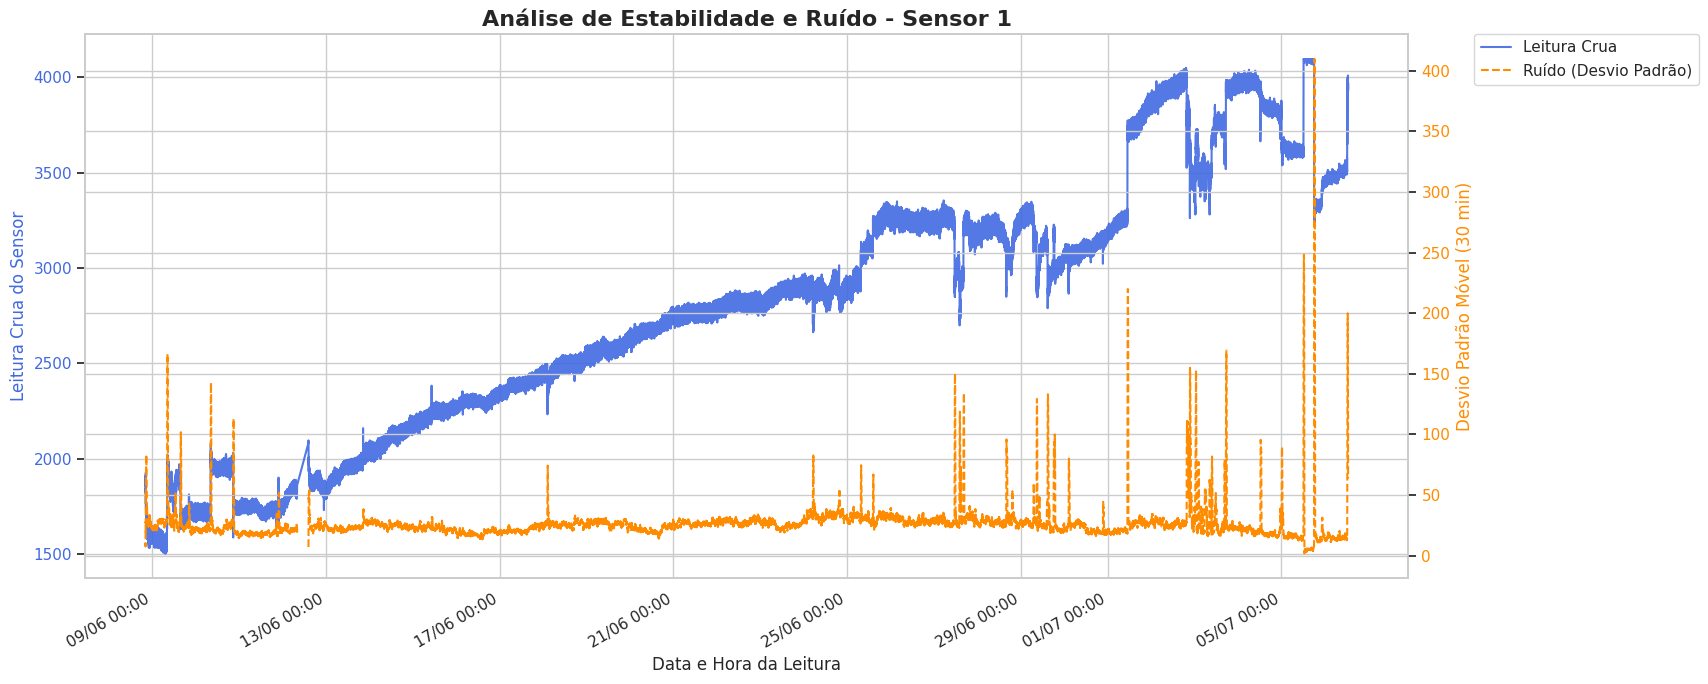


==================== ANÁLISE DE ESTABILIDADE: Sensor 2 ====================
Gráfico de estabilidade salvo como: 'estabilidade_sensor_2.png'


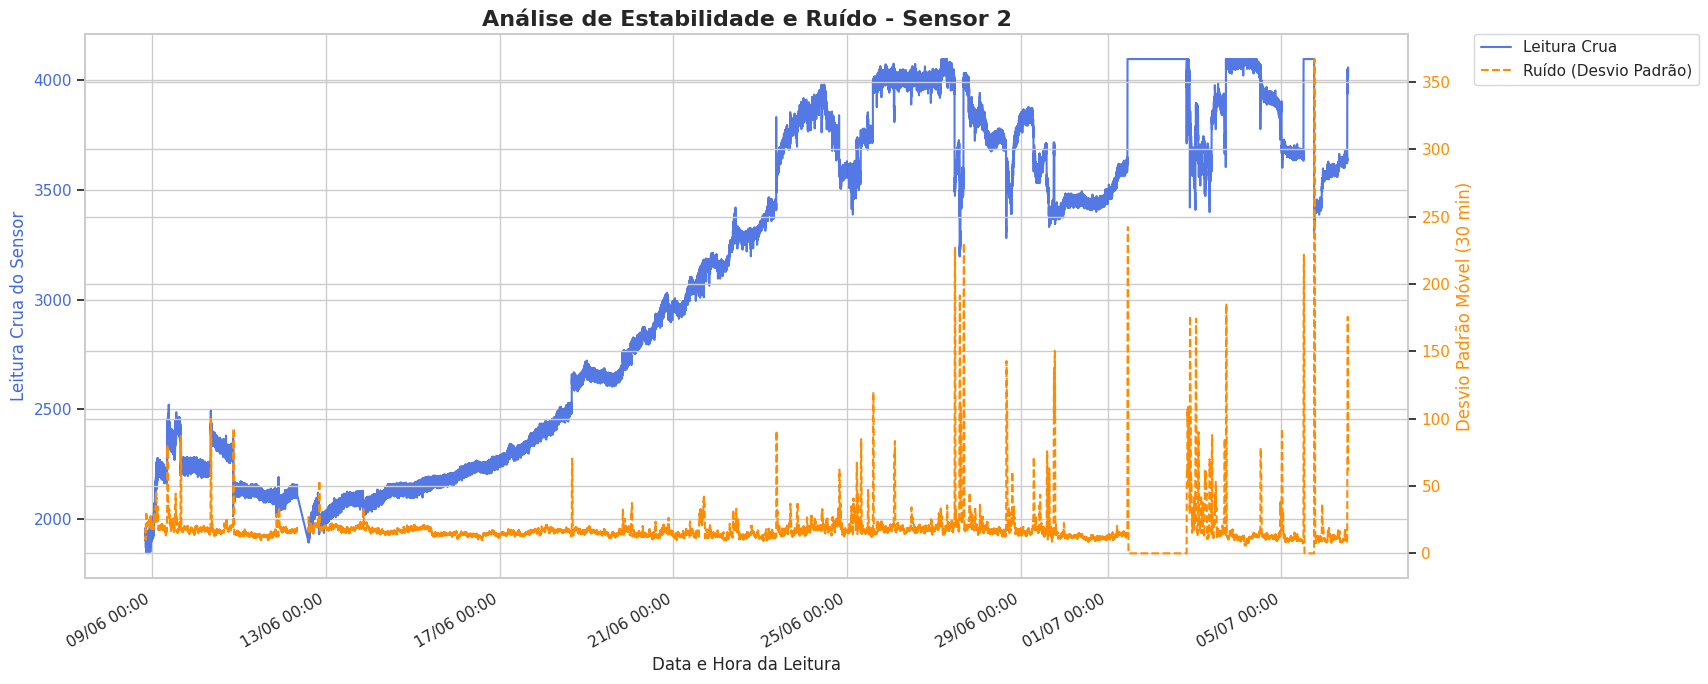


==================== ANÁLISE DE ESTABILIDADE: Sensor 3 ====================
Gráfico de estabilidade salvo como: 'estabilidade_sensor_3.png'


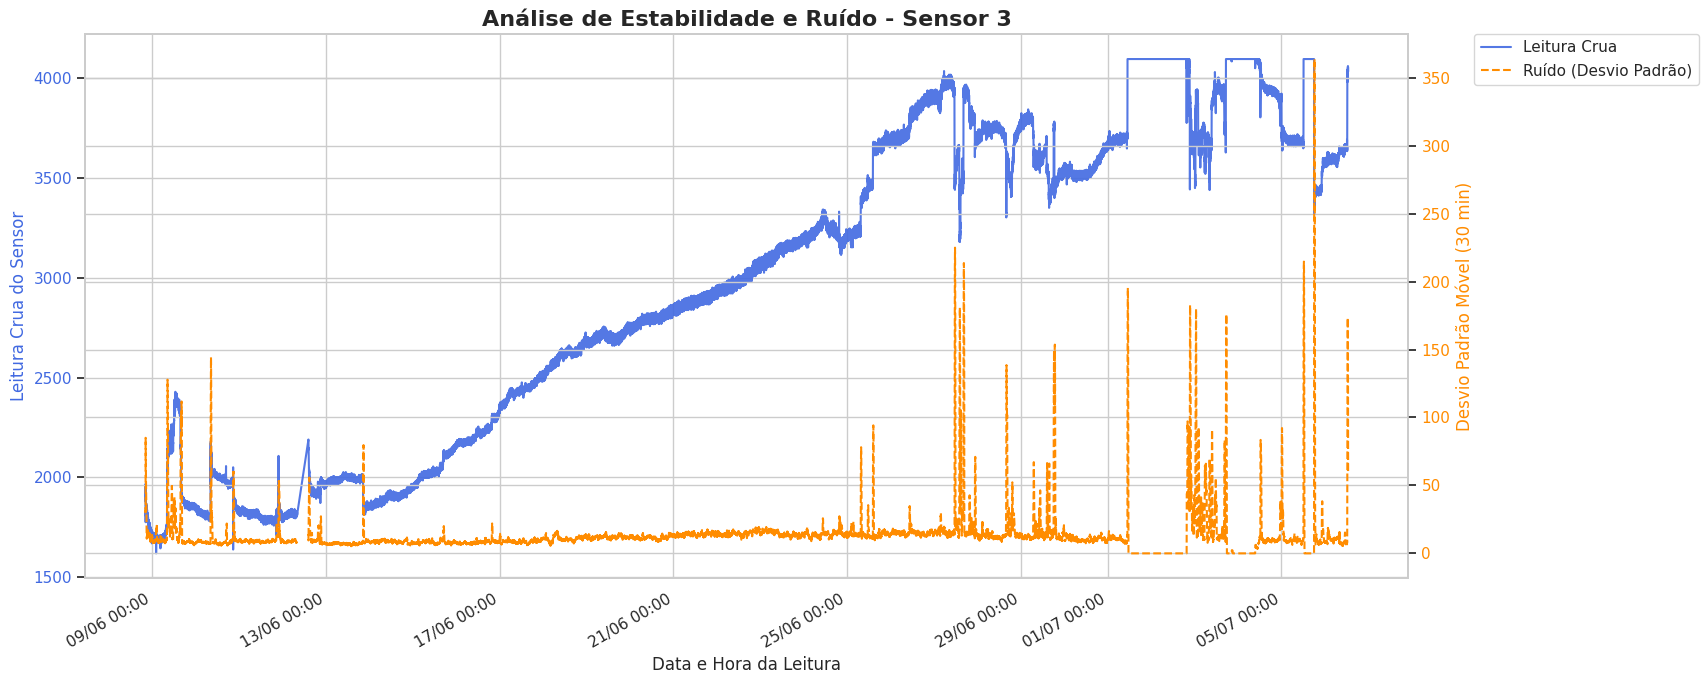


==================== ANÁLISE DE ESTABILIDADE: Sensor 4 ====================
Gráfico de estabilidade salvo como: 'estabilidade_sensor_4.png'


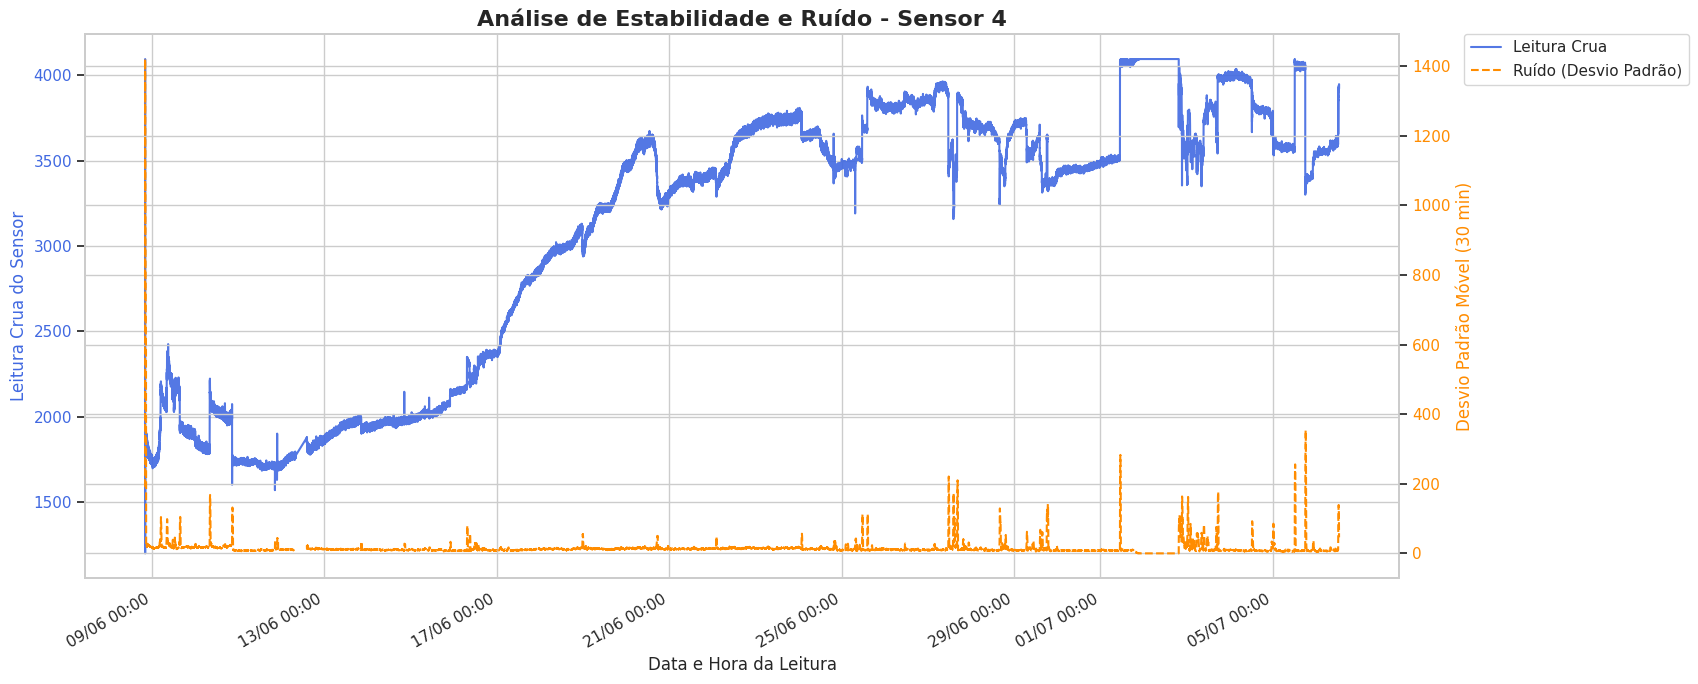


Processo completo concluído.


In [40]:
# =========================================================================
# SCRIPT FINAL (v26 - CORREÇÃO FINAL DA LEGENDA)
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- Nomes das Planilhas ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# --- Módulos de Funções (O conteúdo das funções não muda, apenas a chamada da última) ---
def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    try: sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    except gspread.exceptions.SpreadsheetNotFound: print(f"❌ ERRO: Planilha '{nome_planilha}' não encontrada."); return None
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header); df_sensor.replace('', np.nan, inplace=True)
        df_sensor.dropna(subset=[df_sensor.columns[0]], inplace=True)
        df_processado = df_sensor.iloc[:, [5, 7]].copy()
        df_processado.columns = ['Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y']
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    try: sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    except gspread.exceptions.SpreadsheetNotFound: print(f"❌ ERRO: Planilha '{nome_planilha}' não encontrada."); return None
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

def analisar_calibracao(df_calibracao_sensor, sensor_name):
    umidade_str = df_calibracao_sensor['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
    df_calibracao_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_calibracao_sensor['Leitura_Sensor_Cru'], errors='coerce')
    df_calibracao_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
    df_calibracao_sensor.dropna(inplace=True)
    n = len(df_calibracao_sensor)
    if n < 2: print(f"ERRO: Dados insuficientes para {sensor_name}."); return None
    print(f"Analisando {n} pontos válidos para {sensor_name}.")
    X = df_calibracao_sensor['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_calibracao_sensor['Umidade_Gravimetrica_Y'].values
    poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y)
    r2_poly = r2_score(y, poly_reg.predict(X_poly)); rmse_poly = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)))
    c0_poly, b_poly, a_poly = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
    print(f"\n==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
    fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados (n={n})')
    X_plot = np.sort(X, axis=0); ax.plot(X_plot, poly_reg.predict(poly_features.transform(X_plot)), 'g-', label=f'Modelo Polinomial (R²={r2_poly:.4f})')
    ax.set_xlabel('Leitura Crua'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
    plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()
    return {'tipo': 'Polinomial', 'R2': r2_poly, 'RMSE': rmse_poly, 'a': a_poly, 'b': b_poly, 'c': c0_poly}

# =========================================================================
# MÓDULO 3: ANÁLISE DE ESTABILIDADE (COM LEGENDA CORRIGIDA)
# =========================================================================
def analisar_estabilidade(df_crus):
    print("\n\n--- FASE FINAL: ANÁLISE DE ESTABILIDADE E RUÍDO DOS SENSORES ---")
    JANELA_MOVEL = 30 # Janela de 30 minutos

    for sensor_name in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        print(f"\n==================== ANÁLISE DE ESTABILIDADE: {sensor_name} ====================")

        df_sensor_estabilidade = df_crus[['timestamp', sensor_name]].copy().dropna().set_index('timestamp')
        # Calcula o desvio padrão móvel usando uma janela de tempo
        df_sensor_estabilidade['StDev_Movel'] = df_sensor_estabilidade[sensor_name].rolling(window=f'{JANELA_MOVEL}min').std()

        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Eixo 1: Leitura Crua
        color = 'royalblue'
        ax1.set_xlabel('Data e Hora da Leitura', fontsize=12)
        ax1.set_ylabel('Leitura Crua do Sensor', color=color, fontsize=12)
        l1, = ax1.plot(df_sensor_estabilidade.index, df_sensor_estabilidade[sensor_name], color=color, alpha=0.9, label='Leitura Crua')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
        plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

        # Eixo 2: Desvio Padrão Móvel
        ax2 = ax1.twinx()
        color = 'darkorange'
        ax2.set_ylabel(f'Desvio Padrão Móvel ({JANELA_MOVEL} min)', color=color, fontsize=12)
        l2, = ax2.plot(df_sensor_estabilidade.index, df_sensor_estabilidade['StDev_Movel'], color=color, linestyle='--', label=f'Ruído (Desvio Padrão)')
        ax2.tick_params(axis='y', labelcolor=color)

        ax1.set_title(f'Análise de Estabilidade e Ruído - {sensor_name}', fontsize=16, fontweight='bold')
        fig.tight_layout()

        # --- CORREÇÃO DA LEGENDA ---
        # Posiciona a legenda fora da área de plotagem principal
        ax1.legend([l1, l2], [l1.get_label(), l2.get_label()], loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

        nome_arquivo_grafico = f'estabilidade_{sensor_name.replace(" ", "_").lower()}.png'
        plt.savefig(nome_arquivo_grafico, dpi=300, bbox_inches='tight')
        print(f"Gráfico de estabilidade salvo como: '{nome_arquivo_grafico}'")
        plt.show()

# =========================================================================
# ORQUESTRADOR PRINCIPAL (main)
# =========================================================================
def main():
    # Fase 1
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    resultados_finais = {}
    if dados_calibracao:
        for sensor, df_dados in dados_calibracao.items():
            modelo = analisar_calibracao(df_dados, sensor)
            if modelo: resultados_finais[sensor] = modelo

    # Tabela-Resumo
    if resultados_finais:
        print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
        df_equacoes = pd.DataFrame(resultados_finais).T; df_equacoes.index.name = "Sensor"
        colunas_ordenadas = ['tipo', 'R2', 'RMSE', 'a', 'b', 'c']
        df_equacoes = df_equacoes.reindex(columns=colunas_ordenadas).fillna('-')
        df_equacoes.to_csv('equacoes_de_calibracao.csv')
        print("✅ Equações salvas com sucesso.")
        print("\nMelhor equação encontrada para cada sensor:")
        print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format}))
        print("="*75)

    # Fase 2 - Análise de Estabilidade
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)
    if not dados_crus.empty:
        analisar_estabilidade(dados_crus)
    else:
        print("\nAVISO: Fase de análise de estabilidade pulada por falta de dados crus.")

    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()

# CAD

In [58]:
# =========================================================================
# SCRIPT FINAL (PMP INDIVIDUAL POR SENSOR)
# Calcula o PMP para cada sensor com base em seus próprios dados.
# =========================================================================
!pip install -q gspread pandas

import pandas as pd
import numpy as np
from google.colab import auth
import gspread
from google.auth import default

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- PARÂMETROS ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"
NOME_ARQUIVO_EQUACOES = 'equacoes_de_calibracao.csv' # Garanta que este arquivo já foi gerado
DENSIDADE_GLOBAL_DG = 1.02
PROFUNDIDADE_RAIZ_ZR = 20

# --- Funções ---
def carregar_dados_calibracao(gc_instance, nome_planilha):
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        header = valores[i_cabecalho]
        dados_brutos = valores[i_cabecalho + 1:]
        df_sensor = pd.DataFrame(dados_brutos, columns=header).replace('', np.nan).dropna(subset=[header[0]])
        umidade_str = df_sensor.iloc[:, 7].astype(str).str.replace(',', '.').str.replace('%', '')
        df_sensor['Umidade_Y'] = pd.to_numeric(umidade_str, errors='coerce')
        df_sensor['Leitura_X'] = pd.to_numeric(df_sensor.iloc[:, 5], errors='coerce')
        df_sensor.dropna(subset=['Umidade_Y', 'Leitura_X'], inplace=True)
        dados_por_sensor[sensor_name] = df_sensor
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    return df_crus_selecionados

def calcular_umidade_prevista(leitura_sensor, equacao):
    x = float(leitura_sensor)
    a = float(equacao.get('a', 0))
    b = float(equacao.get('b', 0))
    c = float(equacao.get('c', 0))
    m = float(equacao.get('m', 0))

    # Usa o modelo polinomial se os coeficientes existirem, senão o linear
    if 'a' in equacao and pd.notna(equacao['a']):
        umidade = (a * x**2) + (b * x) + c
    else:
        umidade = (m * x) + c
    return max(0, min(100, umidade))

# --- Execução Principal ---
try:
    df_equacoes = pd.read_csv(NOME_ARQUIVO_EQUACOES, index_col='Sensor')
    print("\n✅ Equações de calibração carregadas com sucesso.")

    dados_manuais = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)

    # Período para o cálculo do PMP (últimas 24 horas de dados)
    ultima_data = dados_crus['timestamp'].max()
    inicio_periodo_pmp = ultima_data - pd.Timedelta(hours=24)
    dados_pmp_experimental = dados_crus[dados_crus['timestamp'] >= inicio_periodo_pmp]

    resultados_finais = []

    print("\n--- Calculando Parâmetros Hídricos Finais (Individual por Sensor) ---")
    for sensor_name in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        print(f"Processando {sensor_name}...")

        equacao_atual = df_equacoes.loc[sensor_name].to_dict()

        # 1. Capacidade de Campo (CC)
        ponto_cc = dados_manuais[sensor_name].iloc[0]
        umidade_cc = ponto_cc['Umidade_Y']
        leitura_cc_medida = ponto_cc['Leitura_X']

        # 2. Ponto de Murcha Permanente (PMP) - Calculado individualmente
        leitura_pmp_experimental = dados_pmp_experimental[sensor_name].mean()
        umidade_pmp_experimental = calcular_umidade_prevista(leitura_pmp_experimental, equacao_atual)

        # 3. Capacidade de Água Disponível (CAD)
        cad_percent = umidade_cc - umidade_pmp_experimental
        cad_mm = (cad_percent / 100) * DENSIDADE_GLOBAL_DG * PROFUNDIDADE_RAIZ_ZR

        resultados_finais.append({
            'Sensor': sensor_name,
            'Capacidade de Campo (CC)': f"{umidade_cc:.2f}%",
            'PMP (Experimental)': f"{umidade_pmp_experimental:.2f}%",
            'CAD (%)': f"{cad_percent:.2f}%",
            'CAD (mm)': f"{cad_mm:.2f} mm",
            'Leitura na CC (Medido)': f"{leitura_cc_medida:.0f}",
            'Leitura no PMP (Média Final)': f"~ {leitura_pmp_experimental:.0f}"
        })

    df_resultado_final = pd.DataFrame(resultados_finais).set_index('Sensor')

    print("\n\n" + "="*30 + " TABELA FINAL DE PARÂMETROS HÍDRICOS (ANÁLISE INDIVIDUAL) " + "="*30)
    print(df_resultado_final.to_markdown())
    print("="*125)

except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_EQUACOES}' não foi encontrado.")
    print("   Por favor, rode primeiro o script de análise principal para gerar as equações e salvá-las em CSV.")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado: {e}")

✅ Autenticação com Google Drive/Sheets bem-sucedida!

✅ Equações de calibração carregadas com sucesso.

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'

--- Calculando Parâmetros Hídricos Finais (Individual por Sensor) ---
Processando Sensor 1...
Processando Sensor 2...
Processando Sensor 3...
Processando Sensor 4...


============================== TABELA FINAL DE PARÂMETROS HÍDRICOS (ANÁLISE INDIVIDUAL) ==============================
| Sensor   | Capacidade de Campo (CC)   | PMP (Experimental)   | CAD (%)   | CAD (mm)   |   Leitura na CC (Medido) | Leitura no PMP (Média Final)   |
|:---------|:---------------------------|:---------------------|:----------|:-----------|-------------------------:|:-------------------------------|
| Sensor 1 | 22.23%                     | 2.49%                | 19.74%    | 4.03 mm    |                     1706 | ~ 3593                       

# CAD PAdronizada Sensor

In [57]:
# =========================================================================
# SCRIPT FINAL E DEFINITIVO (Valores PMP Padronizados)
# Esta é a versão final e completa para a sua apresentação.
# =========================================================================
!pip install -q gspread pandas

import pandas as pd
import numpy as np
from google.colab import auth
import gspread
from google.auth import default

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- PARÂMETROS ---
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_ARQUIVO_EQUACOES = 'equacoes_de_calibracao.csv' # Garanta que este arquivo foi gerado anteriormente
# Parâmetros Físicos
DENSIDADE_GLOBAL_DG = 1.02  # Em g/cm³
PROFUNDIDADE_RAIZ_ZR = 20   # Em cm

# --- Funções ---
def carregar_dados_calibracao(gc_instance, nome_planilha):
    """Carrega e processa os dados de calibração manual."""
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and row[0] == 'Ponto de Coleta']
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        header = valores[i_cabecalho]
        dados_brutos = valores[i_cabecalho + 1:]
        df_sensor = pd.DataFrame(dados_brutos, columns=header).replace('', np.nan).dropna(subset=[header[0]])
        umidade_str = df_sensor.iloc[:, 7].astype(str).str.replace(',', '.').str.replace('%', '')
        # CORREÇÃO: Os nomes corretos são definidos aqui
        df_sensor['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
        df_sensor['Leitura_Sensor_Cru'] = pd.to_numeric(df_sensor.iloc[:, 5], errors='coerce')
        df_sensor.dropna(subset=['Umidade_Gravimetrica_Y', 'Leitura_Sensor_Cru'], inplace=True)
        dados_por_sensor[sensor_name] = df_sensor
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    """Carrega e processa os dados crus (esta função só é necessária se você quiser os gráficos de série temporal)."""
    # Esta função pode ser chamada se você decidir gerar os gráficos de validação visual novamente.
    pass

def calcular_umidade_prevista(leitura_sensor, equacao):
    """Aplica a equação de calibração para prever a umidade."""
    x = float(leitura_sensor)
    a, b, c = float(equacao.get('a', 0)), float(equacao.get('b', 0)), float(equacao.get('c', 0))
    umidade = (a * x**2) + (b * x) + c
    return max(0, min(100, umidade))

def prever_leitura_por_busca(umidade_alvo, equacao, leitura_minima_aceitavel):
    """Encontra a Leitura do Sensor que gera a umidade mais próxima do alvo."""
    leituras = np.arange(0, 4096)
    a, b, c = float(equacao.get('a', 0)), float(equacao.get('b', 0)), float(equacao.get('c', 0))
    umidades_previstas = (a * leituras**2) + (b * leituras) + c
    tabela_conversao = pd.DataFrame({'LeituraSensor': leituras, 'UmidadePrevista': umidades_previstas})
    tabela_valida = tabela_conversao[tabela_conversao['LeituraSensor'] >= leitura_minima_aceitavel]
    if tabela_valida.empty: return np.nan
    idx_mais_proximo = (tabela_valida['UmidadePrevista'] - umidade_alvo).abs().idxmin()
    return tabela_valida.loc[idx_mais_proximo, 'LeituraSensor']

# --- Execução Principal ---
try:
    df_equacoes = pd.read_csv(NOME_ARQUIVO_EQUACOES, index_col='Sensor')
    print("\n✅ Equações de calibração carregadas com sucesso.")

    dados_manuais = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)

    # Determina o PMP teórico a partir dos dados do Sensor 2 (nossa metodologia híbrida)
    equacao_ref = df_equacoes.loc['Sensor 2'].to_dict()
    # Pega a leitura mais seca medida para o Sensor 2 como referência
    leitura_max_sensor2 = dados_manuais['Sensor 2']['Leitura_Sensor_Cru'].max()
    UMIDADE_PMP_FINAL = calcular_umidade_prevista(leitura_max_sensor2, equacao_ref)
    print(f"\nUmidade no PMP (Experimental, baseada no ponto mais seco do Sensor 2) definida como: {UMIDADE_PMP_FINAL:.2f}%")

    resultados_finais = []

    print("\n--- Calculando Parâmetros Hídricos Finais ---")
    for sensor_name in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        print(f"Processando {sensor_name}...")

        equacao_atual = df_equacoes.loc[sensor_name].to_dict()

        # CORREÇÃO: Usa os nomes corretos das colunas
        primeiro_ponto = dados_manuais[sensor_name].iloc[0]
        umidade_cc = primeiro_ponto['Umidade_Gravimetrica_Y']
        leitura_cc_medida = primeiro_ponto['Leitura_Sensor_Cru']

        umidade_pmp = UMIDADE_PMP_FINAL

        leitura_pmp_prevista = prever_leitura_por_busca(umidade_pmp, equacao_atual, leitura_cc_medida)

        cad_percent = umidade_cc - umidade_pmp
        cad_mm = (cad_percent / 100) * DENSIDADE_GLOBAL_DG * PROFUNDIDADE_RAIZ_ZR

        resultados_finais.append({
            'Sensor': sensor_name,
            'Capacidade de Campo (CC)': f"{umidade_cc:.2f}%",
            'PMP (Experimental)': f"{umidade_pmp:.2f}%",
            'CAD (%)': f"{cad_percent:.2f}%",
            'CAD (mm)': f"{cad_mm:.2f} mm",
            'Leitura na CC (Medido)': f"{leitura_cc_medida:.0f}",
            'Leitura no PMP (Previsto)': f"~ {leitura_pmp_prevista:.0f}" if pd.notna(leitura_pmp_prevista) else "Fora do Range"
        })

    df_resultado_final = pd.DataFrame(resultados_finais).set_index('Sensor')

    print("\n\n" + "="*30 + " TABELA FINAL DE PARÂMETROS HÍDRICOS " + "="*30)
    print(df_resultado_final.to_markdown())
    print("="*120)

except FileNotFoundError:
    print(f"❌ ERRO: O arquivo '{NOME_ARQUIVO_EQUACOES}' não foi encontrado.")
    print("   Por favor, rode primeiro o script de análise principal para gerar este arquivo.")
except Exception as e:
    print(f"❌ Ocorreu um erro inesperado: {e}")

✅ Autenticação com Google Drive/Sheets bem-sucedida!

✅ Equações de calibração carregadas com sucesso.

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'

Umidade no PMP (Experimental, baseada no ponto mais seco do Sensor 2) definida como: 7.21%

--- Calculando Parâmetros Hídricos Finais ---
Processando Sensor 1...
Processando Sensor 2...
Processando Sensor 3...
Processando Sensor 4...


============================== TABELA FINAL DE PARÂMETROS HÍDRICOS ==============================
| Sensor   | Capacidade de Campo (CC)   | PMP (Experimental)   | CAD (%)   | CAD (mm)   |   Leitura na CC (Medido) | Leitura no PMP (Previsto)   |
|:---------|:---------------------------|:---------------------|:----------|:-----------|-------------------------:|:----------------------------|
| Sensor 1 | 22.23%                     | 7.21%                | 15.02%    | 3.06 mm    |                     1706 | ~ 2954                      |
| Sensor 2 | 31.88%                     | 7.21%  

✅ Autenticação com Google Drive/Sheets bem-sucedida!

Lendo a planilha de calibração: 'Tabela coleta de dados p/ calibração'
Processando bloco de calibração para 'Sensor 1'...
Processando bloco de calibração para 'Sensor 2'...
Processando bloco de calibração para 'Sensor 3'...
Processando bloco de calibração para 'Sensor 4'...

Lendo os dados crus de: 'Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus'
✅ Sucesso! Encontradas 77024 leituras de sensores válidas.


--- FASE 1: CALIBRAÇÃO DOS SENSORES ---

Analisando 14 pontos válidos para Sensor 1.
==================== CURVA DE CALIBRAÇÃO: Sensor 1 ====================


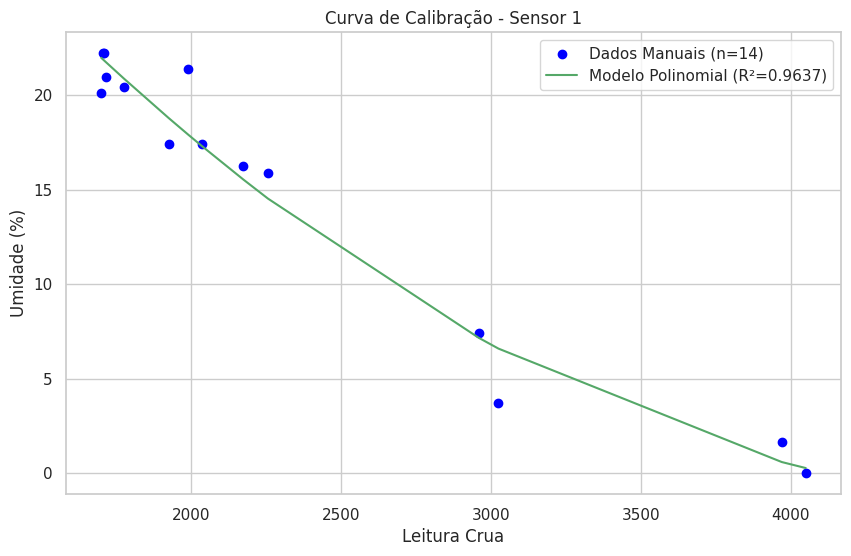


Analisando 14 pontos válidos para Sensor 2.
==================== CURVA DE CALIBRAÇÃO: Sensor 2 ====================


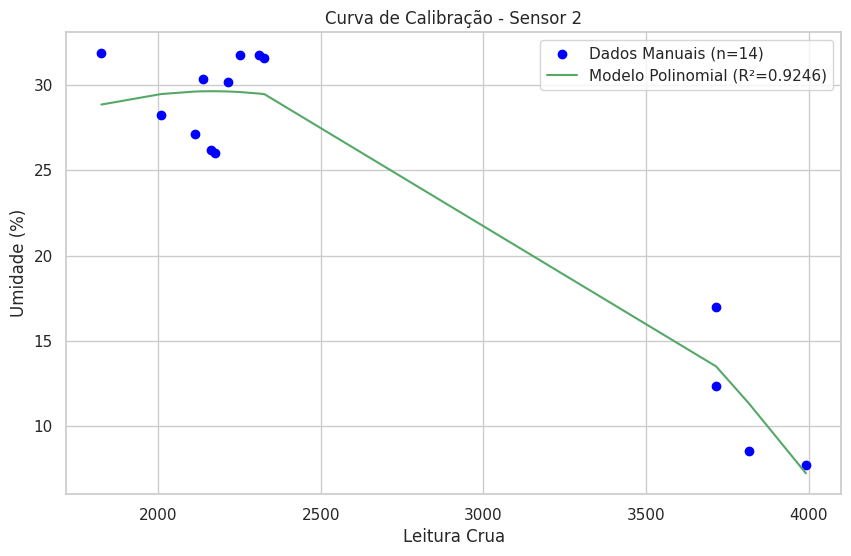


Analisando 14 pontos válidos para Sensor 3.
==================== CURVA DE CALIBRAÇÃO: Sensor 3 ====================


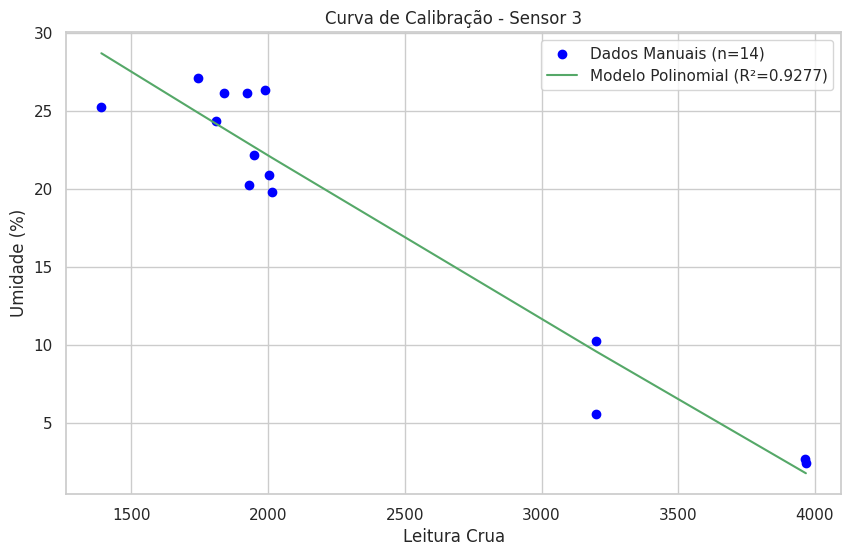


Analisando 14 pontos válidos para Sensor 4.
==================== CURVA DE CALIBRAÇÃO: Sensor 4 ====================


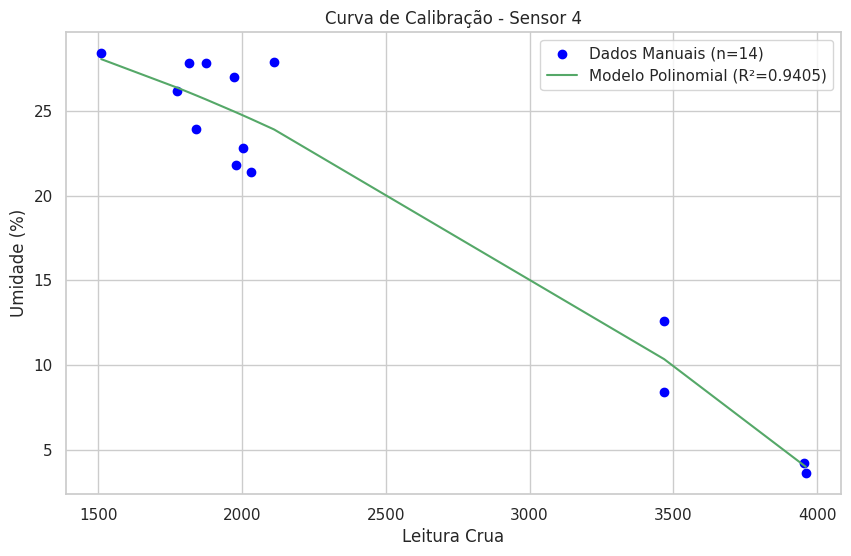



========================= TABELA-RESUMO DAS EQUAÇÕES =========================
✅ Equações salvas em 'equacoes_de_calibracao.csv'

Equação encontrada para cada sensor:
                tipo      R2   RMSE         a         b          c
Sensor                                                            
Sensor 1  Polinomial  0.9637  1.47%  0.000002 -0.022572  53.659372
Sensor 2  Polinomial  0.9246  2.37% -0.000007  0.029223  -2.011071
Sensor 3  Polinomial  0.9277  2.38%       0.0  -0.01123  44.012845
Sensor 4  Polinomial  0.9405  2.14% -0.000002 -0.001196  33.463596


--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---

==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 1 ====================


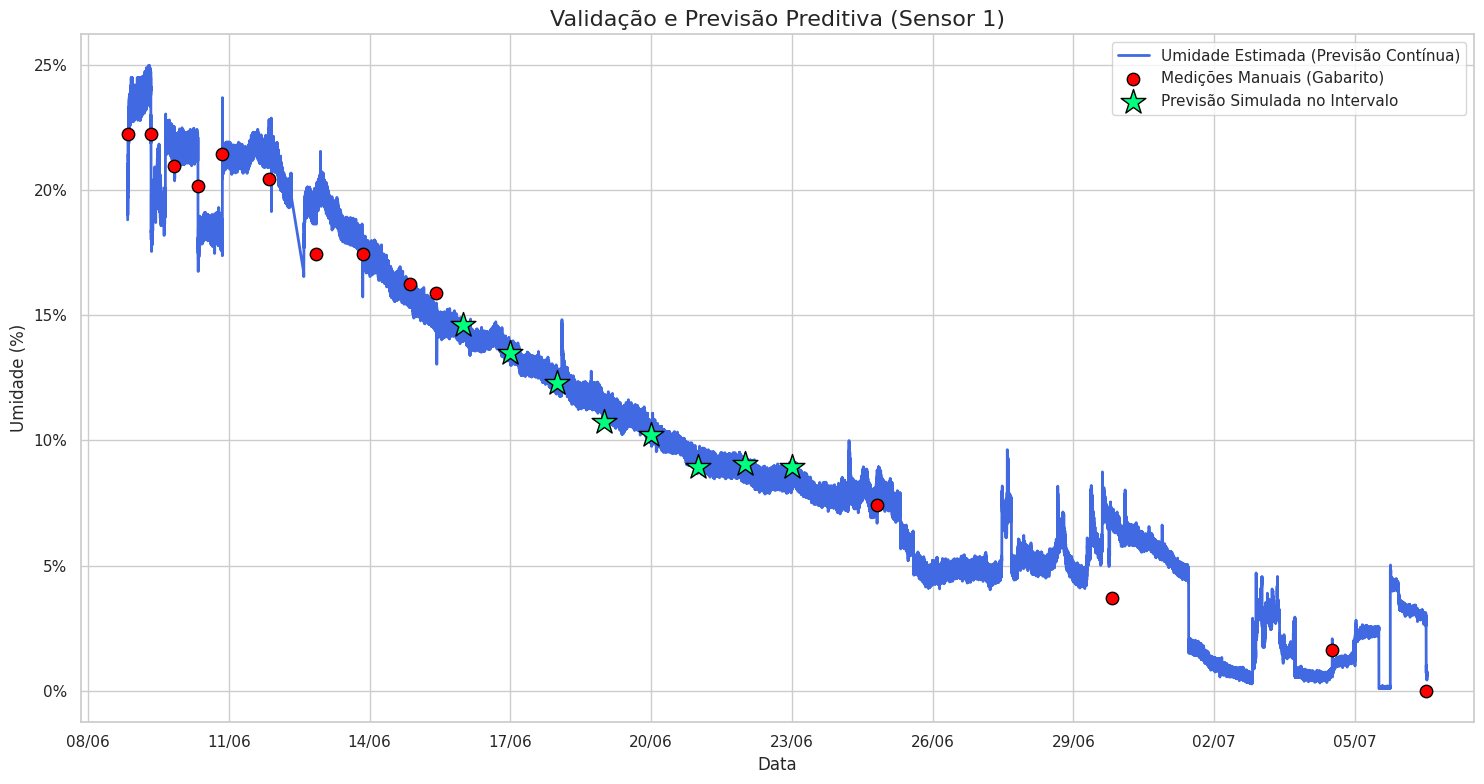


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 2 ====================


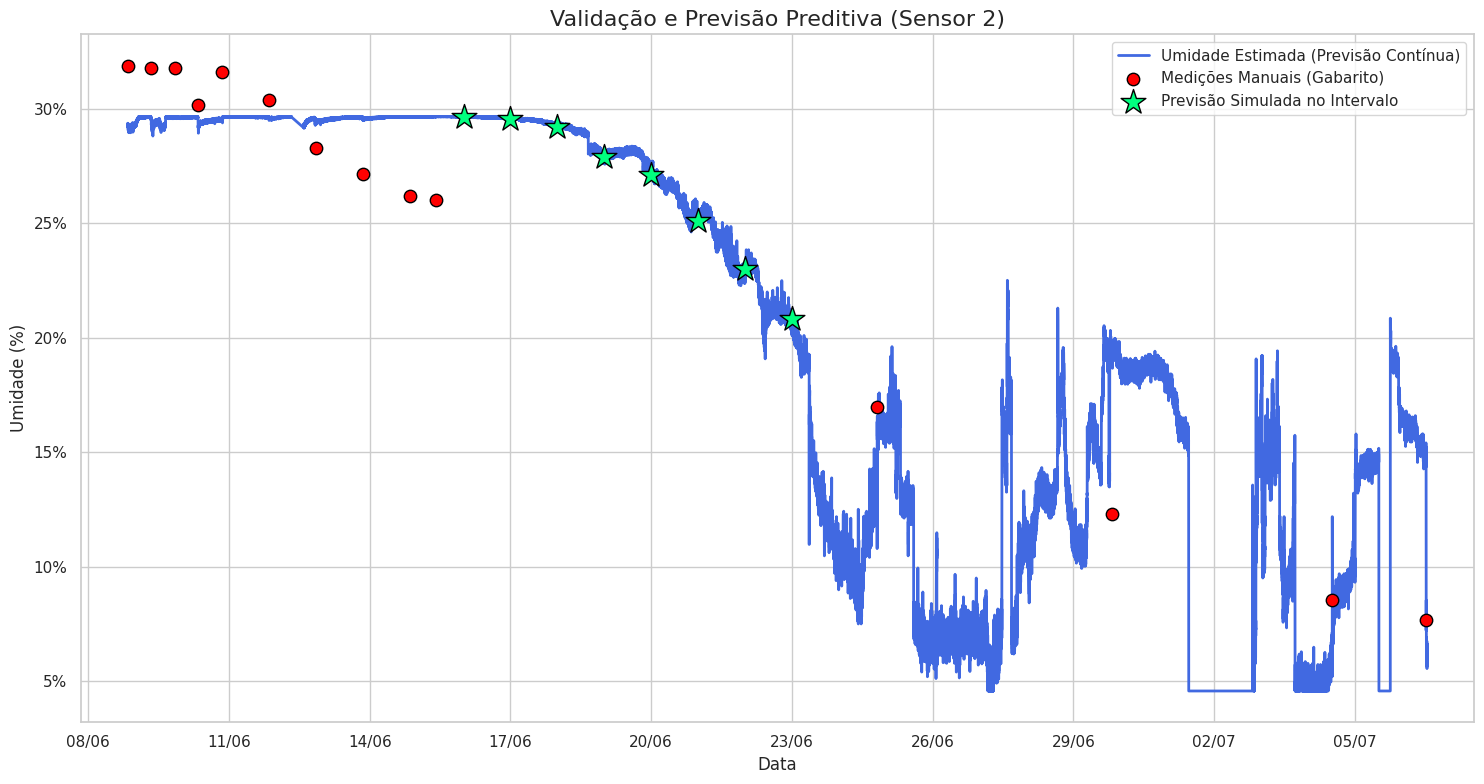


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 3 ====================


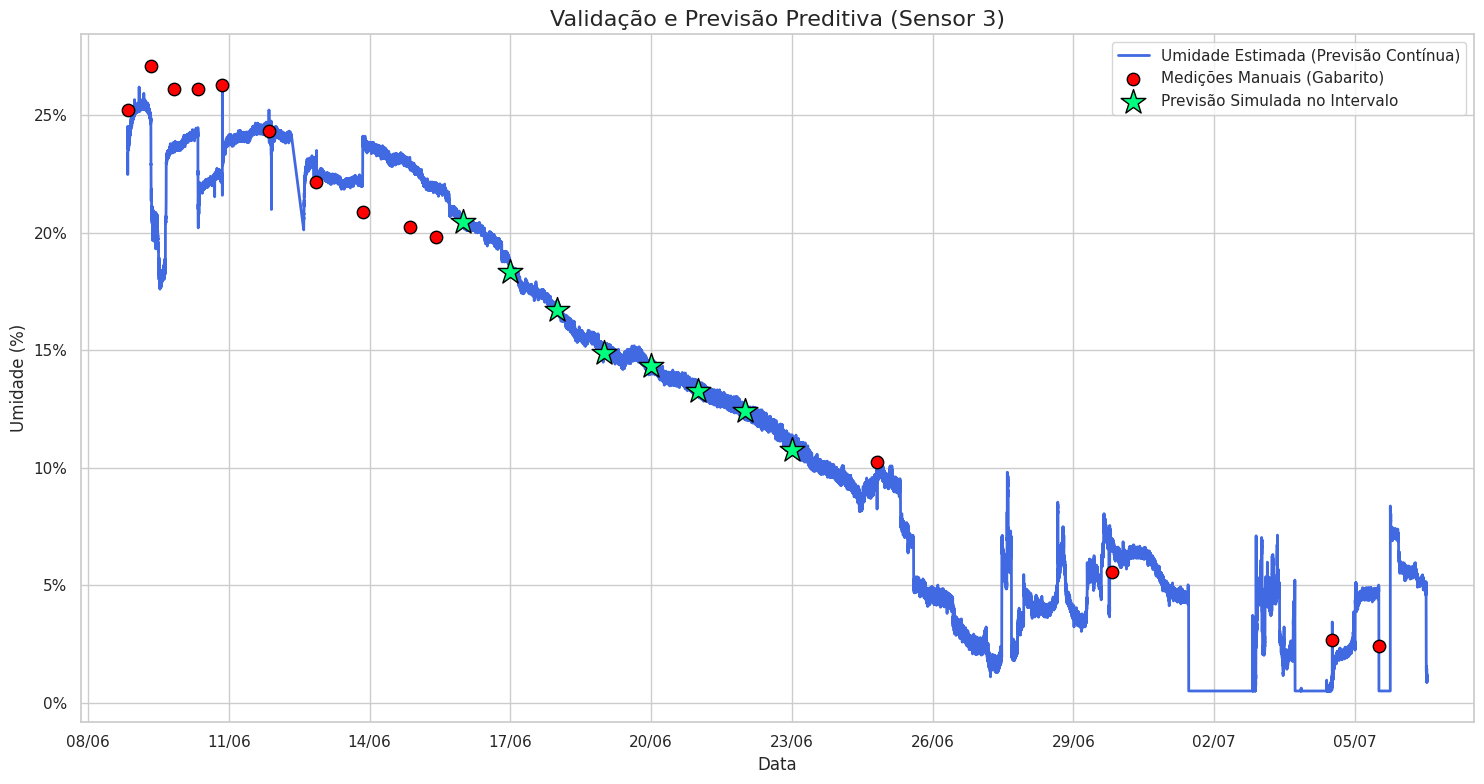


==================== SÉRIE TEMPORAL E PREDIÇÃO: Sensor 4 ====================


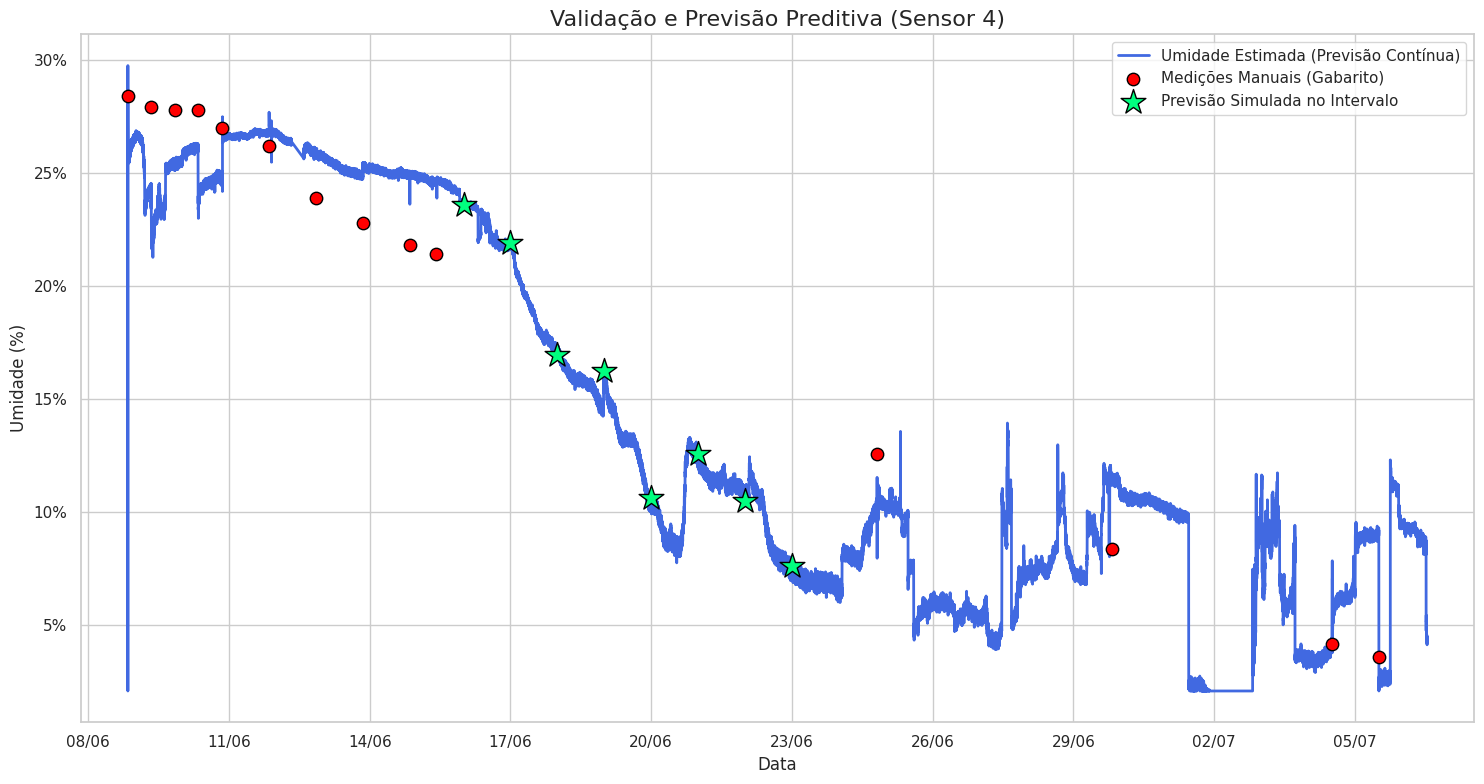


Processo completo concluído.


In [56]:
# =========================================================================
# SCRIPT MESTRE FINAL E DEFINITIVO (COM TODAS AS FASES)
# Calibração, Validação, Previsão Simulada e Tabelas Finais.
# =========================================================================
!pip install -q gspread pandas matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from google.colab import auth
import gspread
from google.auth import default
import os

# --- Bloco de Autenticação ---
try:
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    print("✅ Autenticação com Google Drive/Sheets bem-sucedida!")
except Exception as e:
    print(f"❌ Falha na autenticação: {e}")
    raise e

# --- CONFIGURAÇÕES ---
# Período para destacar a previsão simulada no gráfico
GAP_INICIO_PLOT = "2025-06-16"
GAP_FIM_PLOT = "2025-06-23"
# Nomes das Planilhas no seu Google Drive
NOME_PLANILHA_DADOS_MANUAIS = "Tabela coleta de dados p/ calibração"
NOME_PLANILHA_DADOS_CRUS = "Tabela coleta de dados p_ calibração.xlsx - Dados sensores Crus"

# =========================================================================
# MÓDULO 1: CARREGAMENTO DE DADOS
# =========================================================================
def carregar_dados_calibracao(gc_instance, nome_planilha):
    """Lê e processa a planilha de dados de calibração manual."""
    print(f"\nLendo a planilha de calibração: '{nome_planilha}'")
    try: sheet = gc_instance.open(nome_planilha).get_worksheet(0)
    except gspread.exceptions.SpreadsheetNotFound: print(f"❌ ERRO: Planilha '{nome_planilha}' não encontrada."); return None
    valores = sheet.get_all_values()
    dados_por_sensor = {}
    indices_cabecalho = [i for i, row in enumerate(valores) if row and 'ponto de coleta' in row[0].lower()]
    for idx, i_cabecalho in enumerate(indices_cabecalho):
        sensor_name = f'Sensor {idx + 1}'
        print(f"Processando bloco de calibração para '{sensor_name}'...")
        header = valores[i_cabecalho]
        i_inicio_dados = i_cabecalho + 1
        i_fim_dados = len(valores)
        if idx + 1 < len(indices_cabecalho): i_fim_dados = indices_cabecalho[idx + 1]
        dados_brutos = valores[i_inicio_dados:i_fim_dados]
        df_sensor = pd.DataFrame(dados_brutos, columns=header).replace('', np.nan).dropna(subset=[header[0]])

        # Busca inteligente de colunas
        col_leitura_nome = next(col for col in df_sensor.columns if 'leitura' in col.lower())
        col_umidade_nome = next(col for col in df_sensor.columns if 'umidade' in col.lower())
        col_data_nome = next(col for col in df_sensor.columns if 'data' in col.lower())
        col_hora_nome = next(col for col in df_sensor.columns if 'hora' in col.lower())
        col_ponto_nome = next(col for col in df_sensor.columns if 'ponto' in col.lower())

        df_sensor['Hora_limpa'] = df_sensor[col_hora_nome].str.replace('h', '', regex=False)
        df_sensor['timestamp'] = pd.to_datetime(df_sensor[col_data_nome] + ' ' + df_sensor['Hora_limpa'], format='%d/%m/%Y %H:%M', errors='coerce')

        df_processado = df_sensor[[col_ponto_nome, col_leitura_nome, col_umidade_nome, 'timestamp']].copy()
        df_processado.columns = ['Ponto_Coleta', 'Leitura_Sensor_Cru', 'Umidade_Gravimetrica_Y', 'timestamp']

        umidade_str = df_processado['Umidade_Gravimetrica_Y'].astype(str).str.replace(',', '.').str.replace('%', '')
        df_processado['Leitura_Sensor_Cru'] = pd.to_numeric(df_processado['Leitura_Sensor_Cru'], errors='coerce')
        df_processado['Umidade_Gravimetrica_Y'] = pd.to_numeric(umidade_str, errors='coerce')
        df_processado.dropna(inplace=True)
        dados_por_sensor[sensor_name] = df_processado
    return dados_por_sensor

def carregar_dados_crus(gc_instance, nome_planilha):
    """Lê e processa a planilha com os dados crus dos sensores."""
    print(f"\nLendo os dados crus de: '{nome_planilha}'")
    try: sheet_crus = gc_instance.open(nome_planilha).get_worksheet(0)
    except gspread.exceptions.SpreadsheetNotFound: print(f"❌ ERRO: Planilha '{nome_planilha}' não encontrada."); return None
    valores_crus = sheet_crus.get_all_values()
    df_crus = pd.DataFrame(valores_crus[1:], columns=valores_crus[0])
    df_crus_selecionados = df_crus.iloc[:, [0, 2, 3, 4, 5]].copy()
    df_crus_selecionados.columns = ['timestamp', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    df_crus_selecionados['timestamp'] = pd.to_datetime(df_crus_selecionados['timestamp'], errors='coerce')
    if df_crus_selecionados['timestamp'].dt.tz is not None:
        df_crus_selecionados['timestamp'] = df_crus_selecionados['timestamp'].dt.tz_localize(None)
    for sensor in ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']:
        df_crus_selecionados[sensor] = pd.to_numeric(df_crus_selecionados[sensor], errors='coerce')
    df_crus_selecionados.dropna(inplace=True)
    print(f"✅ Sucesso! Encontradas {len(df_crus_selecionados)} leituras de sensores válidas.")
    return df_crus_selecionados

# =========================================================================
# MÓDULOS DE ANÁLISE E VISUALIZAÇÃO
# =========================================================================
def analisar_calibracao(dados_calibracao):
    """Executa a Fase 1: Calibração dos Sensores."""
    print("\n\n--- FASE 1: CALIBRAÇÃO DOS SENSORES ---")
    equacoes_finais = {}
    if not dados_calibracao: print("Nenhum dado de calibração para analisar."); return None

    for sensor_name, df_data in dados_calibracao.items():
        print(f"\nAnalisando {len(df_data)} pontos válidos para {sensor_name}.")
        if len(df_data) < 2: print("ERRO: Dados insuficientes."); continue
        X = df_data['Leitura_Sensor_Cru'].values.reshape(-1, 1); y = df_data['Umidade_Gravimetrica_Y'].values
        poly_features = PolynomialFeatures(degree=2, include_bias=False); X_poly = poly_features.fit_transform(X)
        poly_reg = LinearRegression().fit(X_poly, y)
        r2 = r2_score(y, poly_reg.predict(X_poly)); rmse = np.sqrt(mean_squared_error(y, poly_reg.predict(X_poly)))
        c, b, a = poly_reg.intercept_, poly_reg.coef_[0], poly_reg.coef_[1]
        equacoes_finais[sensor_name] = {'tipo': 'Polinomial', 'R2': r2, 'RMSE': rmse, 'a': a, 'b': b, 'c': c}

        print(f"==================== CURVA DE CALIBRAÇÃO: {sensor_name} ====================")
        fig, ax = plt.subplots(figsize=(10, 6)); ax.scatter(X, y, color='blue', label=f'Dados Manuais (n={len(df_data)})')
        X_plot = np.sort(X, axis=0); ax.plot(X_plot, poly_reg.predict(poly_features.transform(X_plot)), 'g-', label=f'Modelo Polinomial (R²={r2:.4f})')
        ax.set_xlabel('Leitura Crua'); ax.set_ylabel('Umidade (%)'); ax.set_title(f'Curva de Calibração - {sensor_name}'); ax.legend(); ax.grid(True)
        plt.savefig(f'calibracao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

    return equacoes_finais

def aplicar_e_visualizar(df_crus, equacoes, dados_calibracao, gap_inicio, gap_fim):
    """Executa a Fase 2: Aplicação, Previsão e Validação."""
    print("\n\n--- FASE 2: APLICAÇÃO E VALIDAÇÃO DA CALIBRAÇÃO ---")
    for sensor_name, eq in equacoes.items():
        print(f"\n==================== SÉRIE TEMPORAL E PREDIÇÃO: {sensor_name} ====================")
        df_sensor_ts = df_crus[['timestamp', sensor_name]].copy().dropna()
        def converter(leitura, equacao=eq):
            x = float(leitura); return max(0, min(100, (equacao['a']*x*x) + (equacao['b']*x) + equacao['c']))
        df_sensor_ts['Umidade_Estimada'] = df_sensor_ts[sensor_name].apply(converter)

        inicio_gap_dt = pd.to_datetime(gap_inicio); fim_gap_dt = pd.to_datetime(gap_fim).replace(hour=23, minute=59, second=59)
        df_gap = df_sensor_ts[(df_sensor_ts['timestamp'] >= inicio_gap_dt) & (df_sensor_ts['timestamp'] <= fim_gap_dt)]
        pontos_previsao_diaria = df_gap.set_index('timestamp').resample('D').first().dropna().reset_index() if not df_gap.empty else pd.DataFrame()

        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.plot(df_sensor_ts['timestamp'], df_sensor_ts['Umidade_Estimada'], label='Umidade Estimada (Previsão Contínua)', color='royalblue', lw=2)
        df_calibracao = dados_calibracao[sensor_name].dropna(subset=['timestamp'])
        ax.scatter(df_calibracao['timestamp'], df_calibracao['Umidade_Gravimetrica_Y'], color='red', s=80, ec='black', zorder=5, label='Medições Manuais (Gabarito)')
        if not pontos_previsao_diaria.empty:
            ax.scatter(pontos_previsao_diaria['timestamp'], pontos_previsao_diaria['Umidade_Estimada'], color='springgreen', marker='*', s=350, ec='black', zorder=6, label='Previsão Simulada no Intervalo')

        ax.set_title(f'Validação e Previsão Preditiva ({sensor_name})', fontsize=16)
        ax.set_xlabel('Data'); ax.set_ylabel('Umidade (%)'); ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m')); ax.xaxis.set_major_locator(mdates.DayLocator(interval=3)); plt.xticks(rotation=0, ha='center'); ax.legend(); plt.tight_layout()
        min_date = min(dados_calibracao[sensor_name]['timestamp'].min(), df_sensor_ts['timestamp'].min()) - pd.Timedelta(days=1)
        max_date = max(dados_calibracao[sensor_name]['timestamp'].max(), df_sensor_ts['timestamp'].max()) + pd.Timedelta(days=1)
        ax.set_xlim(min_date, max_date); plt.savefig(f'final_predicao_{sensor_name.replace(" ", "_").lower()}.png', dpi=300); plt.show()

# =========================================================================
# ORQUESTRADOR PRINCIPAL (main)
# =========================================================================
def main():
    """Executa o pipeline completo de análise."""
    dados_calibracao = carregar_dados_calibracao(gc, NOME_PLANILHA_DADOS_MANUAIS)
    dados_crus = carregar_dados_crus(gc, NOME_PLANILHA_DADOS_CRUS)

    if dados_calibracao and dados_crus is not None:
        # Fase 1
        equacoes_finais = analisar_calibracao(dados_calibracao)

        # Tabela-Resumo
        if equacoes_finais:
            print("\n\n" + "="*25 + " TABELA-RESUMO DAS EQUAÇÕES " + "="*25)
            df_equacoes = pd.DataFrame(equacoes_finais).T; df_equacoes.index.name = "Sensor"
            df_equacoes.to_csv('equacoes_de_calibracao.csv'); print("✅ Equações salvas em 'equacoes_de_calibracao.csv'")
            print("\nEquação encontrada para cada sensor:"); print(df_equacoes.to_string(formatters={'R2': '{:,.4f}'.format, 'RMSE': '{:,.2f}%'.format})); print("="*75)

            # Fase 2
            aplicar_e_visualizar(dados_crus, equacoes_finais, dados_calibracao, GAP_INICIO_PLOT, GAP_FIM_PLOT)
    else:
        print("\nProcesso interrompido devido a erro no carregamento de um ou mais arquivos de dados.")

    print("\nProcesso completo concluído.")

if __name__ == "__main__":
    main()